In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = True

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : True,
    'left'          : False,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1t2','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_md',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_1_1_e_0_0_diffusion_md_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_1_42_n_normalized_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(716456, 828)
(716456, 1)
validation
(107504, 828)
(107504, 1)
test
(80848, 828)
(80848, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1538049 (5.87 MB)


Trainable params: 1538049 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/72 [..............................] - ETA: 1:25 - loss: 0.0171 - STD: 1.4539e-04 - MAE: 0.0805

 4/72 [>.............................] - ETA: 1s - loss: 0.0182 - STD: 2.4011e-04 - MAE: 0.0978  

 5/72 [=>............................] - ETA: 2s - loss: 0.0182 - STD: 2.6234e-04 - MAE: 0.0960

 6/72 [=>............................] - ETA: 2s - loss: 0.0181 - STD: 3.0197e-04 - MAE: 0.0936

 7/72 [=>............................] - ETA: 2s - loss: 0.0175 - STD: 3.6069e-04 - MAE: 0.0895

 8/72 [==>...........................] - ETA: 2s - loss: 0.0167 - STD: 4.3308e-04 - MAE: 0.0861

 9/72 [==>...........................] - ETA: 7s - loss: 0.0164 - STD: 5.1479e-04 - MAE: 0.0861

13/72 [====>.........................] - ETA: 4s - loss: 0.0153 - STD: 8.0083e-04 - MAE: 0.0872

14/72 [====>.........................] - ETA: 4s - loss: 0.0151 - STD: 8.5356e-04 - MAE: 0.0853

15/72 [=====>........................] - ETA: 4s - loss: 0.0149 - STD: 9.0175e-04 - MAE: 0.0836

16/72 [=====>........................] - ETA: 4s - loss: 0.0148 - STD: 9.4978e-04 - MAE: 0.0822

17/72 [======>.......................] - ETA: 4s - loss: 0.0147 - STD: 9.9782e-04 - MAE: 0.0808

18/72 [======>.......................] - ETA: 3s - loss: 0.0145 - STD: 0.0011 - MAE: 0.0796    

19/72 [======>.......................] - ETA: 3s - loss: 0.0143 - STD: 0.0011 - MAE: 0.0788

20/72 [=======>......................] - ETA: 3s - loss: 0.0142 - STD: 0.0012 - MAE: 0.0784

21/72 [=======>......................] - ETA: 3s - loss: 0.0141 - STD: 0.0012 - MAE: 0.0785

22/72 [========>.....................] - ETA: 3s - loss: 0.0139 - STD: 0.0013 - MAE: 0.0786

23/72 [========>.....................] - ETA: 3s - loss: 0.0138 - STD: 0.0014 - MAE: 0.0786

24/72 [=========>....................] - ETA: 3s - loss: 0.0137 - STD: 0.0014 - MAE: 0.0784

25/72 [=========>....................] - ETA: 3s - loss: 0.0136 - STD: 0.0015 - MAE: 0.0779

26/72 [=========>....................] - ETA: 3s - loss: 0.0135 - STD: 0.0016 - MAE: 0.0773

27/72 [==========>...................] - ETA: 3s - loss: 0.0134 - STD: 0.0016 - MAE: 0.0766

28/72 [==========>...................] - ETA: 3s - loss: 0.0133 - STD: 0.0017 - MAE: 0.0759

29/72 [===========>..................] - ETA: 2s - loss: 0.0132 - STD: 0.0018 - MAE: 0.0753

30/72 [===========>..................] - ETA: 2s - loss: 0.0131 - STD: 0.0018 - MAE: 0.0748

31/72 [===========>..................] - ETA: 2s - loss: 0.0131 - STD: 0.0019 - MAE: 0.0743

32/72 [============>.................] - ETA: 2s - loss: 0.0130 - STD: 0.0020 - MAE: 0.0741

33/72 [============>.................] - ETA: 2s - loss: 0.0129 - STD: 0.0021 - MAE: 0.0740

34/72 [=============>................] - ETA: 2s - loss: 0.0128 - STD: 0.0022 - MAE: 0.0740

35/72 [=============>................] - ETA: 2s - loss: 0.0128 - STD: 0.0023 - MAE: 0.0739

36/72 [==============>...............] - ETA: 2s - loss: 0.0127 - STD: 0.0024 - MAE: 0.0738

37/72 [==============>...............] - ETA: 2s - loss: 0.0127 - STD: 0.0025 - MAE: 0.0736

38/72 [==============>...............] - ETA: 2s - loss: 0.0126 - STD: 0.0026 - MAE: 0.0733

39/72 [===============>..............] - ETA: 2s - loss: 0.0125 - STD: 0.0028 - MAE: 0.0728

40/72 [===============>..............] - ETA: 2s - loss: 0.0125 - STD: 0.0029 - MAE: 0.0724

41/72 [================>.............] - ETA: 2s - loss: 0.0124 - STD: 0.0030 - MAE: 0.0721

42/72 [================>.............] - ETA: 1s - loss: 0.0124 - STD: 0.0032 - MAE: 0.0718

43/72 [================>.............] - ETA: 1s - loss: 0.0123 - STD: 0.0034 - MAE: 0.0716

44/72 [=================>............] - ETA: 1s - loss: 0.0123 - STD: 0.0036 - MAE: 0.0714

45/72 [=================>............] - ETA: 1s - loss: 0.0122 - STD: 0.0038 - MAE: 0.0713

46/72 [==================>...........] - ETA: 1s - loss: 0.0121 - STD: 0.0040 - MAE: 0.0712

47/72 [==================>...........] - ETA: 1s - loss: 0.0121 - STD: 0.0042 - MAE: 0.0710

48/72 [===================>..........] - ETA: 1s - loss: 0.0120 - STD: 0.0045 - MAE: 0.0708

49/72 [===================>..........] - ETA: 1s - loss: 0.0120 - STD: 0.0048 - MAE: 0.0705

50/72 [===================>..........] - ETA: 1s - loss: 0.0119 - STD: 0.0050 - MAE: 0.0703

51/72 [====================>.........] - ETA: 1s - loss: 0.0119 - STD: 0.0054 - MAE: 0.0700

52/72 [====================>.........] - ETA: 1s - loss: 0.0118 - STD: 0.0057 - MAE: 0.0697

53/72 [=====================>........] - ETA: 1s - loss: 0.0118 - STD: 0.0061 - MAE: 0.0695

54/72 [=====================>........] - ETA: 1s - loss: 0.0117 - STD: 0.0065 - MAE: 0.0693

55/72 [=====================>........] - ETA: 1s - loss: 0.0116 - STD: 0.0070 - MAE: 0.0691

56/72 [======================>.......] - ETA: 1s - loss: 0.0116 - STD: 0.0075 - MAE: 0.0689

57/72 [======================>.......] - ETA: 0s - loss: 0.0115 - STD: 0.0080 - MAE: 0.0686

58/72 [=======================>......] - ETA: 0s - loss: 0.0114 - STD: 0.0086 - MAE: 0.0683

59/72 [=======================>......] - ETA: 0s - loss: 0.0113 - STD: 0.0092 - MAE: 0.0680

60/72 [========================>.....] - ETA: 0s - loss: 0.0113 - STD: 0.0099 - MAE: 0.0678

61/72 [========================>.....] - ETA: 0s - loss: 0.0112 - STD: 0.0106 - MAE: 0.0676

62/72 [========================>.....] - ETA: 0s - loss: 0.0111 - STD: 0.0113 - MAE: 0.0674

63/72 [=========================>....] - ETA: 0s - loss: 0.0111 - STD: 0.0121 - MAE: 0.0671

64/72 [=========================>....] - ETA: 0s - loss: 0.0110 - STD: 0.0129 - MAE: 0.0669

65/72 [==========================>...] - ETA: 0s - loss: 0.0109 - STD: 0.0137 - MAE: 0.0666

66/72 [==========================>...] - ETA: 0s - loss: 0.0108 - STD: 0.0145 - MAE: 0.0664

67/72 [==========================>...] - ETA: 0s - loss: 0.0108 - STD: 0.0153 - MAE: 0.0662

68/72 [===========================>..] - ETA: 0s - loss: 0.0107 - STD: 0.0161 - MAE: 0.0659

69/72 [===========================>..] - ETA: 0s - loss: 0.0106 - STD: 0.0169 - MAE: 0.0657

70/72 [============================>.] - ETA: 0s - loss: 0.0105 - STD: 0.0177 - MAE: 0.0654

71/72 [============================>.] - ETA: 0s - loss: 0.0105 - STD: 0.0184 - MAE: 0.0651

72/72 [==============================] - ETA: 0s - loss: 0.0104 - STD: 0.0191 - MAE: 0.0649

72/72 [==============================] - 6s 71ms/step - loss: 0.0104 - STD: 0.0191 - MAE: 0.0649 - val_loss: 0.0051 - val_STD: 0.0580 - val_MAE: 0.0466


Epoch 2/10000


 1/72 [..............................] - ETA: 6s - loss: 0.0048 - STD: 0.0712 - MAE: 0.0456

 2/72 [..............................] - ETA: 4s - loss: 0.0047 - STD: 0.0715 - MAE: 0.0453

 3/72 [>.............................] - ETA: 3s - loss: 0.0047 - STD: 0.0717 - MAE: 0.0451

 4/72 [>.............................] - ETA: 3s - loss: 0.0047 - STD: 0.0716 - MAE: 0.0447

 5/72 [=>............................] - ETA: 3s - loss: 0.0046 - STD: 0.0724 - MAE: 0.0445

 6/72 [=>............................] - ETA: 3s - loss: 0.0046 - STD: 0.0735 - MAE: 0.0444

 7/72 [=>............................] - ETA: 3s - loss: 0.0046 - STD: 0.0747 - MAE: 0.0444

 8/72 [==>...........................] - ETA: 3s - loss: 0.0046 - STD: 0.0754 - MAE: 0.0442

 9/72 [==>...........................] - ETA: 3s - loss: 0.0045 - STD: 0.0763 - MAE: 0.0442

10/72 [===>..........................] - ETA: 3s - loss: 0.0045 - STD: 0.0770 - MAE: 0.0440

11/72 [===>..........................] - ETA: 3s - loss: 0.0045 - STD: 0.0778 - MAE: 0.0439

12/72 [====>.........................] - ETA: 3s - loss: 0.0045 - STD: 0.0783 - MAE: 0.0438

13/72 [====>.........................] - ETA: 3s - loss: 0.0045 - STD: 0.0789 - MAE: 0.0437

14/72 [====>.........................] - ETA: 3s - loss: 0.0045 - STD: 0.0792 - MAE: 0.0436

15/72 [=====>........................] - ETA: 3s - loss: 0.0044 - STD: 0.0792 - MAE: 0.0434

16/72 [=====>........................] - ETA: 3s - loss: 0.0044 - STD: 0.0793 - MAE: 0.0433

17/72 [======>.......................] - ETA: 3s - loss: 0.0044 - STD: 0.0796 - MAE: 0.0432

18/72 [======>.......................] - ETA: 3s - loss: 0.0044 - STD: 0.0799 - MAE: 0.0431

19/72 [======>.......................] - ETA: 3s - loss: 0.0044 - STD: 0.0800 - MAE: 0.0430

20/72 [=======>......................] - ETA: 2s - loss: 0.0044 - STD: 0.0804 - MAE: 0.0429

21/72 [=======>......................] - ETA: 2s - loss: 0.0043 - STD: 0.0806 - MAE: 0.0428

22/72 [========>.....................] - ETA: 2s - loss: 0.0043 - STD: 0.0809 - MAE: 0.0426

23/72 [========>.....................] - ETA: 2s - loss: 0.0043 - STD: 0.0812 - MAE: 0.0425

24/72 [=========>....................] - ETA: 2s - loss: 0.0043 - STD: 0.0815 - MAE: 0.0424

25/72 [=========>....................] - ETA: 2s - loss: 0.0043 - STD: 0.0817 - MAE: 0.0424

26/72 [=========>....................] - ETA: 2s - loss: 0.0043 - STD: 0.0818 - MAE: 0.0423

27/72 [==========>...................] - ETA: 2s - loss: 0.0042 - STD: 0.0820 - MAE: 0.0422

28/72 [==========>...................] - ETA: 2s - loss: 0.0042 - STD: 0.0820 - MAE: 0.0421

29/72 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0821 - MAE: 0.0420

30/72 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0823 - MAE: 0.0420

31/72 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0824 - MAE: 0.0419

32/72 [============>.................] - ETA: 2s - loss: 0.0042 - STD: 0.0825 - MAE: 0.0418

33/72 [============>.................] - ETA: 2s - loss: 0.0042 - STD: 0.0826 - MAE: 0.0418

34/72 [=============>................] - ETA: 2s - loss: 0.0042 - STD: 0.0828 - MAE: 0.0417

35/72 [=============>................] - ETA: 2s - loss: 0.0041 - STD: 0.0829 - MAE: 0.0416

36/72 [==============>...............] - ETA: 2s - loss: 0.0041 - STD: 0.0829 - MAE: 0.0416

37/72 [==============>...............] - ETA: 2s - loss: 0.0041 - STD: 0.0829 - MAE: 0.0415

38/72 [==============>...............] - ETA: 1s - loss: 0.0041 - STD: 0.0831 - MAE: 0.0415

39/72 [===============>..............] - ETA: 1s - loss: 0.0041 - STD: 0.0832 - MAE: 0.0414

40/72 [===============>..............] - ETA: 1s - loss: 0.0041 - STD: 0.0832 - MAE: 0.0414

41/72 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0833 - MAE: 0.0413

42/72 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0833 - MAE: 0.0413

43/72 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0834 - MAE: 0.0412

44/72 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0835 - MAE: 0.0412

45/72 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0835 - MAE: 0.0412

46/72 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0834 - MAE: 0.0411

47/72 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0836 - MAE: 0.0411

48/72 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0837 - MAE: 0.0411

49/72 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0838 - MAE: 0.0411

50/72 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0838 - MAE: 0.0410

51/72 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0838 - MAE: 0.0410

52/72 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0839 - MAE: 0.0410

53/72 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0840 - MAE: 0.0409

54/72 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0840 - MAE: 0.0409

55/72 [=====================>........] - ETA: 0s - loss: 0.0040 - STD: 0.0840 - MAE: 0.0409

56/72 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0840 - MAE: 0.0408

57/72 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0841 - MAE: 0.0408

58/72 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0842 - MAE: 0.0408

59/72 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0841 - MAE: 0.0408

60/72 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0841 - MAE: 0.0407

61/72 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0842 - MAE: 0.0407

62/72 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0843 - MAE: 0.0407

63/72 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0842 - MAE: 0.0407

65/72 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0843 - MAE: 0.0406

66/72 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0844 - MAE: 0.0406

67/72 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0845 - MAE: 0.0406

68/72 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0844 - MAE: 0.0406

69/72 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0845 - MAE: 0.0405

70/72 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0846 - MAE: 0.0405

71/72 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0846 - MAE: 0.0405

72/72 [==============================] - ETA: 0s - loss: 0.0039 - STD: 0.0846 - MAE: 0.0405

72/72 [==============================] - 4s 61ms/step - loss: 0.0039 - STD: 0.0846 - MAE: 0.0405 - val_loss: 0.0047 - val_STD: 0.0767 - val_MAE: 0.0443


Epoch 3/10000


 1/72 [..............................] - ETA: 5s - loss: 0.0036 - STD: 0.0846 - MAE: 0.0385

 2/72 [..............................] - ETA: 4s - loss: 0.0036 - STD: 0.0870 - MAE: 0.0385

 3/72 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0877 - MAE: 0.0387

 4/72 [>.............................] - ETA: 4s - loss: 0.0036 - STD: 0.0875 - MAE: 0.0389

 5/72 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0874 - MAE: 0.0387

 6/72 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0878 - MAE: 0.0388

 7/72 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0878 - MAE: 0.0388

 8/72 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0876 - MAE: 0.0387

 9/72 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0874 - MAE: 0.0387

10/72 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0878 - MAE: 0.0387

11/72 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0880 - MAE: 0.0387

12/72 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0881 - MAE: 0.0387

13/72 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0880 - MAE: 0.0386

14/72 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0880 - MAE: 0.0386

15/72 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0880 - MAE: 0.0386

16/72 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0878 - MAE: 0.0385

17/72 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0879 - MAE: 0.0385

18/72 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0878 - MAE: 0.0385

19/72 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0877 - MAE: 0.0385

20/72 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0874 - MAE: 0.0384

21/72 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0874 - MAE: 0.0385

22/72 [========>.....................] - ETA: 2s - loss: 0.0035 - STD: 0.0876 - MAE: 0.0385

23/72 [========>.....................] - ETA: 2s - loss: 0.0035 - STD: 0.0875 - MAE: 0.0384

24/72 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0874 - MAE: 0.0384

25/72 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0874 - MAE: 0.0384

26/72 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0875 - MAE: 0.0384

27/72 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0875 - MAE: 0.0384

28/72 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0873 - MAE: 0.0383

29/72 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0872 - MAE: 0.0383

30/72 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0873 - MAE: 0.0383

31/72 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0872 - MAE: 0.0383

32/72 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0870 - MAE: 0.0383

33/72 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0870 - MAE: 0.0382

34/72 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0872 - MAE: 0.0382

35/72 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0872 - MAE: 0.0382

36/72 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0872 - MAE: 0.0382

37/72 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0873 - MAE: 0.0382

38/72 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0874 - MAE: 0.0382

39/72 [===============>..............] - ETA: 1s - loss: 0.0035 - STD: 0.0873 - MAE: 0.0381

40/72 [===============>..............] - ETA: 1s - loss: 0.0035 - STD: 0.0873 - MAE: 0.0381

41/72 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0874 - MAE: 0.0381

42/72 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0875 - MAE: 0.0381

44/72 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0872 - MAE: 0.0381

45/72 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0872 - MAE: 0.0381

46/72 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0873 - MAE: 0.0381

47/72 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0872 - MAE: 0.0381

48/72 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0873 - MAE: 0.0381

49/72 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0873 - MAE: 0.0381

50/72 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0873 - MAE: 0.0380

51/72 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0873 - MAE: 0.0380

52/72 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0874 - MAE: 0.0380

53/72 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0875 - MAE: 0.0380

54/72 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0874 - MAE: 0.0380

55/72 [=====================>........] - ETA: 0s - loss: 0.0035 - STD: 0.0874 - MAE: 0.0380

56/72 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0875 - MAE: 0.0380

57/72 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0874 - MAE: 0.0380

58/72 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0875 - MAE: 0.0380

59/72 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0876 - MAE: 0.0380

60/72 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0876 - MAE: 0.0380

61/72 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0876 - MAE: 0.0380

62/72 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0876 - MAE: 0.0380

63/72 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0877 - MAE: 0.0380

64/72 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0876 - MAE: 0.0379

65/72 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0875 - MAE: 0.0379

66/72 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0875 - MAE: 0.0379

67/72 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0875 - MAE: 0.0379

68/72 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0875 - MAE: 0.0379

69/72 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0876 - MAE: 0.0379

70/72 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0877 - MAE: 0.0379

71/72 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0877 - MAE: 0.0379

72/72 [==============================] - ETA: 0s - loss: 0.0035 - STD: 0.0877 - MAE: 0.0379

72/72 [==============================] - 4s 62ms/step - loss: 0.0035 - STD: 0.0877 - MAE: 0.0379 - val_loss: 0.0046 - val_STD: 0.0836 - val_MAE: 0.0454


Epoch 4/10000


 1/72 [..............................] - ETA: 6s - loss: 0.0034 - STD: 0.0904 - MAE: 0.0379

 2/72 [..............................] - ETA: 4s - loss: 0.0034 - STD: 0.0877 - MAE: 0.0372

 3/72 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0872 - MAE: 0.0371

 4/72 [>.............................] - ETA: 3s - loss: 0.0034 - STD: 0.0877 - MAE: 0.0373

 5/72 [=>............................] - ETA: 3s - loss: 0.0033 - STD: 0.0876 - MAE: 0.0372

 6/72 [=>............................] - ETA: 3s - loss: 0.0033 - STD: 0.0874 - MAE: 0.0371

 7/72 [=>............................] - ETA: 3s - loss: 0.0033 - STD: 0.0876 - MAE: 0.0370

 8/72 [==>...........................] - ETA: 3s - loss: 0.0033 - STD: 0.0883 - MAE: 0.0369

 9/72 [==>...........................] - ETA: 3s - loss: 0.0033 - STD: 0.0883 - MAE: 0.0369

10/72 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0884 - MAE: 0.0370

11/72 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0885 - MAE: 0.0370

12/72 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0886 - MAE: 0.0370

13/72 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0886 - MAE: 0.0369

14/72 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0886 - MAE: 0.0368

15/72 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0887 - MAE: 0.0368

16/72 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0884 - MAE: 0.0367

17/72 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0883 - MAE: 0.0367

18/72 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0885 - MAE: 0.0367

19/72 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0883 - MAE: 0.0367

20/72 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0881 - MAE: 0.0367

21/72 [=======>......................] - ETA: 2s - loss: 0.0033 - STD: 0.0883 - MAE: 0.0368

22/72 [========>.....................] - ETA: 2s - loss: 0.0033 - STD: 0.0884 - MAE: 0.0368

23/72 [========>.....................] - ETA: 2s - loss: 0.0033 - STD: 0.0884 - MAE: 0.0368

24/72 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0884 - MAE: 0.0369

25/72 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0886 - MAE: 0.0369

26/72 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0886 - MAE: 0.0369

27/72 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0885 - MAE: 0.0368

28/72 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0886 - MAE: 0.0368

29/72 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0887 - MAE: 0.0368

30/72 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0886 - MAE: 0.0368

31/72 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0887 - MAE: 0.0368

32/72 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0887 - MAE: 0.0368

33/72 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0886 - MAE: 0.0368

34/72 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0886 - MAE: 0.0368

35/72 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0886 - MAE: 0.0368

36/72 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0884 - MAE: 0.0368

37/72 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0885 - MAE: 0.0368

38/72 [==============>...............] - ETA: 1s - loss: 0.0033 - STD: 0.0884 - MAE: 0.0368

39/72 [===============>..............] - ETA: 1s - loss: 0.0033 - STD: 0.0883 - MAE: 0.0367

40/72 [===============>..............] - ETA: 1s - loss: 0.0033 - STD: 0.0884 - MAE: 0.0368

41/72 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0885 - MAE: 0.0367

42/72 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0884 - MAE: 0.0367

43/72 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0885 - MAE: 0.0368

44/72 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0886 - MAE: 0.0368

45/72 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0885 - MAE: 0.0367

46/72 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0886 - MAE: 0.0367

47/72 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0886 - MAE: 0.0367

48/72 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0886 - MAE: 0.0367

49/72 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0887 - MAE: 0.0367

50/72 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0886 - MAE: 0.0367

51/72 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0887 - MAE: 0.0367

52/72 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0887 - MAE: 0.0367

53/72 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0887 - MAE: 0.0367

54/72 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0887 - MAE: 0.0367

55/72 [=====================>........] - ETA: 0s - loss: 0.0033 - STD: 0.0887 - MAE: 0.0367

56/72 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0886 - MAE: 0.0366

57/72 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0886 - MAE: 0.0366

58/72 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0887 - MAE: 0.0366

60/72 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0887 - MAE: 0.0366

61/72 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0887 - MAE: 0.0366

62/72 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0888 - MAE: 0.0366

63/72 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0888 - MAE: 0.0366

64/72 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0888 - MAE: 0.0366

65/72 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0888 - MAE: 0.0366

66/72 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0888 - MAE: 0.0366

67/72 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0888 - MAE: 0.0365

68/72 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0888 - MAE: 0.0365

69/72 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0888 - MAE: 0.0365

70/72 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0888 - MAE: 0.0365

71/72 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0889 - MAE: 0.0365

72/72 [==============================] - ETA: 0s - loss: 0.0032 - STD: 0.0889 - MAE: 0.0365

72/72 [==============================] - 4s 61ms/step - loss: 0.0032 - STD: 0.0889 - MAE: 0.0365 - val_loss: 0.0039 - val_STD: 0.0811 - val_MAE: 0.0414


Epoch 5/10000


 1/72 [..............................] - ETA: 5s - loss: 0.0032 - STD: 0.0879 - MAE: 0.0359

 2/72 [..............................] - ETA: 4s - loss: 0.0032 - STD: 0.0896 - MAE: 0.0363

 3/72 [>.............................] - ETA: 3s - loss: 0.0032 - STD: 0.0889 - MAE: 0.0359

 4/72 [>.............................] - ETA: 3s - loss: 0.0032 - STD: 0.0891 - MAE: 0.0359

 5/72 [=>............................] - ETA: 3s - loss: 0.0032 - STD: 0.0893 - MAE: 0.0361

 6/72 [=>............................] - ETA: 3s - loss: 0.0032 - STD: 0.0885 - MAE: 0.0362

 7/72 [=>............................] - ETA: 3s - loss: 0.0032 - STD: 0.0889 - MAE: 0.0364

 8/72 [==>...........................] - ETA: 3s - loss: 0.0032 - STD: 0.0882 - MAE: 0.0363

 9/72 [==>...........................] - ETA: 3s - loss: 0.0032 - STD: 0.0880 - MAE: 0.0362

10/72 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0885 - MAE: 0.0363

11/72 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0883 - MAE: 0.0361

12/72 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0885 - MAE: 0.0361

13/72 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0889 - MAE: 0.0362

14/72 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0888 - MAE: 0.0361

15/72 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0891 - MAE: 0.0361

16/72 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0887 - MAE: 0.0360

17/72 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0888 - MAE: 0.0360

18/72 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0889 - MAE: 0.0361

19/72 [======>.......................] - ETA: 2s - loss: 0.0032 - STD: 0.0888 - MAE: 0.0361

20/72 [=======>......................] - ETA: 2s - loss: 0.0032 - STD: 0.0888 - MAE: 0.0362

21/72 [=======>......................] - ETA: 2s - loss: 0.0032 - STD: 0.0887 - MAE: 0.0361

23/72 [========>.....................] - ETA: 2s - loss: 0.0032 - STD: 0.0891 - MAE: 0.0361

24/72 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0889 - MAE: 0.0362

25/72 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0891 - MAE: 0.0362

26/72 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0892 - MAE: 0.0362

27/72 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0891 - MAE: 0.0362

28/72 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0891 - MAE: 0.0362

29/72 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0890 - MAE: 0.0361

30/72 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0889 - MAE: 0.0361

31/72 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0889 - MAE: 0.0361

32/72 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0889 - MAE: 0.0360

33/72 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0891 - MAE: 0.0360

34/72 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0891 - MAE: 0.0360

35/72 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0891 - MAE: 0.0360

36/72 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0892 - MAE: 0.0359

37/72 [==============>...............] - ETA: 1s - loss: 0.0031 - STD: 0.0892 - MAE: 0.0359

38/72 [==============>...............] - ETA: 1s - loss: 0.0031 - STD: 0.0891 - MAE: 0.0359

39/72 [===============>..............] - ETA: 1s - loss: 0.0031 - STD: 0.0892 - MAE: 0.0359

40/72 [===============>..............] - ETA: 1s - loss: 0.0031 - STD: 0.0892 - MAE: 0.0358

41/72 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0892 - MAE: 0.0358

42/72 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0894 - MAE: 0.0358

43/72 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0894 - MAE: 0.0358

44/72 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0894 - MAE: 0.0357

45/72 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0894 - MAE: 0.0357

46/72 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0895 - MAE: 0.0357

47/72 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0894 - MAE: 0.0357

48/72 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0894 - MAE: 0.0357

49/72 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0892 - MAE: 0.0357

50/72 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0892 - MAE: 0.0357

51/72 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0892 - MAE: 0.0357

52/72 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0893 - MAE: 0.0357

53/72 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0893 - MAE: 0.0357

54/72 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0893 - MAE: 0.0356

55/72 [=====================>........] - ETA: 0s - loss: 0.0031 - STD: 0.0894 - MAE: 0.0356

56/72 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0894 - MAE: 0.0356

57/72 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0894 - MAE: 0.0356

58/72 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0894 - MAE: 0.0356

59/72 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0894 - MAE: 0.0356

60/72 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0894 - MAE: 0.0356

61/72 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0895 - MAE: 0.0356

62/72 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0895 - MAE: 0.0356

63/72 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0896 - MAE: 0.0356

64/72 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0895 - MAE: 0.0356

65/72 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0896 - MAE: 0.0356

66/72 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0896 - MAE: 0.0356

67/72 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0897 - MAE: 0.0356

68/72 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0896 - MAE: 0.0357

69/72 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0897 - MAE: 0.0357

70/72 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0897 - MAE: 0.0357

71/72 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0897 - MAE: 0.0357

72/72 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.0898 - MAE: 0.0357

72/72 [==============================] - 4s 59ms/step - loss: 0.0031 - STD: 0.0898 - MAE: 0.0357 - val_loss: 0.0039 - val_STD: 0.0740 - val_MAE: 0.0388


Epoch 6/10000


 1/72 [..............................] - ETA: 6s - loss: 0.0037 - STD: 0.0826 - MAE: 0.0380

 2/72 [..............................] - ETA: 4s - loss: 0.0036 - STD: 0.0881 - MAE: 0.0406

 3/72 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0877 - MAE: 0.0384

 4/72 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0881 - MAE: 0.0374

 5/72 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0900 - MAE: 0.0376

 6/72 [=>............................] - ETA: 3s - loss: 0.0033 - STD: 0.0896 - MAE: 0.0372

 7/72 [=>............................] - ETA: 3s - loss: 0.0032 - STD: 0.0895 - MAE: 0.0369

 8/72 [==>...........................] - ETA: 3s - loss: 0.0032 - STD: 0.0899 - MAE: 0.0370

 9/72 [==>...........................] - ETA: 3s - loss: 0.0032 - STD: 0.0895 - MAE: 0.0367

10/72 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0893 - MAE: 0.0364

11/72 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0896 - MAE: 0.0368

12/72 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0892 - MAE: 0.0366

13/72 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0890 - MAE: 0.0364

14/72 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0895 - MAE: 0.0368

15/72 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0892 - MAE: 0.0367

16/72 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0891 - MAE: 0.0366

17/72 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0894 - MAE: 0.0368

18/72 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0892 - MAE: 0.0367

19/72 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0891 - MAE: 0.0366

20/72 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0893 - MAE: 0.0367

21/72 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0891 - MAE: 0.0366

22/72 [========>.....................] - ETA: 2s - loss: 0.0032 - STD: 0.0889 - MAE: 0.0365

23/72 [========>.....................] - ETA: 2s - loss: 0.0032 - STD: 0.0891 - MAE: 0.0366

24/72 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0890 - MAE: 0.0365

25/72 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0889 - MAE: 0.0365

26/72 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0891 - MAE: 0.0365

27/72 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0893 - MAE: 0.0364

28/72 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0893 - MAE: 0.0364

29/72 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0893 - MAE: 0.0363

30/72 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0894 - MAE: 0.0363

31/72 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0893 - MAE: 0.0363

32/72 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0893 - MAE: 0.0362

33/72 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0895 - MAE: 0.0363

34/72 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0894 - MAE: 0.0362

35/72 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0894 - MAE: 0.0362

36/72 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0896 - MAE: 0.0363

37/72 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0896 - MAE: 0.0363

38/72 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0896 - MAE: 0.0363

39/72 [===============>..............] - ETA: 1s - loss: 0.0032 - STD: 0.0898 - MAE: 0.0363

40/72 [===============>..............] - ETA: 1s - loss: 0.0032 - STD: 0.0897 - MAE: 0.0363

41/72 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0897 - MAE: 0.0362

42/72 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0897 - MAE: 0.0363

43/72 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0896 - MAE: 0.0363

44/72 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0896 - MAE: 0.0362

45/72 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0898 - MAE: 0.0362

46/72 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0897 - MAE: 0.0362

48/72 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0898 - MAE: 0.0362

49/72 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0898 - MAE: 0.0361

50/72 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0897 - MAE: 0.0361

51/72 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0897 - MAE: 0.0361

52/72 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0897 - MAE: 0.0360

53/72 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0897 - MAE: 0.0360

54/72 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0897 - MAE: 0.0359

55/72 [=====================>........] - ETA: 0s - loss: 0.0031 - STD: 0.0897 - MAE: 0.0359

56/72 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0897 - MAE: 0.0359

57/72 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0897 - MAE: 0.0359

58/72 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0898 - MAE: 0.0358

59/72 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0898 - MAE: 0.0358

60/72 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0898 - MAE: 0.0358

61/72 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0898 - MAE: 0.0358

62/72 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0899 - MAE: 0.0357

63/72 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0899 - MAE: 0.0357

64/72 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0899 - MAE: 0.0357

65/72 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0899 - MAE: 0.0357

66/72 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0899 - MAE: 0.0357

67/72 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0899 - MAE: 0.0356

68/72 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0899 - MAE: 0.0356

69/72 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0900 - MAE: 0.0356

70/72 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0900 - MAE: 0.0356

71/72 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0900 - MAE: 0.0355

72/72 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.0900 - MAE: 0.0355

72/72 [==============================] - 4s 61ms/step - loss: 0.0031 - STD: 0.0900 - MAE: 0.0355 - val_loss: 0.0035 - val_STD: 0.0817 - val_MAE: 0.0380


Epoch 7/10000


 1/72 [..............................] - ETA: 6s - loss: 0.0030 - STD: 0.0885 - MAE: 0.0342

 2/72 [..............................] - ETA: 4s - loss: 0.0029 - STD: 0.0902 - MAE: 0.0346

 3/72 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0894 - MAE: 0.0343

 4/72 [>.............................] - ETA: 3s - loss: 0.0030 - STD: 0.0895 - MAE: 0.0345

 5/72 [=>............................] - ETA: 3s - loss: 0.0029 - STD: 0.0895 - MAE: 0.0345

 6/72 [=>............................] - ETA: 3s - loss: 0.0029 - STD: 0.0899 - MAE: 0.0345

 8/72 [==>...........................] - ETA: 3s - loss: 0.0030 - STD: 0.0900 - MAE: 0.0344

 9/72 [==>...........................] - ETA: 3s - loss: 0.0029 - STD: 0.0905 - MAE: 0.0346

10/72 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0903 - MAE: 0.0345

11/72 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0903 - MAE: 0.0344

12/72 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0908 - MAE: 0.0347

13/72 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0905 - MAE: 0.0346

14/72 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0906 - MAE: 0.0346

15/72 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0907 - MAE: 0.0346

16/72 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0905 - MAE: 0.0347

17/72 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0907 - MAE: 0.0348

18/72 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0907 - MAE: 0.0347

19/72 [======>.......................] - ETA: 2s - loss: 0.0029 - STD: 0.0908 - MAE: 0.0347

20/72 [=======>......................] - ETA: 2s - loss: 0.0029 - STD: 0.0909 - MAE: 0.0347

21/72 [=======>......................] - ETA: 2s - loss: 0.0029 - STD: 0.0910 - MAE: 0.0347

22/72 [========>.....................] - ETA: 2s - loss: 0.0029 - STD: 0.0909 - MAE: 0.0347

23/72 [========>.....................] - ETA: 2s - loss: 0.0029 - STD: 0.0910 - MAE: 0.0347

24/72 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0910 - MAE: 0.0347

25/72 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0912 - MAE: 0.0347

26/72 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0913 - MAE: 0.0347

27/72 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0913 - MAE: 0.0347

28/72 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0914 - MAE: 0.0348

29/72 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0910 - MAE: 0.0347

30/72 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0911 - MAE: 0.0347

31/72 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0911 - MAE: 0.0347

32/72 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0911 - MAE: 0.0347

33/72 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0911 - MAE: 0.0347

34/72 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0911 - MAE: 0.0347

35/72 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0910 - MAE: 0.0346

36/72 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0910 - MAE: 0.0347

37/72 [==============>...............] - ETA: 1s - loss: 0.0029 - STD: 0.0909 - MAE: 0.0346

38/72 [==============>...............] - ETA: 1s - loss: 0.0029 - STD: 0.0909 - MAE: 0.0346

39/72 [===============>..............] - ETA: 1s - loss: 0.0029 - STD: 0.0910 - MAE: 0.0347

40/72 [===============>..............] - ETA: 1s - loss: 0.0029 - STD: 0.0909 - MAE: 0.0346

41/72 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0909 - MAE: 0.0346

42/72 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0908 - MAE: 0.0346

43/72 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0909 - MAE: 0.0346

44/72 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0908 - MAE: 0.0346

45/72 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0908 - MAE: 0.0346

46/72 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0908 - MAE: 0.0346

47/72 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0908 - MAE: 0.0346

48/72 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0908 - MAE: 0.0346

49/72 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0909 - MAE: 0.0346

50/72 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0908 - MAE: 0.0347

51/72 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0908 - MAE: 0.0347

52/72 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0907 - MAE: 0.0347

53/72 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0907 - MAE: 0.0347

54/72 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0908 - MAE: 0.0347

55/72 [=====================>........] - ETA: 0s - loss: 0.0029 - STD: 0.0907 - MAE: 0.0348

56/72 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0908 - MAE: 0.0349

57/72 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0908 - MAE: 0.0348

58/72 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0907 - MAE: 0.0348

59/72 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0908 - MAE: 0.0349

60/72 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0907 - MAE: 0.0348

61/72 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0908 - MAE: 0.0348

62/72 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0909 - MAE: 0.0348

63/72 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0908 - MAE: 0.0348

64/72 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0908 - MAE: 0.0349

65/72 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0908 - MAE: 0.0349

66/72 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0907 - MAE: 0.0348

67/72 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0908 - MAE: 0.0349

68/72 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0907 - MAE: 0.0348

69/72 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0907 - MAE: 0.0348

70/72 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0908 - MAE: 0.0348

71/72 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0907 - MAE: 0.0348

72/72 [==============================] - ETA: 0s - loss: 0.0029 - STD: 0.0908 - MAE: 0.0348

72/72 [==============================] - 4s 60ms/step - loss: 0.0029 - STD: 0.0908 - MAE: 0.0348 - val_loss: 0.0034 - val_STD: 0.0842 - val_MAE: 0.0381


Epoch 8/10000


 1/72 [..............................] - ETA: 6s - loss: 0.0028 - STD: 0.0908 - MAE: 0.0340

 2/72 [..............................] - ETA: 3s - loss: 0.0028 - STD: 0.0894 - MAE: 0.0338

 3/72 [>.............................] - ETA: 3s - loss: 0.0029 - STD: 0.0896 - MAE: 0.0343

 4/72 [>.............................] - ETA: 3s - loss: 0.0029 - STD: 0.0902 - MAE: 0.0341

 5/72 [=>............................] - ETA: 3s - loss: 0.0028 - STD: 0.0895 - MAE: 0.0340

 6/72 [=>............................] - ETA: 3s - loss: 0.0029 - STD: 0.0902 - MAE: 0.0343

 7/72 [=>............................] - ETA: 3s - loss: 0.0029 - STD: 0.0900 - MAE: 0.0342

 8/72 [==>...........................] - ETA: 3s - loss: 0.0028 - STD: 0.0901 - MAE: 0.0341

 9/72 [==>...........................] - ETA: 3s - loss: 0.0028 - STD: 0.0904 - MAE: 0.0340

10/72 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.0905 - MAE: 0.0340

11/72 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.0906 - MAE: 0.0340

12/72 [====>.........................] - ETA: 3s - loss: 0.0028 - STD: 0.0907 - MAE: 0.0340

13/72 [====>.........................] - ETA: 3s - loss: 0.0028 - STD: 0.0906 - MAE: 0.0340

14/72 [====>.........................] - ETA: 3s - loss: 0.0028 - STD: 0.0908 - MAE: 0.0341

15/72 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0909 - MAE: 0.0340

16/72 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0910 - MAE: 0.0340

17/72 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0914 - MAE: 0.0341

18/72 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0911 - MAE: 0.0341

19/72 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0913 - MAE: 0.0341

20/72 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0913 - MAE: 0.0341

21/72 [=======>......................] - ETA: 2s - loss: 0.0028 - STD: 0.0911 - MAE: 0.0341

22/72 [========>.....................] - ETA: 2s - loss: 0.0029 - STD: 0.0912 - MAE: 0.0342

23/72 [========>.....................] - ETA: 2s - loss: 0.0029 - STD: 0.0910 - MAE: 0.0342

24/72 [=========>....................] - ETA: 2s - loss: 0.0028 - STD: 0.0911 - MAE: 0.0342

25/72 [=========>....................] - ETA: 2s - loss: 0.0028 - STD: 0.0911 - MAE: 0.0342

26/72 [=========>....................] - ETA: 2s - loss: 0.0028 - STD: 0.0912 - MAE: 0.0342

27/72 [==========>...................] - ETA: 2s - loss: 0.0028 - STD: 0.0912 - MAE: 0.0342

28/72 [==========>...................] - ETA: 2s - loss: 0.0028 - STD: 0.0912 - MAE: 0.0342

29/72 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0910 - MAE: 0.0342

30/72 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0911 - MAE: 0.0342

31/72 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0911 - MAE: 0.0341

32/72 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0911 - MAE: 0.0341

33/72 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0912 - MAE: 0.0341

34/72 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0911 - MAE: 0.0341

35/72 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0912 - MAE: 0.0341

36/72 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0911 - MAE: 0.0341

37/72 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0912 - MAE: 0.0342

38/72 [==============>...............] - ETA: 1s - loss: 0.0028 - STD: 0.0910 - MAE: 0.0342

39/72 [===============>..............] - ETA: 1s - loss: 0.0028 - STD: 0.0911 - MAE: 0.0342

40/72 [===============>..............] - ETA: 1s - loss: 0.0028 - STD: 0.0910 - MAE: 0.0342

41/72 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0909 - MAE: 0.0341

42/72 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0911 - MAE: 0.0342

43/72 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0911 - MAE: 0.0342

44/72 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0912 - MAE: 0.0342

45/72 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0911 - MAE: 0.0342

46/72 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0912 - MAE: 0.0342

48/72 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0910 - MAE: 0.0342

49/72 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0911 - MAE: 0.0342

50/72 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0910 - MAE: 0.0343

51/72 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0912 - MAE: 0.0344

52/72 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0911 - MAE: 0.0345

53/72 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0912 - MAE: 0.0345

54/72 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0912 - MAE: 0.0345

55/72 [=====================>........] - ETA: 0s - loss: 0.0029 - STD: 0.0912 - MAE: 0.0345

56/72 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0912 - MAE: 0.0345

57/72 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0912 - MAE: 0.0345

58/72 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0911 - MAE: 0.0345

59/72 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0911 - MAE: 0.0345

60/72 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0912 - MAE: 0.0345

61/72 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0912 - MAE: 0.0345

62/72 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0912 - MAE: 0.0345

63/72 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0912 - MAE: 0.0344

64/72 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0912 - MAE: 0.0344

65/72 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0911 - MAE: 0.0344

66/72 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0912 - MAE: 0.0344

67/72 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0912 - MAE: 0.0344

68/72 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0912 - MAE: 0.0344

69/72 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0912 - MAE: 0.0344

70/72 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0912 - MAE: 0.0344

71/72 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0912 - MAE: 0.0344

72/72 [==============================] - ETA: 0s - loss: 0.0029 - STD: 0.0912 - MAE: 0.0344

72/72 [==============================] - 4s 62ms/step - loss: 0.0029 - STD: 0.0912 - MAE: 0.0344 - val_loss: 0.0033 - val_STD: 0.0839 - val_MAE: 0.0374


Epoch 9/10000


 1/72 [..............................] - ETA: 5s - loss: 0.0027 - STD: 0.0899 - MAE: 0.0333

 2/72 [..............................] - ETA: 3s - loss: 0.0027 - STD: 0.0909 - MAE: 0.0337

 3/72 [>.............................] - ETA: 3s - loss: 0.0027 - STD: 0.0912 - MAE: 0.0337

 4/72 [>.............................] - ETA: 3s - loss: 0.0027 - STD: 0.0908 - MAE: 0.0334

 5/72 [=>............................] - ETA: 3s - loss: 0.0027 - STD: 0.0917 - MAE: 0.0336

 6/72 [=>............................] - ETA: 3s - loss: 0.0027 - STD: 0.0915 - MAE: 0.0336

 7/72 [=>............................] - ETA: 3s - loss: 0.0028 - STD: 0.0915 - MAE: 0.0336

 8/72 [==>...........................] - ETA: 3s - loss: 0.0028 - STD: 0.0917 - MAE: 0.0336

 9/72 [==>...........................] - ETA: 3s - loss: 0.0028 - STD: 0.0916 - MAE: 0.0336

10/72 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.0916 - MAE: 0.0337

11/72 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.0913 - MAE: 0.0337

12/72 [====>.........................] - ETA: 3s - loss: 0.0028 - STD: 0.0915 - MAE: 0.0337

13/72 [====>.........................] - ETA: 3s - loss: 0.0028 - STD: 0.0917 - MAE: 0.0338

14/72 [====>.........................] - ETA: 3s - loss: 0.0028 - STD: 0.0912 - MAE: 0.0338

15/72 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0914 - MAE: 0.0342

16/72 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0911 - MAE: 0.0343

17/72 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0913 - MAE: 0.0345

18/72 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0912 - MAE: 0.0344

19/72 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0912 - MAE: 0.0344

20/72 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0914 - MAE: 0.0344

21/72 [=======>......................] - ETA: 2s - loss: 0.0028 - STD: 0.0912 - MAE: 0.0344

22/72 [========>.....................] - ETA: 2s - loss: 0.0028 - STD: 0.0914 - MAE: 0.0345

23/72 [========>.....................] - ETA: 2s - loss: 0.0028 - STD: 0.0913 - MAE: 0.0345

24/72 [=========>....................] - ETA: 2s - loss: 0.0028 - STD: 0.0914 - MAE: 0.0345

25/72 [=========>....................] - ETA: 2s - loss: 0.0028 - STD: 0.0913 - MAE: 0.0344

26/72 [=========>....................] - ETA: 2s - loss: 0.0028 - STD: 0.0912 - MAE: 0.0344

27/72 [==========>...................] - ETA: 2s - loss: 0.0028 - STD: 0.0913 - MAE: 0.0344

28/72 [==========>...................] - ETA: 2s - loss: 0.0028 - STD: 0.0911 - MAE: 0.0344

29/72 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0912 - MAE: 0.0345

30/72 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0911 - MAE: 0.0344

31/72 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0911 - MAE: 0.0344

32/72 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0913 - MAE: 0.0345

33/72 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0911 - MAE: 0.0345

34/72 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0913 - MAE: 0.0345

35/72 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0912 - MAE: 0.0345

36/72 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0912 - MAE: 0.0344

37/72 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0913 - MAE: 0.0344

38/72 [==============>...............] - ETA: 1s - loss: 0.0028 - STD: 0.0912 - MAE: 0.0344

39/72 [===============>..............] - ETA: 1s - loss: 0.0028 - STD: 0.0912 - MAE: 0.0345

40/72 [===============>..............] - ETA: 1s - loss: 0.0028 - STD: 0.0911 - MAE: 0.0344

41/72 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0912 - MAE: 0.0344

42/72 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0913 - MAE: 0.0345

43/72 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0912 - MAE: 0.0345

44/72 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0913 - MAE: 0.0345

45/72 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0913 - MAE: 0.0345

46/72 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0912 - MAE: 0.0345

47/72 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0913 - MAE: 0.0346

48/72 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0911 - MAE: 0.0346

49/72 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0912 - MAE: 0.0346

50/72 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0912 - MAE: 0.0346

51/72 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0911 - MAE: 0.0346

52/72 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0912 - MAE: 0.0347

53/72 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0912 - MAE: 0.0346

54/72 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0912 - MAE: 0.0346

55/72 [=====================>........] - ETA: 0s - loss: 0.0029 - STD: 0.0913 - MAE: 0.0347

56/72 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0913 - MAE: 0.0347

57/72 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0913 - MAE: 0.0347

58/72 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0914 - MAE: 0.0347

59/72 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0913 - MAE: 0.0347

60/72 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0912 - MAE: 0.0347

61/72 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0913 - MAE: 0.0347

63/72 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0912 - MAE: 0.0347

64/72 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0913 - MAE: 0.0347

65/72 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0913 - MAE: 0.0347

66/72 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0914 - MAE: 0.0347

67/72 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0914 - MAE: 0.0347

68/72 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0913 - MAE: 0.0347

69/72 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0913 - MAE: 0.0347

70/72 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0913 - MAE: 0.0348

71/72 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0913 - MAE: 0.0348

72/72 [==============================] - ETA: 0s - loss: 0.0029 - STD: 0.0913 - MAE: 0.0347

72/72 [==============================] - 4s 59ms/step - loss: 0.0029 - STD: 0.0913 - MAE: 0.0347 - val_loss: 0.0035 - val_STD: 0.0888 - val_MAE: 0.0398


Epoch 10/10000


 1/72 [..............................] - ETA: 5s - loss: 0.0028 - STD: 0.0943 - MAE: 0.0345

 2/72 [..............................] - ETA: 4s - loss: 0.0029 - STD: 0.0919 - MAE: 0.0344

 3/72 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0929 - MAE: 0.0343

 4/72 [>.............................] - ETA: 3s - loss: 0.0028 - STD: 0.0931 - MAE: 0.0343

 5/72 [=>............................] - ETA: 3s - loss: 0.0028 - STD: 0.0919 - MAE: 0.0341

 6/72 [=>............................] - ETA: 3s - loss: 0.0028 - STD: 0.0920 - MAE: 0.0342

 7/72 [=>............................] - ETA: 3s - loss: 0.0028 - STD: 0.0920 - MAE: 0.0342

 8/72 [==>...........................] - ETA: 3s - loss: 0.0028 - STD: 0.0917 - MAE: 0.0341

 9/72 [==>...........................] - ETA: 3s - loss: 0.0028 - STD: 0.0919 - MAE: 0.0342

10/72 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.0921 - MAE: 0.0341

11/72 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.0919 - MAE: 0.0340

12/72 [====>.........................] - ETA: 3s - loss: 0.0028 - STD: 0.0921 - MAE: 0.0341

13/72 [====>.........................] - ETA: 3s - loss: 0.0028 - STD: 0.0919 - MAE: 0.0340

14/72 [====>.........................] - ETA: 3s - loss: 0.0028 - STD: 0.0919 - MAE: 0.0339

15/72 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0920 - MAE: 0.0340

16/72 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0919 - MAE: 0.0339

17/72 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0919 - MAE: 0.0339

18/72 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0919 - MAE: 0.0339

19/72 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0919 - MAE: 0.0338

20/72 [=======>......................] - ETA: 2s - loss: 0.0028 - STD: 0.0919 - MAE: 0.0339

22/72 [========>.....................] - ETA: 2s - loss: 0.0028 - STD: 0.0919 - MAE: 0.0339

23/72 [========>.....................] - ETA: 2s - loss: 0.0028 - STD: 0.0919 - MAE: 0.0338

24/72 [=========>....................] - ETA: 2s - loss: 0.0028 - STD: 0.0920 - MAE: 0.0339

25/72 [=========>....................] - ETA: 2s - loss: 0.0028 - STD: 0.0920 - MAE: 0.0338

26/72 [=========>....................] - ETA: 2s - loss: 0.0028 - STD: 0.0921 - MAE: 0.0338

27/72 [==========>...................] - ETA: 2s - loss: 0.0028 - STD: 0.0922 - MAE: 0.0338

28/72 [==========>...................] - ETA: 2s - loss: 0.0028 - STD: 0.0921 - MAE: 0.0338

29/72 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0921 - MAE: 0.0338

30/72 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0921 - MAE: 0.0338

31/72 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0920 - MAE: 0.0339

32/72 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0922 - MAE: 0.0339

33/72 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0921 - MAE: 0.0339

34/72 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0920 - MAE: 0.0339

35/72 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0922 - MAE: 0.0339

36/72 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0920 - MAE: 0.0339

37/72 [==============>...............] - ETA: 1s - loss: 0.0028 - STD: 0.0921 - MAE: 0.0339

38/72 [==============>...............] - ETA: 1s - loss: 0.0028 - STD: 0.0921 - MAE: 0.0339

39/72 [===============>..............] - ETA: 1s - loss: 0.0028 - STD: 0.0920 - MAE: 0.0339

40/72 [===============>..............] - ETA: 1s - loss: 0.0028 - STD: 0.0921 - MAE: 0.0339

41/72 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0920 - MAE: 0.0339

42/72 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0921 - MAE: 0.0340

43/72 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0920 - MAE: 0.0340

44/72 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0920 - MAE: 0.0340

45/72 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0921 - MAE: 0.0340

46/72 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0921 - MAE: 0.0340

47/72 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0920 - MAE: 0.0340

48/72 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0920 - MAE: 0.0340

49/72 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0919 - MAE: 0.0340

50/72 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0919 - MAE: 0.0340

51/72 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0919 - MAE: 0.0340

52/72 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0919 - MAE: 0.0340

53/72 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0920 - MAE: 0.0340

54/72 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0919 - MAE: 0.0339

55/72 [=====================>........] - ETA: 0s - loss: 0.0028 - STD: 0.0919 - MAE: 0.0339

56/72 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0919 - MAE: 0.0339

57/72 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0918 - MAE: 0.0339

58/72 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0918 - MAE: 0.0339

59/72 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0918 - MAE: 0.0339

60/72 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0918 - MAE: 0.0339

61/72 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0918 - MAE: 0.0339

62/72 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0918 - MAE: 0.0339

63/72 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0918 - MAE: 0.0339

64/72 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0918 - MAE: 0.0339

65/72 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0917 - MAE: 0.0339

66/72 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0918 - MAE: 0.0339

67/72 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0918 - MAE: 0.0338

68/72 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0918 - MAE: 0.0338

69/72 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0919 - MAE: 0.0338

70/72 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0918 - MAE: 0.0338

71/72 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0919 - MAE: 0.0338

72/72 [==============================] - ETA: 0s - loss: 0.0028 - STD: 0.0919 - MAE: 0.0338

72/72 [==============================] - 4s 61ms/step - loss: 0.0028 - STD: 0.0919 - MAE: 0.0338 - val_loss: 0.0033 - val_STD: 0.0838 - val_MAE: 0.0364


Epoch 11/10000


 1/72 [..............................] - ETA: 6s - loss: 0.0027 - STD: 0.0899 - MAE: 0.0328

 2/72 [..............................] - ETA: 3s - loss: 0.0027 - STD: 0.0908 - MAE: 0.0336

 3/72 [>.............................] - ETA: 4s - loss: 0.0027 - STD: 0.0898 - MAE: 0.0333

 4/72 [>.............................] - ETA: 3s - loss: 0.0027 - STD: 0.0900 - MAE: 0.0333

 5/72 [=>............................] - ETA: 3s - loss: 0.0027 - STD: 0.0917 - MAE: 0.0338

 6/72 [=>............................] - ETA: 3s - loss: 0.0027 - STD: 0.0912 - MAE: 0.0338

 7/72 [=>............................] - ETA: 3s - loss: 0.0028 - STD: 0.0922 - MAE: 0.0341

 8/72 [==>...........................] - ETA: 3s - loss: 0.0028 - STD: 0.0918 - MAE: 0.0341

 9/72 [==>...........................] - ETA: 3s - loss: 0.0028 - STD: 0.0921 - MAE: 0.0342

10/72 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.0918 - MAE: 0.0341

11/72 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.0919 - MAE: 0.0341

12/72 [====>.........................] - ETA: 3s - loss: 0.0028 - STD: 0.0918 - MAE: 0.0340

13/72 [====>.........................] - ETA: 3s - loss: 0.0028 - STD: 0.0916 - MAE: 0.0339

14/72 [====>.........................] - ETA: 3s - loss: 0.0028 - STD: 0.0921 - MAE: 0.0340

15/72 [=====>........................] - ETA: 3s - loss: 0.0027 - STD: 0.0921 - MAE: 0.0339

16/72 [=====>........................] - ETA: 3s - loss: 0.0027 - STD: 0.0921 - MAE: 0.0338

17/72 [======>.......................] - ETA: 3s - loss: 0.0027 - STD: 0.0921 - MAE: 0.0338

18/72 [======>.......................] - ETA: 3s - loss: 0.0027 - STD: 0.0920 - MAE: 0.0337

19/72 [======>.......................] - ETA: 3s - loss: 0.0027 - STD: 0.0920 - MAE: 0.0337

20/72 [=======>......................] - ETA: 3s - loss: 0.0027 - STD: 0.0921 - MAE: 0.0337

21/72 [=======>......................] - ETA: 2s - loss: 0.0027 - STD: 0.0919 - MAE: 0.0337

22/72 [========>.....................] - ETA: 2s - loss: 0.0027 - STD: 0.0922 - MAE: 0.0338

23/72 [========>.....................] - ETA: 2s - loss: 0.0027 - STD: 0.0921 - MAE: 0.0338

24/72 [=========>....................] - ETA: 2s - loss: 0.0027 - STD: 0.0922 - MAE: 0.0339

25/72 [=========>....................] - ETA: 2s - loss: 0.0027 - STD: 0.0922 - MAE: 0.0339

26/72 [=========>....................] - ETA: 2s - loss: 0.0027 - STD: 0.0922 - MAE: 0.0339

27/72 [==========>...................] - ETA: 2s - loss: 0.0027 - STD: 0.0921 - MAE: 0.0339

28/72 [==========>...................] - ETA: 2s - loss: 0.0027 - STD: 0.0920 - MAE: 0.0338

29/72 [===========>..................] - ETA: 2s - loss: 0.0027 - STD: 0.0921 - MAE: 0.0339

30/72 [===========>..................] - ETA: 2s - loss: 0.0027 - STD: 0.0920 - MAE: 0.0338

31/72 [===========>..................] - ETA: 2s - loss: 0.0027 - STD: 0.0921 - MAE: 0.0338

32/72 [============>.................] - ETA: 2s - loss: 0.0027 - STD: 0.0920 - MAE: 0.0338

33/72 [============>.................] - ETA: 2s - loss: 0.0027 - STD: 0.0922 - MAE: 0.0338

34/72 [=============>................] - ETA: 2s - loss: 0.0027 - STD: 0.0922 - MAE: 0.0338

35/72 [=============>................] - ETA: 2s - loss: 0.0027 - STD: 0.0922 - MAE: 0.0337

36/72 [==============>...............] - ETA: 2s - loss: 0.0027 - STD: 0.0922 - MAE: 0.0337

37/72 [==============>...............] - ETA: 2s - loss: 0.0027 - STD: 0.0922 - MAE: 0.0337

38/72 [==============>...............] - ETA: 1s - loss: 0.0027 - STD: 0.0921 - MAE: 0.0337

39/72 [===============>..............] - ETA: 1s - loss: 0.0027 - STD: 0.0921 - MAE: 0.0338

40/72 [===============>..............] - ETA: 1s - loss: 0.0027 - STD: 0.0921 - MAE: 0.0338

41/72 [================>.............] - ETA: 1s - loss: 0.0027 - STD: 0.0922 - MAE: 0.0338

42/72 [================>.............] - ETA: 1s - loss: 0.0027 - STD: 0.0924 - MAE: 0.0338

44/72 [=================>............] - ETA: 1s - loss: 0.0027 - STD: 0.0924 - MAE: 0.0338

45/72 [=================>............] - ETA: 1s - loss: 0.0027 - STD: 0.0924 - MAE: 0.0338

46/72 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.0923 - MAE: 0.0337

47/72 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.0924 - MAE: 0.0338

48/72 [===================>..........] - ETA: 1s - loss: 0.0027 - STD: 0.0923 - MAE: 0.0337

49/72 [===================>..........] - ETA: 1s - loss: 0.0027 - STD: 0.0923 - MAE: 0.0338

50/72 [===================>..........] - ETA: 1s - loss: 0.0027 - STD: 0.0922 - MAE: 0.0337

51/72 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.0923 - MAE: 0.0338

52/72 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.0922 - MAE: 0.0337

53/72 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.0923 - MAE: 0.0337

54/72 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.0924 - MAE: 0.0337

55/72 [=====================>........] - ETA: 0s - loss: 0.0027 - STD: 0.0923 - MAE: 0.0337

56/72 [======================>.......] - ETA: 0s - loss: 0.0027 - STD: 0.0923 - MAE: 0.0338

57/72 [======================>.......] - ETA: 0s - loss: 0.0027 - STD: 0.0922 - MAE: 0.0338

58/72 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.0922 - MAE: 0.0338

59/72 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.0922 - MAE: 0.0338

60/72 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0923 - MAE: 0.0338

61/72 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0922 - MAE: 0.0338

62/72 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0923 - MAE: 0.0338

63/72 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0923 - MAE: 0.0338

64/72 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0923 - MAE: 0.0338

65/72 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0922 - MAE: 0.0338

66/72 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0921 - MAE: 0.0338

67/72 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0922 - MAE: 0.0339

68/72 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0921 - MAE: 0.0339

69/72 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0921 - MAE: 0.0339

70/72 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0921 - MAE: 0.0339

71/72 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0920 - MAE: 0.0339

72/72 [==============================] - ETA: 0s - loss: 0.0028 - STD: 0.0921 - MAE: 0.0340

72/72 [==============================] - 4s 61ms/step - loss: 0.0028 - STD: 0.0921 - MAE: 0.0340 - val_loss: 0.0033 - val_STD: 0.0818 - val_MAE: 0.0361


Epoch 12/10000


 1/72 [..............................] - ETA: 6s - loss: 0.0027 - STD: 0.0859 - MAE: 0.0333

 2/72 [..............................] - ETA: 4s - loss: 0.0027 - STD: 0.0883 - MAE: 0.0336

 3/72 [>.............................] - ETA: 4s - loss: 0.0027 - STD: 0.0903 - MAE: 0.0341

 4/72 [>.............................] - ETA: 4s - loss: 0.0028 - STD: 0.0885 - MAE: 0.0340

 5/72 [=>............................] - ETA: 3s - loss: 0.0028 - STD: 0.0900 - MAE: 0.0343

 6/72 [=>............................] - ETA: 3s - loss: 0.0027 - STD: 0.0902 - MAE: 0.0339

 7/72 [=>............................] - ETA: 3s - loss: 0.0027 - STD: 0.0907 - MAE: 0.0337

 8/72 [==>...........................] - ETA: 3s - loss: 0.0027 - STD: 0.0914 - MAE: 0.0339

 9/72 [==>...........................] - ETA: 3s - loss: 0.0027 - STD: 0.0912 - MAE: 0.0340

10/72 [===>..........................] - ETA: 3s - loss: 0.0027 - STD: 0.0913 - MAE: 0.0339

11/72 [===>..........................] - ETA: 3s - loss: 0.0027 - STD: 0.0916 - MAE: 0.0339

12/72 [====>.........................] - ETA: 3s - loss: 0.0027 - STD: 0.0913 - MAE: 0.0338

13/72 [====>.........................] - ETA: 3s - loss: 0.0027 - STD: 0.0914 - MAE: 0.0338

14/72 [====>.........................] - ETA: 3s - loss: 0.0027 - STD: 0.0915 - MAE: 0.0338

15/72 [=====>........................] - ETA: 3s - loss: 0.0027 - STD: 0.0915 - MAE: 0.0337

16/72 [=====>........................] - ETA: 3s - loss: 0.0027 - STD: 0.0916 - MAE: 0.0337

17/72 [======>.......................] - ETA: 3s - loss: 0.0027 - STD: 0.0916 - MAE: 0.0337

18/72 [======>.......................] - ETA: 3s - loss: 0.0027 - STD: 0.0919 - MAE: 0.0337

19/72 [======>.......................] - ETA: 3s - loss: 0.0027 - STD: 0.0918 - MAE: 0.0337

20/72 [=======>......................] - ETA: 3s - loss: 0.0027 - STD: 0.0918 - MAE: 0.0336

22/72 [========>.....................] - ETA: 2s - loss: 0.0027 - STD: 0.0917 - MAE: 0.0335

23/72 [========>.....................] - ETA: 2s - loss: 0.0027 - STD: 0.0918 - MAE: 0.0335

24/72 [=========>....................] - ETA: 2s - loss: 0.0027 - STD: 0.0918 - MAE: 0.0335

25/72 [=========>....................] - ETA: 2s - loss: 0.0027 - STD: 0.0917 - MAE: 0.0334

26/72 [=========>....................] - ETA: 2s - loss: 0.0027 - STD: 0.0917 - MAE: 0.0334

27/72 [==========>...................] - ETA: 2s - loss: 0.0027 - STD: 0.0918 - MAE: 0.0334

28/72 [==========>...................] - ETA: 2s - loss: 0.0027 - STD: 0.0917 - MAE: 0.0334

29/72 [===========>..................] - ETA: 2s - loss: 0.0027 - STD: 0.0919 - MAE: 0.0335

30/72 [===========>..................] - ETA: 2s - loss: 0.0027 - STD: 0.0918 - MAE: 0.0335

31/72 [===========>..................] - ETA: 2s - loss: 0.0027 - STD: 0.0919 - MAE: 0.0335

32/72 [============>.................] - ETA: 2s - loss: 0.0027 - STD: 0.0918 - MAE: 0.0335

33/72 [============>.................] - ETA: 2s - loss: 0.0027 - STD: 0.0918 - MAE: 0.0335

34/72 [=============>................] - ETA: 2s - loss: 0.0027 - STD: 0.0918 - MAE: 0.0335

35/72 [=============>................] - ETA: 2s - loss: 0.0027 - STD: 0.0918 - MAE: 0.0335

36/72 [==============>...............] - ETA: 2s - loss: 0.0027 - STD: 0.0919 - MAE: 0.0335

37/72 [==============>...............] - ETA: 2s - loss: 0.0027 - STD: 0.0919 - MAE: 0.0335

38/72 [==============>...............] - ETA: 1s - loss: 0.0027 - STD: 0.0920 - MAE: 0.0335

39/72 [===============>..............] - ETA: 1s - loss: 0.0027 - STD: 0.0920 - MAE: 0.0335

40/72 [===============>..............] - ETA: 1s - loss: 0.0027 - STD: 0.0920 - MAE: 0.0335

41/72 [================>.............] - ETA: 1s - loss: 0.0027 - STD: 0.0921 - MAE: 0.0335

42/72 [================>.............] - ETA: 1s - loss: 0.0027 - STD: 0.0919 - MAE: 0.0336

43/72 [================>.............] - ETA: 1s - loss: 0.0027 - STD: 0.0921 - MAE: 0.0337

44/72 [=================>............] - ETA: 1s - loss: 0.0027 - STD: 0.0919 - MAE: 0.0337

45/72 [=================>............] - ETA: 1s - loss: 0.0027 - STD: 0.0919 - MAE: 0.0337

46/72 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.0919 - MAE: 0.0337

47/72 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.0918 - MAE: 0.0337

48/72 [===================>..........] - ETA: 1s - loss: 0.0027 - STD: 0.0920 - MAE: 0.0337

49/72 [===================>..........] - ETA: 1s - loss: 0.0027 - STD: 0.0919 - MAE: 0.0337

50/72 [===================>..........] - ETA: 1s - loss: 0.0027 - STD: 0.0920 - MAE: 0.0337

51/72 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.0920 - MAE: 0.0337

52/72 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.0919 - MAE: 0.0337

53/72 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.0920 - MAE: 0.0338

54/72 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.0919 - MAE: 0.0337

55/72 [=====================>........] - ETA: 0s - loss: 0.0027 - STD: 0.0919 - MAE: 0.0337

56/72 [======================>.......] - ETA: 0s - loss: 0.0027 - STD: 0.0919 - MAE: 0.0337

57/72 [======================>.......] - ETA: 0s - loss: 0.0027 - STD: 0.0919 - MAE: 0.0337

58/72 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.0920 - MAE: 0.0338

59/72 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.0920 - MAE: 0.0337

60/72 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0920 - MAE: 0.0337

61/72 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0920 - MAE: 0.0338

62/72 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0919 - MAE: 0.0337

63/72 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0920 - MAE: 0.0338

64/72 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0919 - MAE: 0.0338

65/72 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0920 - MAE: 0.0337

66/72 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0920 - MAE: 0.0337

67/72 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0920 - MAE: 0.0337

68/72 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0920 - MAE: 0.0337

69/72 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0920 - MAE: 0.0337

70/72 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0920 - MAE: 0.0337

71/72 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0920 - MAE: 0.0338

72/72 [==============================] - ETA: 0s - loss: 0.0027 - STD: 0.0919 - MAE: 0.0338

72/72 [==============================] - 4s 61ms/step - loss: 0.0027 - STD: 0.0919 - MAE: 0.0338 - val_loss: 0.0038 - val_STD: 0.0944 - val_MAE: 0.0427


Epoch 13/10000


 1/72 [..............................] - ETA: 6s - loss: 0.0030 - STD: 0.0980 - MAE: 0.0368

 2/72 [..............................] - ETA: 4s - loss: 0.0028 - STD: 0.0952 - MAE: 0.0346

 3/72 [>.............................] - ETA: 4s - loss: 0.0027 - STD: 0.0932 - MAE: 0.0338

 4/72 [>.............................] - ETA: 4s - loss: 0.0027 - STD: 0.0943 - MAE: 0.0341

 5/72 [=>............................] - ETA: 3s - loss: 0.0027 - STD: 0.0935 - MAE: 0.0338

 6/72 [=>............................] - ETA: 3s - loss: 0.0027 - STD: 0.0934 - MAE: 0.0338

 7/72 [=>............................] - ETA: 3s - loss: 0.0027 - STD: 0.0937 - MAE: 0.0339

 8/72 [==>...........................] - ETA: 3s - loss: 0.0028 - STD: 0.0928 - MAE: 0.0340

 9/72 [==>...........................] - ETA: 3s - loss: 0.0027 - STD: 0.0931 - MAE: 0.0341

10/72 [===>..........................] - ETA: 3s - loss: 0.0027 - STD: 0.0931 - MAE: 0.0339

11/72 [===>..........................] - ETA: 3s - loss: 0.0027 - STD: 0.0928 - MAE: 0.0339

12/72 [====>.........................] - ETA: 3s - loss: 0.0027 - STD: 0.0929 - MAE: 0.0340

13/72 [====>.........................] - ETA: 3s - loss: 0.0028 - STD: 0.0926 - MAE: 0.0339

14/72 [====>.........................] - ETA: 3s - loss: 0.0027 - STD: 0.0928 - MAE: 0.0338

15/72 [=====>........................] - ETA: 3s - loss: 0.0027 - STD: 0.0926 - MAE: 0.0337

16/72 [=====>........................] - ETA: 3s - loss: 0.0027 - STD: 0.0924 - MAE: 0.0337

17/72 [======>.......................] - ETA: 3s - loss: 0.0027 - STD: 0.0926 - MAE: 0.0338

18/72 [======>.......................] - ETA: 3s - loss: 0.0027 - STD: 0.0924 - MAE: 0.0337

19/72 [======>.......................] - ETA: 3s - loss: 0.0027 - STD: 0.0925 - MAE: 0.0337

20/72 [=======>......................] - ETA: 3s - loss: 0.0027 - STD: 0.0924 - MAE: 0.0337

21/72 [=======>......................] - ETA: 2s - loss: 0.0027 - STD: 0.0923 - MAE: 0.0337

22/72 [========>.....................] - ETA: 2s - loss: 0.0027 - STD: 0.0924 - MAE: 0.0337

23/72 [========>.....................] - ETA: 2s - loss: 0.0027 - STD: 0.0923 - MAE: 0.0337

24/72 [=========>....................] - ETA: 2s - loss: 0.0027 - STD: 0.0924 - MAE: 0.0336

25/72 [=========>....................] - ETA: 2s - loss: 0.0027 - STD: 0.0925 - MAE: 0.0337

26/72 [=========>....................] - ETA: 2s - loss: 0.0027 - STD: 0.0923 - MAE: 0.0337

27/72 [==========>...................] - ETA: 2s - loss: 0.0027 - STD: 0.0926 - MAE: 0.0338

28/72 [==========>...................] - ETA: 2s - loss: 0.0027 - STD: 0.0924 - MAE: 0.0338

29/72 [===========>..................] - ETA: 2s - loss: 0.0027 - STD: 0.0924 - MAE: 0.0338

30/72 [===========>..................] - ETA: 2s - loss: 0.0027 - STD: 0.0925 - MAE: 0.0338

31/72 [===========>..................] - ETA: 2s - loss: 0.0027 - STD: 0.0924 - MAE: 0.0338

32/72 [============>.................] - ETA: 2s - loss: 0.0027 - STD: 0.0925 - MAE: 0.0338

33/72 [============>.................] - ETA: 2s - loss: 0.0027 - STD: 0.0923 - MAE: 0.0337

34/72 [=============>................] - ETA: 2s - loss: 0.0027 - STD: 0.0923 - MAE: 0.0337

35/72 [=============>................] - ETA: 2s - loss: 0.0027 - STD: 0.0924 - MAE: 0.0337

36/72 [==============>...............] - ETA: 2s - loss: 0.0027 - STD: 0.0924 - MAE: 0.0336

37/72 [==============>...............] - ETA: 2s - loss: 0.0027 - STD: 0.0924 - MAE: 0.0336

38/72 [==============>...............] - ETA: 1s - loss: 0.0027 - STD: 0.0924 - MAE: 0.0336

39/72 [===============>..............] - ETA: 1s - loss: 0.0027 - STD: 0.0924 - MAE: 0.0336

40/72 [===============>..............] - ETA: 1s - loss: 0.0027 - STD: 0.0923 - MAE: 0.0336

41/72 [================>.............] - ETA: 1s - loss: 0.0027 - STD: 0.0922 - MAE: 0.0335

42/72 [================>.............] - ETA: 1s - loss: 0.0027 - STD: 0.0922 - MAE: 0.0335

43/72 [================>.............] - ETA: 1s - loss: 0.0027 - STD: 0.0923 - MAE: 0.0335

44/72 [=================>............] - ETA: 1s - loss: 0.0027 - STD: 0.0923 - MAE: 0.0335

45/72 [=================>............] - ETA: 1s - loss: 0.0027 - STD: 0.0924 - MAE: 0.0335

46/72 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.0924 - MAE: 0.0335

47/72 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.0923 - MAE: 0.0335

48/72 [===================>..........] - ETA: 1s - loss: 0.0027 - STD: 0.0924 - MAE: 0.0335

49/72 [===================>..........] - ETA: 1s - loss: 0.0027 - STD: 0.0923 - MAE: 0.0335

50/72 [===================>..........] - ETA: 1s - loss: 0.0027 - STD: 0.0923 - MAE: 0.0335

51/72 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.0923 - MAE: 0.0335

52/72 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.0923 - MAE: 0.0335

54/72 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.0923 - MAE: 0.0335

55/72 [=====================>........] - ETA: 0s - loss: 0.0027 - STD: 0.0923 - MAE: 0.0335

56/72 [======================>.......] - ETA: 0s - loss: 0.0027 - STD: 0.0923 - MAE: 0.0334

57/72 [======================>.......] - ETA: 0s - loss: 0.0027 - STD: 0.0922 - MAE: 0.0334

58/72 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.0923 - MAE: 0.0335

59/72 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.0923 - MAE: 0.0335

60/72 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0924 - MAE: 0.0336

61/72 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0923 - MAE: 0.0335

62/72 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0923 - MAE: 0.0335

63/72 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0925 - MAE: 0.0336

64/72 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0923 - MAE: 0.0336

65/72 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0924 - MAE: 0.0337

66/72 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0923 - MAE: 0.0337

67/72 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0923 - MAE: 0.0336

68/72 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0923 - MAE: 0.0337

69/72 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0923 - MAE: 0.0337

70/72 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0924 - MAE: 0.0337

71/72 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0924 - MAE: 0.0337

72/72 [==============================] - ETA: 0s - loss: 0.0027 - STD: 0.0924 - MAE: 0.0337

72/72 [==============================] - 4s 62ms/step - loss: 0.0027 - STD: 0.0924 - MAE: 0.0337 - val_loss: 0.0034 - val_STD: 0.0922 - val_MAE: 0.0386


Epoch 14/10000


 1/72 [..............................] - ETA: 6s - loss: 0.0027 - STD: 0.0960 - MAE: 0.0335

 2/72 [..............................] - ETA: 3s - loss: 0.0027 - STD: 0.0919 - MAE: 0.0333

 3/72 [>.............................] - ETA: 3s - loss: 0.0027 - STD: 0.0917 - MAE: 0.0332

 4/72 [>.............................] - ETA: 3s - loss: 0.0027 - STD: 0.0918 - MAE: 0.0333

 5/72 [=>............................] - ETA: 3s - loss: 0.0027 - STD: 0.0915 - MAE: 0.0332

 6/72 [=>............................] - ETA: 3s - loss: 0.0026 - STD: 0.0915 - MAE: 0.0331

 7/72 [=>............................] - ETA: 3s - loss: 0.0026 - STD: 0.0917 - MAE: 0.0331

 8/72 [==>...........................] - ETA: 3s - loss: 0.0026 - STD: 0.0915 - MAE: 0.0331

 9/72 [==>...........................] - ETA: 3s - loss: 0.0026 - STD: 0.0921 - MAE: 0.0331

10/72 [===>..........................] - ETA: 3s - loss: 0.0026 - STD: 0.0922 - MAE: 0.0331

11/72 [===>..........................] - ETA: 3s - loss: 0.0026 - STD: 0.0918 - MAE: 0.0331

12/72 [====>.........................] - ETA: 3s - loss: 0.0026 - STD: 0.0921 - MAE: 0.0333

13/72 [====>.........................] - ETA: 3s - loss: 0.0026 - STD: 0.0916 - MAE: 0.0332

14/72 [====>.........................] - ETA: 3s - loss: 0.0026 - STD: 0.0917 - MAE: 0.0332

15/72 [=====>........................] - ETA: 3s - loss: 0.0026 - STD: 0.0920 - MAE: 0.0332

16/72 [=====>........................] - ETA: 3s - loss: 0.0026 - STD: 0.0918 - MAE: 0.0332

17/72 [======>.......................] - ETA: 3s - loss: 0.0027 - STD: 0.0922 - MAE: 0.0333

18/72 [======>.......................] - ETA: 3s - loss: 0.0026 - STD: 0.0920 - MAE: 0.0332

19/72 [======>.......................] - ETA: 3s - loss: 0.0026 - STD: 0.0919 - MAE: 0.0331

20/72 [=======>......................] - ETA: 3s - loss: 0.0026 - STD: 0.0921 - MAE: 0.0332

21/72 [=======>......................] - ETA: 2s - loss: 0.0026 - STD: 0.0920 - MAE: 0.0332

22/72 [========>.....................] - ETA: 2s - loss: 0.0026 - STD: 0.0922 - MAE: 0.0332

23/72 [========>.....................] - ETA: 2s - loss: 0.0026 - STD: 0.0920 - MAE: 0.0332

24/72 [=========>....................] - ETA: 2s - loss: 0.0026 - STD: 0.0920 - MAE: 0.0332

25/72 [=========>....................] - ETA: 2s - loss: 0.0026 - STD: 0.0923 - MAE: 0.0332

26/72 [=========>....................] - ETA: 2s - loss: 0.0027 - STD: 0.0920 - MAE: 0.0333

27/72 [==========>...................] - ETA: 2s - loss: 0.0027 - STD: 0.0922 - MAE: 0.0334

28/72 [==========>...................] - ETA: 2s - loss: 0.0027 - STD: 0.0922 - MAE: 0.0334

30/72 [===========>..................] - ETA: 2s - loss: 0.0027 - STD: 0.0922 - MAE: 0.0334

31/72 [===========>..................] - ETA: 2s - loss: 0.0027 - STD: 0.0921 - MAE: 0.0335

32/72 [============>.................] - ETA: 2s - loss: 0.0027 - STD: 0.0921 - MAE: 0.0335

33/72 [============>.................] - ETA: 2s - loss: 0.0027 - STD: 0.0920 - MAE: 0.0335

34/72 [=============>................] - ETA: 2s - loss: 0.0027 - STD: 0.0919 - MAE: 0.0334

35/72 [=============>................] - ETA: 2s - loss: 0.0027 - STD: 0.0921 - MAE: 0.0335

36/72 [==============>...............] - ETA: 2s - loss: 0.0027 - STD: 0.0919 - MAE: 0.0335

37/72 [==============>...............] - ETA: 2s - loss: 0.0027 - STD: 0.0920 - MAE: 0.0335

38/72 [==============>...............] - ETA: 1s - loss: 0.0027 - STD: 0.0921 - MAE: 0.0335

39/72 [===============>..............] - ETA: 1s - loss: 0.0027 - STD: 0.0919 - MAE: 0.0335

40/72 [===============>..............] - ETA: 1s - loss: 0.0027 - STD: 0.0920 - MAE: 0.0336

41/72 [================>.............] - ETA: 1s - loss: 0.0027 - STD: 0.0920 - MAE: 0.0335

42/72 [================>.............] - ETA: 1s - loss: 0.0027 - STD: 0.0919 - MAE: 0.0335

43/72 [================>.............] - ETA: 1s - loss: 0.0027 - STD: 0.0921 - MAE: 0.0336

44/72 [=================>............] - ETA: 1s - loss: 0.0027 - STD: 0.0920 - MAE: 0.0336

45/72 [=================>............] - ETA: 1s - loss: 0.0027 - STD: 0.0920 - MAE: 0.0335

46/72 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.0922 - MAE: 0.0336

47/72 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.0920 - MAE: 0.0337

48/72 [===================>..........] - ETA: 1s - loss: 0.0027 - STD: 0.0921 - MAE: 0.0337

49/72 [===================>..........] - ETA: 1s - loss: 0.0027 - STD: 0.0922 - MAE: 0.0337

50/72 [===================>..........] - ETA: 1s - loss: 0.0027 - STD: 0.0922 - MAE: 0.0337

51/72 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.0923 - MAE: 0.0337

52/72 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.0923 - MAE: 0.0336

53/72 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.0921 - MAE: 0.0336

54/72 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.0923 - MAE: 0.0336

55/72 [=====================>........] - ETA: 0s - loss: 0.0027 - STD: 0.0922 - MAE: 0.0336

56/72 [======================>.......] - ETA: 0s - loss: 0.0027 - STD: 0.0922 - MAE: 0.0336

57/72 [======================>.......] - ETA: 0s - loss: 0.0027 - STD: 0.0923 - MAE: 0.0336

58/72 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.0922 - MAE: 0.0336

59/72 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.0922 - MAE: 0.0336

60/72 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0923 - MAE: 0.0336

61/72 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0922 - MAE: 0.0337

62/72 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0922 - MAE: 0.0337

63/72 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0923 - MAE: 0.0337

64/72 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0922 - MAE: 0.0337

65/72 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0923 - MAE: 0.0337

66/72 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0923 - MAE: 0.0337

67/72 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0922 - MAE: 0.0337

68/72 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0923 - MAE: 0.0337

69/72 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0923 - MAE: 0.0337

70/72 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0922 - MAE: 0.0337

71/72 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0923 - MAE: 0.0337

72/72 [==============================] - ETA: 0s - loss: 0.0027 - STD: 0.0923 - MAE: 0.0337

72/72 [==============================] - 4s 61ms/step - loss: 0.0027 - STD: 0.0923 - MAE: 0.0337 - val_loss: 0.0032 - val_STD: 0.0891 - val_MAE: 0.0366


Epoch 15/10000


 1/72 [..............................] - ETA: 6s - loss: 0.0025 - STD: 0.0893 - MAE: 0.0324

 2/72 [..............................] - ETA: 4s - loss: 0.0026 - STD: 0.0937 - MAE: 0.0334

 3/72 [>.............................] - ETA: 4s - loss: 0.0026 - STD: 0.0917 - MAE: 0.0333

 4/72 [>.............................] - ETA: 4s - loss: 0.0026 - STD: 0.0921 - MAE: 0.0336

 5/72 [=>............................] - ETA: 3s - loss: 0.0026 - STD: 0.0924 - MAE: 0.0334

 6/72 [=>............................] - ETA: 3s - loss: 0.0027 - STD: 0.0915 - MAE: 0.0334

 7/72 [=>............................] - ETA: 3s - loss: 0.0027 - STD: 0.0926 - MAE: 0.0336

 8/72 [==>...........................] - ETA: 3s - loss: 0.0027 - STD: 0.0926 - MAE: 0.0335

 9/72 [==>...........................] - ETA: 3s - loss: 0.0027 - STD: 0.0922 - MAE: 0.0334

10/72 [===>..........................] - ETA: 3s - loss: 0.0027 - STD: 0.0926 - MAE: 0.0335

11/72 [===>..........................] - ETA: 3s - loss: 0.0027 - STD: 0.0924 - MAE: 0.0333

12/72 [====>.........................] - ETA: 3s - loss: 0.0026 - STD: 0.0920 - MAE: 0.0333

13/72 [====>.........................] - ETA: 3s - loss: 0.0026 - STD: 0.0921 - MAE: 0.0334

14/72 [====>.........................] - ETA: 3s - loss: 0.0026 - STD: 0.0920 - MAE: 0.0333

15/72 [=====>........................] - ETA: 3s - loss: 0.0026 - STD: 0.0922 - MAE: 0.0332

16/72 [=====>........................] - ETA: 3s - loss: 0.0026 - STD: 0.0924 - MAE: 0.0332

17/72 [======>.......................] - ETA: 3s - loss: 0.0026 - STD: 0.0923 - MAE: 0.0331

18/72 [======>.......................] - ETA: 3s - loss: 0.0026 - STD: 0.0926 - MAE: 0.0332

19/72 [======>.......................] - ETA: 3s - loss: 0.0026 - STD: 0.0925 - MAE: 0.0331

21/72 [=======>......................] - ETA: 2s - loss: 0.0026 - STD: 0.0925 - MAE: 0.0331

22/72 [========>.....................] - ETA: 2s - loss: 0.0026 - STD: 0.0923 - MAE: 0.0331

23/72 [========>.....................] - ETA: 2s - loss: 0.0026 - STD: 0.0924 - MAE: 0.0331

24/72 [=========>....................] - ETA: 2s - loss: 0.0026 - STD: 0.0924 - MAE: 0.0331

25/72 [=========>....................] - ETA: 2s - loss: 0.0026 - STD: 0.0924 - MAE: 0.0331

26/72 [=========>....................] - ETA: 2s - loss: 0.0026 - STD: 0.0926 - MAE: 0.0332

27/72 [==========>...................] - ETA: 2s - loss: 0.0026 - STD: 0.0925 - MAE: 0.0332

28/72 [==========>...................] - ETA: 2s - loss: 0.0026 - STD: 0.0925 - MAE: 0.0332

29/72 [===========>..................] - ETA: 2s - loss: 0.0026 - STD: 0.0925 - MAE: 0.0332

30/72 [===========>..................] - ETA: 2s - loss: 0.0026 - STD: 0.0923 - MAE: 0.0332

31/72 [===========>..................] - ETA: 2s - loss: 0.0026 - STD: 0.0924 - MAE: 0.0332

32/72 [============>.................] - ETA: 2s - loss: 0.0026 - STD: 0.0925 - MAE: 0.0332

33/72 [============>.................] - ETA: 2s - loss: 0.0026 - STD: 0.0925 - MAE: 0.0331

34/72 [=============>................] - ETA: 2s - loss: 0.0026 - STD: 0.0927 - MAE: 0.0332

35/72 [=============>................] - ETA: 2s - loss: 0.0026 - STD: 0.0925 - MAE: 0.0333

36/72 [==============>...............] - ETA: 2s - loss: 0.0026 - STD: 0.0926 - MAE: 0.0333

37/72 [==============>...............] - ETA: 2s - loss: 0.0026 - STD: 0.0925 - MAE: 0.0333

38/72 [==============>...............] - ETA: 1s - loss: 0.0026 - STD: 0.0924 - MAE: 0.0332

39/72 [===============>..............] - ETA: 1s - loss: 0.0026 - STD: 0.0925 - MAE: 0.0333

40/72 [===============>..............] - ETA: 1s - loss: 0.0026 - STD: 0.0926 - MAE: 0.0332

41/72 [================>.............] - ETA: 1s - loss: 0.0026 - STD: 0.0926 - MAE: 0.0332

42/72 [================>.............] - ETA: 1s - loss: 0.0026 - STD: 0.0927 - MAE: 0.0333

43/72 [================>.............] - ETA: 1s - loss: 0.0026 - STD: 0.0926 - MAE: 0.0333

44/72 [=================>............] - ETA: 1s - loss: 0.0026 - STD: 0.0927 - MAE: 0.0333

45/72 [=================>............] - ETA: 1s - loss: 0.0026 - STD: 0.0927 - MAE: 0.0333

46/72 [==================>...........] - ETA: 1s - loss: 0.0026 - STD: 0.0924 - MAE: 0.0334

47/72 [==================>...........] - ETA: 1s - loss: 0.0026 - STD: 0.0925 - MAE: 0.0334

48/72 [===================>..........] - ETA: 1s - loss: 0.0026 - STD: 0.0924 - MAE: 0.0334

49/72 [===================>..........] - ETA: 1s - loss: 0.0026 - STD: 0.0924 - MAE: 0.0334

50/72 [===================>..........] - ETA: 1s - loss: 0.0027 - STD: 0.0926 - MAE: 0.0335

51/72 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.0924 - MAE: 0.0335

52/72 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.0924 - MAE: 0.0335

53/72 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.0926 - MAE: 0.0336

54/72 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.0924 - MAE: 0.0336

55/72 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.0924 - MAE: 0.0336

56/72 [======================>.......] - ETA: 0s - loss: 0.0027 - STD: 0.0924 - MAE: 0.0336

57/72 [======================>.......] - ETA: 0s - loss: 0.0027 - STD: 0.0924 - MAE: 0.0336

58/72 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.0925 - MAE: 0.0337

59/72 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.0924 - MAE: 0.0337

60/72 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0924 - MAE: 0.0336

61/72 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0925 - MAE: 0.0337

62/72 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0924 - MAE: 0.0336

63/72 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0923 - MAE: 0.0336

64/72 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0924 - MAE: 0.0337

65/72 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0923 - MAE: 0.0337

66/72 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0924 - MAE: 0.0336

67/72 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0925 - MAE: 0.0337

68/72 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0924 - MAE: 0.0336

69/72 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0924 - MAE: 0.0336

70/72 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0925 - MAE: 0.0337

71/72 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0924 - MAE: 0.0337

72/72 [==============================] - ETA: 0s - loss: 0.0027 - STD: 0.0924 - MAE: 0.0336

72/72 [==============================] - 4s 62ms/step - loss: 0.0027 - STD: 0.0924 - MAE: 0.0336 - val_loss: 0.0035 - val_STD: 0.0927 - val_MAE: 0.0401


Epoch 16/10000


 1/72 [..............................] - ETA: 6s - loss: 0.0025 - STD: 0.0937 - MAE: 0.0339

 2/72 [..............................] - ETA: 4s - loss: 0.0027 - STD: 0.0907 - MAE: 0.0336

 3/72 [>.............................] - ETA: 3s - loss: 0.0026 - STD: 0.0923 - MAE: 0.0334

 4/72 [>.............................] - ETA: 3s - loss: 0.0026 - STD: 0.0932 - MAE: 0.0333

 5/72 [=>............................] - ETA: 3s - loss: 0.0026 - STD: 0.0930 - MAE: 0.0332

 6/72 [=>............................] - ETA: 3s - loss: 0.0026 - STD: 0.0939 - MAE: 0.0332

 7/72 [=>............................] - ETA: 3s - loss: 0.0026 - STD: 0.0933 - MAE: 0.0332

 8/72 [==>...........................] - ETA: 3s - loss: 0.0026 - STD: 0.0930 - MAE: 0.0331

 9/72 [==>...........................] - ETA: 3s - loss: 0.0026 - STD: 0.0929 - MAE: 0.0330

10/72 [===>..........................] - ETA: 3s - loss: 0.0026 - STD: 0.0927 - MAE: 0.0331

11/72 [===>..........................] - ETA: 3s - loss: 0.0026 - STD: 0.0928 - MAE: 0.0330

12/72 [====>.........................] - ETA: 3s - loss: 0.0026 - STD: 0.0929 - MAE: 0.0329

13/72 [====>.........................] - ETA: 3s - loss: 0.0026 - STD: 0.0929 - MAE: 0.0328

14/72 [====>.........................] - ETA: 3s - loss: 0.0026 - STD: 0.0930 - MAE: 0.0328

15/72 [=====>........................] - ETA: 3s - loss: 0.0026 - STD: 0.0929 - MAE: 0.0328

17/72 [======>.......................] - ETA: 3s - loss: 0.0026 - STD: 0.0929 - MAE: 0.0328

18/72 [======>.......................] - ETA: 3s - loss: 0.0026 - STD: 0.0926 - MAE: 0.0328

19/72 [======>.......................] - ETA: 2s - loss: 0.0026 - STD: 0.0927 - MAE: 0.0328

20/72 [=======>......................] - ETA: 2s - loss: 0.0026 - STD: 0.0927 - MAE: 0.0327

21/72 [=======>......................] - ETA: 2s - loss: 0.0026 - STD: 0.0927 - MAE: 0.0327

22/72 [========>.....................] - ETA: 2s - loss: 0.0026 - STD: 0.0928 - MAE: 0.0327

23/72 [========>.....................] - ETA: 2s - loss: 0.0026 - STD: 0.0928 - MAE: 0.0327

24/72 [=========>....................] - ETA: 2s - loss: 0.0026 - STD: 0.0928 - MAE: 0.0327

25/72 [=========>....................] - ETA: 2s - loss: 0.0026 - STD: 0.0928 - MAE: 0.0327

26/72 [=========>....................] - ETA: 2s - loss: 0.0026 - STD: 0.0928 - MAE: 0.0327

27/72 [==========>...................] - ETA: 2s - loss: 0.0026 - STD: 0.0928 - MAE: 0.0327

28/72 [==========>...................] - ETA: 2s - loss: 0.0026 - STD: 0.0927 - MAE: 0.0327

29/72 [===========>..................] - ETA: 2s - loss: 0.0026 - STD: 0.0927 - MAE: 0.0327

30/72 [===========>..................] - ETA: 2s - loss: 0.0026 - STD: 0.0926 - MAE: 0.0327

31/72 [===========>..................] - ETA: 2s - loss: 0.0026 - STD: 0.0927 - MAE: 0.0327

32/72 [============>.................] - ETA: 2s - loss: 0.0026 - STD: 0.0928 - MAE: 0.0327

33/72 [============>.................] - ETA: 2s - loss: 0.0026 - STD: 0.0928 - MAE: 0.0327

34/72 [=============>................] - ETA: 2s - loss: 0.0026 - STD: 0.0928 - MAE: 0.0327

35/72 [=============>................] - ETA: 2s - loss: 0.0026 - STD: 0.0929 - MAE: 0.0327

36/72 [==============>...............] - ETA: 2s - loss: 0.0026 - STD: 0.0929 - MAE: 0.0327

37/72 [==============>...............] - ETA: 2s - loss: 0.0026 - STD: 0.0929 - MAE: 0.0327

38/72 [==============>...............] - ETA: 1s - loss: 0.0026 - STD: 0.0930 - MAE: 0.0327

39/72 [===============>..............] - ETA: 1s - loss: 0.0026 - STD: 0.0930 - MAE: 0.0327

40/72 [===============>..............] - ETA: 1s - loss: 0.0026 - STD: 0.0930 - MAE: 0.0328

41/72 [================>.............] - ETA: 1s - loss: 0.0026 - STD: 0.0929 - MAE: 0.0327

42/72 [================>.............] - ETA: 1s - loss: 0.0026 - STD: 0.0930 - MAE: 0.0328

43/72 [================>.............] - ETA: 1s - loss: 0.0026 - STD: 0.0930 - MAE: 0.0328

44/72 [=================>............] - ETA: 1s - loss: 0.0026 - STD: 0.0930 - MAE: 0.0328

45/72 [=================>............] - ETA: 1s - loss: 0.0026 - STD: 0.0931 - MAE: 0.0328

46/72 [==================>...........] - ETA: 1s - loss: 0.0026 - STD: 0.0929 - MAE: 0.0328

47/72 [==================>...........] - ETA: 1s - loss: 0.0026 - STD: 0.0931 - MAE: 0.0329

48/72 [===================>..........] - ETA: 1s - loss: 0.0026 - STD: 0.0929 - MAE: 0.0329

49/72 [===================>..........] - ETA: 1s - loss: 0.0026 - STD: 0.0929 - MAE: 0.0330

50/72 [===================>..........] - ETA: 1s - loss: 0.0026 - STD: 0.0929 - MAE: 0.0330

51/72 [====================>.........] - ETA: 1s - loss: 0.0026 - STD: 0.0928 - MAE: 0.0330

52/72 [====================>.........] - ETA: 1s - loss: 0.0026 - STD: 0.0929 - MAE: 0.0330

53/72 [=====================>........] - ETA: 1s - loss: 0.0026 - STD: 0.0930 - MAE: 0.0330

54/72 [=====================>........] - ETA: 1s - loss: 0.0026 - STD: 0.0928 - MAE: 0.0330

55/72 [=====================>........] - ETA: 0s - loss: 0.0026 - STD: 0.0929 - MAE: 0.0330

56/72 [======================>.......] - ETA: 0s - loss: 0.0026 - STD: 0.0928 - MAE: 0.0331

57/72 [======================>.......] - ETA: 0s - loss: 0.0026 - STD: 0.0928 - MAE: 0.0330

58/72 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.0928 - MAE: 0.0331

59/72 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.0927 - MAE: 0.0331

60/72 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.0928 - MAE: 0.0331

61/72 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.0928 - MAE: 0.0330

62/72 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.0927 - MAE: 0.0330

63/72 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.0927 - MAE: 0.0330

64/72 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.0927 - MAE: 0.0330

65/72 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.0927 - MAE: 0.0330

66/72 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.0928 - MAE: 0.0330

67/72 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.0928 - MAE: 0.0330

68/72 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.0929 - MAE: 0.0330

69/72 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.0929 - MAE: 0.0330

70/72 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.0928 - MAE: 0.0330

71/72 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.0929 - MAE: 0.0330

72/72 [==============================] - ETA: 0s - loss: 0.0026 - STD: 0.0928 - MAE: 0.0330

72/72 [==============================] - 4s 60ms/step - loss: 0.0026 - STD: 0.0928 - MAE: 0.0330 - val_loss: 0.0032 - val_STD: 0.0897 - val_MAE: 0.0371


Epoch 17/10000


 1/72 [..............................] - ETA: 6s - loss: 0.0026 - STD: 0.0903 - MAE: 0.0328

 2/72 [..............................] - ETA: 3s - loss: 0.0026 - STD: 0.0933 - MAE: 0.0331

 3/72 [>.............................] - ETA: 3s - loss: 0.0026 - STD: 0.0916 - MAE: 0.0329

 4/72 [>.............................] - ETA: 3s - loss: 0.0026 - STD: 0.0928 - MAE: 0.0330

 5/72 [=>............................] - ETA: 3s - loss: 0.0025 - STD: 0.0921 - MAE: 0.0328

 6/72 [=>............................] - ETA: 3s - loss: 0.0026 - STD: 0.0915 - MAE: 0.0328

 7/72 [=>............................] - ETA: 3s - loss: 0.0026 - STD: 0.0922 - MAE: 0.0330

 8/72 [==>...........................] - ETA: 3s - loss: 0.0026 - STD: 0.0916 - MAE: 0.0330

 9/72 [==>...........................] - ETA: 3s - loss: 0.0026 - STD: 0.0923 - MAE: 0.0332

10/72 [===>..........................] - ETA: 3s - loss: 0.0026 - STD: 0.0923 - MAE: 0.0331

11/72 [===>..........................] - ETA: 3s - loss: 0.0026 - STD: 0.0925 - MAE: 0.0331

12/72 [====>.........................] - ETA: 3s - loss: 0.0026 - STD: 0.0928 - MAE: 0.0331

13/72 [====>.........................] - ETA: 3s - loss: 0.0026 - STD: 0.0926 - MAE: 0.0331

14/72 [====>.........................] - ETA: 3s - loss: 0.0026 - STD: 0.0929 - MAE: 0.0331

15/72 [=====>........................] - ETA: 3s - loss: 0.0026 - STD: 0.0926 - MAE: 0.0330

16/72 [=====>........................] - ETA: 3s - loss: 0.0026 - STD: 0.0929 - MAE: 0.0330

17/72 [======>.......................] - ETA: 3s - loss: 0.0026 - STD: 0.0929 - MAE: 0.0330

18/72 [======>.......................] - ETA: 3s - loss: 0.0026 - STD: 0.0929 - MAE: 0.0330

19/72 [======>.......................] - ETA: 3s - loss: 0.0026 - STD: 0.0932 - MAE: 0.0330

21/72 [=======>......................] - ETA: 2s - loss: 0.0026 - STD: 0.0933 - MAE: 0.0330

22/72 [========>.....................] - ETA: 2s - loss: 0.0026 - STD: 0.0934 - MAE: 0.0330

23/72 [========>.....................] - ETA: 2s - loss: 0.0026 - STD: 0.0932 - MAE: 0.0329

24/72 [=========>....................] - ETA: 2s - loss: 0.0026 - STD: 0.0934 - MAE: 0.0330

25/72 [=========>....................] - ETA: 2s - loss: 0.0026 - STD: 0.0932 - MAE: 0.0329

26/72 [=========>....................] - ETA: 2s - loss: 0.0026 - STD: 0.0934 - MAE: 0.0330

27/72 [==========>...................] - ETA: 2s - loss: 0.0026 - STD: 0.0934 - MAE: 0.0329

28/72 [==========>...................] - ETA: 2s - loss: 0.0026 - STD: 0.0934 - MAE: 0.0329

29/72 [===========>..................] - ETA: 2s - loss: 0.0026 - STD: 0.0935 - MAE: 0.0329

30/72 [===========>..................] - ETA: 2s - loss: 0.0026 - STD: 0.0933 - MAE: 0.0329

31/72 [===========>..................] - ETA: 2s - loss: 0.0026 - STD: 0.0932 - MAE: 0.0329

32/72 [============>.................] - ETA: 2s - loss: 0.0026 - STD: 0.0934 - MAE: 0.0329

33/72 [============>.................] - ETA: 2s - loss: 0.0026 - STD: 0.0933 - MAE: 0.0329

34/72 [=============>................] - ETA: 2s - loss: 0.0026 - STD: 0.0934 - MAE: 0.0329

35/72 [=============>................] - ETA: 2s - loss: 0.0026 - STD: 0.0935 - MAE: 0.0329

36/72 [==============>...............] - ETA: 2s - loss: 0.0026 - STD: 0.0934 - MAE: 0.0329

37/72 [==============>...............] - ETA: 2s - loss: 0.0026 - STD: 0.0936 - MAE: 0.0329

38/72 [==============>...............] - ETA: 1s - loss: 0.0026 - STD: 0.0935 - MAE: 0.0329

39/72 [===============>..............] - ETA: 1s - loss: 0.0026 - STD: 0.0935 - MAE: 0.0329

40/72 [===============>..............] - ETA: 1s - loss: 0.0026 - STD: 0.0934 - MAE: 0.0329

41/72 [================>.............] - ETA: 1s - loss: 0.0026 - STD: 0.0933 - MAE: 0.0328

42/72 [================>.............] - ETA: 1s - loss: 0.0026 - STD: 0.0933 - MAE: 0.0329

43/72 [================>.............] - ETA: 1s - loss: 0.0026 - STD: 0.0932 - MAE: 0.0329

44/72 [=================>............] - ETA: 1s - loss: 0.0026 - STD: 0.0932 - MAE: 0.0329

45/72 [=================>............] - ETA: 1s - loss: 0.0026 - STD: 0.0933 - MAE: 0.0329

46/72 [==================>...........] - ETA: 1s - loss: 0.0026 - STD: 0.0932 - MAE: 0.0329

47/72 [==================>...........] - ETA: 1s - loss: 0.0026 - STD: 0.0933 - MAE: 0.0329

48/72 [===================>..........] - ETA: 1s - loss: 0.0026 - STD: 0.0933 - MAE: 0.0329

49/72 [===================>..........] - ETA: 1s - loss: 0.0026 - STD: 0.0933 - MAE: 0.0329

50/72 [===================>..........] - ETA: 1s - loss: 0.0026 - STD: 0.0934 - MAE: 0.0329

51/72 [====================>.........] - ETA: 1s - loss: 0.0026 - STD: 0.0933 - MAE: 0.0329

52/72 [====================>.........] - ETA: 1s - loss: 0.0026 - STD: 0.0934 - MAE: 0.0329

53/72 [=====================>........] - ETA: 1s - loss: 0.0026 - STD: 0.0932 - MAE: 0.0329

54/72 [=====================>........] - ETA: 1s - loss: 0.0026 - STD: 0.0932 - MAE: 0.0329

55/72 [=====================>........] - ETA: 0s - loss: 0.0026 - STD: 0.0932 - MAE: 0.0329

56/72 [======================>.......] - ETA: 0s - loss: 0.0026 - STD: 0.0931 - MAE: 0.0329

57/72 [======================>.......] - ETA: 0s - loss: 0.0026 - STD: 0.0932 - MAE: 0.0329

58/72 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.0932 - MAE: 0.0329

59/72 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.0932 - MAE: 0.0329

60/72 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.0931 - MAE: 0.0328

61/72 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.0931 - MAE: 0.0328

62/72 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.0931 - MAE: 0.0328

63/72 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.0931 - MAE: 0.0328

64/72 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.0931 - MAE: 0.0328

65/72 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.0931 - MAE: 0.0328

66/72 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.0931 - MAE: 0.0328

67/72 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.0931 - MAE: 0.0328

68/72 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.0931 - MAE: 0.0328

69/72 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.0931 - MAE: 0.0328

70/72 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.0930 - MAE: 0.0328

71/72 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.0931 - MAE: 0.0328

72/72 [==============================] - ETA: 0s - loss: 0.0026 - STD: 0.0930 - MAE: 0.0329

72/72 [==============================] - 4s 61ms/step - loss: 0.0026 - STD: 0.0930 - MAE: 0.0329 - val_loss: 0.0035 - val_STD: 0.0942 - val_MAE: 0.0396


Epoch 18/10000


 1/72 [..............................] - ETA: 6s - loss: 0.0027 - STD: 0.0978 - MAE: 0.0343

 2/72 [..............................] - ETA: 3s - loss: 0.0025 - STD: 0.0956 - MAE: 0.0331

 3/72 [>.............................] - ETA: 3s - loss: 0.0026 - STD: 0.0936 - MAE: 0.0330

 4/72 [>.............................] - ETA: 3s - loss: 0.0027 - STD: 0.0961 - MAE: 0.0343

 5/72 [=>............................] - ETA: 3s - loss: 0.0028 - STD: 0.0931 - MAE: 0.0349

 6/72 [=>............................] - ETA: 3s - loss: 0.0028 - STD: 0.0942 - MAE: 0.0353

 7/72 [=>............................] - ETA: 3s - loss: 0.0028 - STD: 0.0933 - MAE: 0.0348

 8/72 [==>...........................] - ETA: 3s - loss: 0.0027 - STD: 0.0926 - MAE: 0.0345

 9/72 [==>...........................] - ETA: 3s - loss: 0.0028 - STD: 0.0930 - MAE: 0.0347

10/72 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.0921 - MAE: 0.0346

11/72 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.0924 - MAE: 0.0346

12/72 [====>.........................] - ETA: 3s - loss: 0.0027 - STD: 0.0925 - MAE: 0.0344

13/72 [====>.........................] - ETA: 3s - loss: 0.0027 - STD: 0.0923 - MAE: 0.0342

14/72 [====>.........................] - ETA: 3s - loss: 0.0027 - STD: 0.0928 - MAE: 0.0342

15/72 [=====>........................] - ETA: 3s - loss: 0.0027 - STD: 0.0925 - MAE: 0.0340

16/72 [=====>........................] - ETA: 3s - loss: 0.0027 - STD: 0.0924 - MAE: 0.0339

17/72 [======>.......................] - ETA: 3s - loss: 0.0027 - STD: 0.0923 - MAE: 0.0339

18/72 [======>.......................] - ETA: 3s - loss: 0.0027 - STD: 0.0922 - MAE: 0.0338

19/72 [======>.......................] - ETA: 3s - loss: 0.0027 - STD: 0.0921 - MAE: 0.0337

20/72 [=======>......................] - ETA: 3s - loss: 0.0027 - STD: 0.0922 - MAE: 0.0336

21/72 [=======>......................] - ETA: 2s - loss: 0.0027 - STD: 0.0923 - MAE: 0.0336

22/72 [========>.....................] - ETA: 2s - loss: 0.0027 - STD: 0.0924 - MAE: 0.0335

23/72 [========>.....................] - ETA: 2s - loss: 0.0026 - STD: 0.0924 - MAE: 0.0335

24/72 [=========>....................] - ETA: 2s - loss: 0.0026 - STD: 0.0923 - MAE: 0.0334

25/72 [=========>....................] - ETA: 2s - loss: 0.0026 - STD: 0.0923 - MAE: 0.0334

26/72 [=========>....................] - ETA: 2s - loss: 0.0026 - STD: 0.0923 - MAE: 0.0333

27/72 [==========>...................] - ETA: 2s - loss: 0.0026 - STD: 0.0924 - MAE: 0.0333

28/72 [==========>...................] - ETA: 2s - loss: 0.0026 - STD: 0.0925 - MAE: 0.0333

29/72 [===========>..................] - ETA: 2s - loss: 0.0026 - STD: 0.0926 - MAE: 0.0332

30/72 [===========>..................] - ETA: 2s - loss: 0.0026 - STD: 0.0928 - MAE: 0.0332

31/72 [===========>..................] - ETA: 2s - loss: 0.0026 - STD: 0.0928 - MAE: 0.0332

32/72 [============>.................] - ETA: 2s - loss: 0.0026 - STD: 0.0927 - MAE: 0.0332

33/72 [============>.................] - ETA: 2s - loss: 0.0026 - STD: 0.0927 - MAE: 0.0332

34/72 [=============>................] - ETA: 2s - loss: 0.0026 - STD: 0.0928 - MAE: 0.0332

35/72 [=============>................] - ETA: 2s - loss: 0.0026 - STD: 0.0928 - MAE: 0.0332

36/72 [==============>...............] - ETA: 2s - loss: 0.0026 - STD: 0.0930 - MAE: 0.0332

37/72 [==============>...............] - ETA: 2s - loss: 0.0026 - STD: 0.0929 - MAE: 0.0332

38/72 [==============>...............] - ETA: 1s - loss: 0.0026 - STD: 0.0930 - MAE: 0.0331

40/72 [===============>..............] - ETA: 1s - loss: 0.0026 - STD: 0.0929 - MAE: 0.0331

41/72 [================>.............] - ETA: 1s - loss: 0.0026 - STD: 0.0930 - MAE: 0.0331

42/72 [================>.............] - ETA: 1s - loss: 0.0026 - STD: 0.0929 - MAE: 0.0331

43/72 [================>.............] - ETA: 1s - loss: 0.0026 - STD: 0.0930 - MAE: 0.0331

44/72 [=================>............] - ETA: 1s - loss: 0.0026 - STD: 0.0929 - MAE: 0.0331

45/72 [=================>............] - ETA: 1s - loss: 0.0026 - STD: 0.0930 - MAE: 0.0331

46/72 [==================>...........] - ETA: 1s - loss: 0.0026 - STD: 0.0929 - MAE: 0.0331

47/72 [==================>...........] - ETA: 1s - loss: 0.0026 - STD: 0.0929 - MAE: 0.0331

48/72 [===================>..........] - ETA: 1s - loss: 0.0026 - STD: 0.0929 - MAE: 0.0331

49/72 [===================>..........] - ETA: 1s - loss: 0.0026 - STD: 0.0929 - MAE: 0.0331

50/72 [===================>..........] - ETA: 1s - loss: 0.0026 - STD: 0.0929 - MAE: 0.0330

51/72 [====================>.........] - ETA: 1s - loss: 0.0026 - STD: 0.0930 - MAE: 0.0330

52/72 [====================>.........] - ETA: 1s - loss: 0.0026 - STD: 0.0930 - MAE: 0.0330

53/72 [=====================>........] - ETA: 1s - loss: 0.0026 - STD: 0.0931 - MAE: 0.0330

54/72 [=====================>........] - ETA: 1s - loss: 0.0026 - STD: 0.0930 - MAE: 0.0330

55/72 [=====================>........] - ETA: 0s - loss: 0.0026 - STD: 0.0931 - MAE: 0.0330

56/72 [======================>.......] - ETA: 0s - loss: 0.0026 - STD: 0.0931 - MAE: 0.0330

57/72 [======================>.......] - ETA: 0s - loss: 0.0026 - STD: 0.0930 - MAE: 0.0330

58/72 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.0931 - MAE: 0.0330

59/72 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.0930 - MAE: 0.0331

60/72 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.0931 - MAE: 0.0331

61/72 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.0930 - MAE: 0.0331

62/72 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.0931 - MAE: 0.0331

63/72 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.0931 - MAE: 0.0331

64/72 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.0931 - MAE: 0.0331

65/72 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.0931 - MAE: 0.0331

66/72 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.0931 - MAE: 0.0331

67/72 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.0931 - MAE: 0.0331

68/72 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.0931 - MAE: 0.0331

69/72 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.0931 - MAE: 0.0331

70/72 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.0931 - MAE: 0.0330

71/72 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.0931 - MAE: 0.0330

72/72 [==============================] - ETA: 0s - loss: 0.0026 - STD: 0.0931 - MAE: 0.0330

72/72 [==============================] - 4s 60ms/step - loss: 0.0026 - STD: 0.0931 - MAE: 0.0330 - val_loss: 0.0035 - val_STD: 0.0937 - val_MAE: 0.0400


Epoch 19/10000


 1/72 [..............................] - ETA: 5s - loss: 0.0024 - STD: 0.0951 - MAE: 0.0336

 2/72 [..............................] - ETA: 3s - loss: 0.0025 - STD: 0.0904 - MAE: 0.0331

 3/72 [>.............................] - ETA: 3s - loss: 0.0025 - STD: 0.0926 - MAE: 0.0334

 4/72 [>.............................] - ETA: 3s - loss: 0.0025 - STD: 0.0928 - MAE: 0.0330

 5/72 [=>............................] - ETA: 3s - loss: 0.0025 - STD: 0.0924 - MAE: 0.0330

 6/72 [=>............................] - ETA: 3s - loss: 0.0026 - STD: 0.0940 - MAE: 0.0338

 7/72 [=>............................] - ETA: 3s - loss: 0.0027 - STD: 0.0920 - MAE: 0.0345

 8/72 [==>...........................] - ETA: 3s - loss: 0.0028 - STD: 0.0929 - MAE: 0.0349

 9/72 [==>...........................] - ETA: 3s - loss: 0.0027 - STD: 0.0929 - MAE: 0.0346

10/72 [===>..........................] - ETA: 3s - loss: 0.0027 - STD: 0.0924 - MAE: 0.0344

11/72 [===>..........................] - ETA: 3s - loss: 0.0027 - STD: 0.0931 - MAE: 0.0346

12/72 [====>.........................] - ETA: 3s - loss: 0.0028 - STD: 0.0927 - MAE: 0.0346

13/72 [====>.........................] - ETA: 3s - loss: 0.0027 - STD: 0.0927 - MAE: 0.0344

14/72 [====>.........................] - ETA: 3s - loss: 0.0027 - STD: 0.0931 - MAE: 0.0344

15/72 [=====>........................] - ETA: 3s - loss: 0.0027 - STD: 0.0925 - MAE: 0.0343

16/72 [=====>........................] - ETA: 3s - loss: 0.0027 - STD: 0.0926 - MAE: 0.0343

17/72 [======>.......................] - ETA: 3s - loss: 0.0027 - STD: 0.0926 - MAE: 0.0342

18/72 [======>.......................] - ETA: 3s - loss: 0.0027 - STD: 0.0923 - MAE: 0.0341

19/72 [======>.......................] - ETA: 3s - loss: 0.0027 - STD: 0.0926 - MAE: 0.0341

20/72 [=======>......................] - ETA: 3s - loss: 0.0027 - STD: 0.0926 - MAE: 0.0340

21/72 [=======>......................] - ETA: 3s - loss: 0.0027 - STD: 0.0927 - MAE: 0.0339

22/72 [========>.....................] - ETA: 2s - loss: 0.0027 - STD: 0.0926 - MAE: 0.0338

23/72 [========>.....................] - ETA: 2s - loss: 0.0027 - STD: 0.0925 - MAE: 0.0338

24/72 [=========>....................] - ETA: 2s - loss: 0.0027 - STD: 0.0925 - MAE: 0.0337

25/72 [=========>....................] - ETA: 2s - loss: 0.0027 - STD: 0.0925 - MAE: 0.0337

26/72 [=========>....................] - ETA: 2s - loss: 0.0027 - STD: 0.0924 - MAE: 0.0336

27/72 [==========>...................] - ETA: 2s - loss: 0.0027 - STD: 0.0926 - MAE: 0.0336

28/72 [==========>...................] - ETA: 2s - loss: 0.0026 - STD: 0.0926 - MAE: 0.0335

29/72 [===========>..................] - ETA: 2s - loss: 0.0026 - STD: 0.0925 - MAE: 0.0335

30/72 [===========>..................] - ETA: 2s - loss: 0.0026 - STD: 0.0926 - MAE: 0.0335

31/72 [===========>..................] - ETA: 2s - loss: 0.0026 - STD: 0.0923 - MAE: 0.0335

32/72 [============>.................] - ETA: 2s - loss: 0.0026 - STD: 0.0924 - MAE: 0.0335

33/72 [============>.................] - ETA: 2s - loss: 0.0026 - STD: 0.0924 - MAE: 0.0335

34/72 [=============>................] - ETA: 2s - loss: 0.0026 - STD: 0.0922 - MAE: 0.0334

35/72 [=============>................] - ETA: 2s - loss: 0.0026 - STD: 0.0924 - MAE: 0.0335

36/72 [==============>...............] - ETA: 2s - loss: 0.0026 - STD: 0.0924 - MAE: 0.0334

37/72 [==============>...............] - ETA: 2s - loss: 0.0026 - STD: 0.0924 - MAE: 0.0334

38/72 [==============>...............] - ETA: 2s - loss: 0.0026 - STD: 0.0925 - MAE: 0.0334

39/72 [===============>..............] - ETA: 1s - loss: 0.0026 - STD: 0.0924 - MAE: 0.0334

40/72 [===============>..............] - ETA: 1s - loss: 0.0026 - STD: 0.0924 - MAE: 0.0334

41/72 [================>.............] - ETA: 1s - loss: 0.0026 - STD: 0.0926 - MAE: 0.0335

42/72 [================>.............] - ETA: 1s - loss: 0.0026 - STD: 0.0924 - MAE: 0.0336

43/72 [================>.............] - ETA: 1s - loss: 0.0026 - STD: 0.0926 - MAE: 0.0336

44/72 [=================>............] - ETA: 1s - loss: 0.0026 - STD: 0.0927 - MAE: 0.0336

45/72 [=================>............] - ETA: 1s - loss: 0.0026 - STD: 0.0926 - MAE: 0.0336

46/72 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.0928 - MAE: 0.0337

47/72 [==================>...........] - ETA: 1s - loss: 0.0026 - STD: 0.0927 - MAE: 0.0336

48/72 [===================>..........] - ETA: 1s - loss: 0.0026 - STD: 0.0926 - MAE: 0.0336

49/72 [===================>..........] - ETA: 1s - loss: 0.0027 - STD: 0.0927 - MAE: 0.0336

50/72 [===================>..........] - ETA: 1s - loss: 0.0026 - STD: 0.0926 - MAE: 0.0336

51/72 [====================>.........] - ETA: 1s - loss: 0.0026 - STD: 0.0925 - MAE: 0.0336

52/72 [====================>.........] - ETA: 1s - loss: 0.0026 - STD: 0.0926 - MAE: 0.0336

53/72 [=====================>........] - ETA: 1s - loss: 0.0026 - STD: 0.0925 - MAE: 0.0335

54/72 [=====================>........] - ETA: 1s - loss: 0.0026 - STD: 0.0925 - MAE: 0.0335

55/72 [=====================>........] - ETA: 0s - loss: 0.0026 - STD: 0.0927 - MAE: 0.0335

57/72 [======================>.......] - ETA: 0s - loss: 0.0026 - STD: 0.0925 - MAE: 0.0335

58/72 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.0927 - MAE: 0.0335

59/72 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.0926 - MAE: 0.0335

60/72 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.0926 - MAE: 0.0335

61/72 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.0927 - MAE: 0.0335

62/72 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.0926 - MAE: 0.0336

63/72 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.0926 - MAE: 0.0336

64/72 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.0927 - MAE: 0.0336

65/72 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.0926 - MAE: 0.0336

66/72 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.0927 - MAE: 0.0336

67/72 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.0927 - MAE: 0.0336

68/72 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.0927 - MAE: 0.0336

69/72 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.0928 - MAE: 0.0336

70/72 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.0928 - MAE: 0.0335

71/72 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.0927 - MAE: 0.0335

72/72 [==============================] - ETA: 0s - loss: 0.0026 - STD: 0.0928 - MAE: 0.0335

72/72 [==============================] - 4s 61ms/step - loss: 0.0026 - STD: 0.0928 - MAE: 0.0335 - val_loss: 0.0033 - val_STD: 0.0904 - val_MAE: 0.0374


Epoch 20/10000


 1/72 [..............................] - ETA: 6s - loss: 0.0025 - STD: 0.0914 - MAE: 0.0326

 2/72 [..............................] - ETA: 4s - loss: 0.0025 - STD: 0.0900 - MAE: 0.0322

 3/72 [>.............................] - ETA: 4s - loss: 0.0025 - STD: 0.0911 - MAE: 0.0323

 4/72 [>.............................] - ETA: 4s - loss: 0.0025 - STD: 0.0918 - MAE: 0.0323

 5/72 [=>............................] - ETA: 3s - loss: 0.0025 - STD: 0.0922 - MAE: 0.0322

 6/72 [=>............................] - ETA: 3s - loss: 0.0025 - STD: 0.0929 - MAE: 0.0324

 7/72 [=>............................] - ETA: 3s - loss: 0.0025 - STD: 0.0926 - MAE: 0.0323

 8/72 [==>...........................] - ETA: 3s - loss: 0.0025 - STD: 0.0929 - MAE: 0.0324

 9/72 [==>...........................] - ETA: 3s - loss: 0.0025 - STD: 0.0929 - MAE: 0.0324

10/72 [===>..........................] - ETA: 3s - loss: 0.0025 - STD: 0.0926 - MAE: 0.0324

11/72 [===>..........................] - ETA: 3s - loss: 0.0025 - STD: 0.0927 - MAE: 0.0324

12/72 [====>.........................] - ETA: 3s - loss: 0.0025 - STD: 0.0928 - MAE: 0.0324

13/72 [====>.........................] - ETA: 3s - loss: 0.0025 - STD: 0.0927 - MAE: 0.0324

14/72 [====>.........................] - ETA: 3s - loss: 0.0025 - STD: 0.0930 - MAE: 0.0324

15/72 [=====>........................] - ETA: 3s - loss: 0.0025 - STD: 0.0928 - MAE: 0.0324

16/72 [=====>........................] - ETA: 3s - loss: 0.0025 - STD: 0.0930 - MAE: 0.0323

17/72 [======>.......................] - ETA: 3s - loss: 0.0025 - STD: 0.0932 - MAE: 0.0323

18/72 [======>.......................] - ETA: 3s - loss: 0.0025 - STD: 0.0931 - MAE: 0.0323

19/72 [======>.......................] - ETA: 3s - loss: 0.0025 - STD: 0.0931 - MAE: 0.0323

20/72 [=======>......................] - ETA: 3s - loss: 0.0025 - STD: 0.0934 - MAE: 0.0324

21/72 [=======>......................] - ETA: 2s - loss: 0.0025 - STD: 0.0932 - MAE: 0.0323

22/72 [========>.....................] - ETA: 2s - loss: 0.0025 - STD: 0.0930 - MAE: 0.0323

23/72 [========>.....................] - ETA: 2s - loss: 0.0025 - STD: 0.0932 - MAE: 0.0323

24/72 [=========>....................] - ETA: 2s - loss: 0.0025 - STD: 0.0932 - MAE: 0.0323

25/72 [=========>....................] - ETA: 2s - loss: 0.0025 - STD: 0.0932 - MAE: 0.0323

26/72 [=========>....................] - ETA: 2s - loss: 0.0025 - STD: 0.0931 - MAE: 0.0323

27/72 [==========>...................] - ETA: 2s - loss: 0.0025 - STD: 0.0931 - MAE: 0.0323

28/72 [==========>...................] - ETA: 2s - loss: 0.0025 - STD: 0.0930 - MAE: 0.0323

29/72 [===========>..................] - ETA: 2s - loss: 0.0025 - STD: 0.0931 - MAE: 0.0323

30/72 [===========>..................] - ETA: 2s - loss: 0.0025 - STD: 0.0931 - MAE: 0.0323

31/72 [===========>..................] - ETA: 2s - loss: 0.0025 - STD: 0.0932 - MAE: 0.0322

32/72 [============>.................] - ETA: 2s - loss: 0.0025 - STD: 0.0932 - MAE: 0.0322

33/72 [============>.................] - ETA: 2s - loss: 0.0025 - STD: 0.0934 - MAE: 0.0322

34/72 [=============>................] - ETA: 2s - loss: 0.0025 - STD: 0.0933 - MAE: 0.0323

35/72 [=============>................] - ETA: 2s - loss: 0.0025 - STD: 0.0933 - MAE: 0.0323

36/72 [==============>...............] - ETA: 2s - loss: 0.0025 - STD: 0.0932 - MAE: 0.0323

37/72 [==============>...............] - ETA: 2s - loss: 0.0025 - STD: 0.0932 - MAE: 0.0323

38/72 [==============>...............] - ETA: 1s - loss: 0.0025 - STD: 0.0933 - MAE: 0.0323

39/72 [===============>..............] - ETA: 1s - loss: 0.0025 - STD: 0.0933 - MAE: 0.0323

40/72 [===============>..............] - ETA: 1s - loss: 0.0025 - STD: 0.0936 - MAE: 0.0324

41/72 [================>.............] - ETA: 1s - loss: 0.0025 - STD: 0.0934 - MAE: 0.0325

42/72 [================>.............] - ETA: 1s - loss: 0.0025 - STD: 0.0934 - MAE: 0.0325

43/72 [================>.............] - ETA: 1s - loss: 0.0025 - STD: 0.0933 - MAE: 0.0325

44/72 [=================>............] - ETA: 1s - loss: 0.0025 - STD: 0.0933 - MAE: 0.0325

45/72 [=================>............] - ETA: 1s - loss: 0.0025 - STD: 0.0934 - MAE: 0.0325

46/72 [==================>...........] - ETA: 1s - loss: 0.0025 - STD: 0.0934 - MAE: 0.0325

47/72 [==================>...........] - ETA: 1s - loss: 0.0025 - STD: 0.0935 - MAE: 0.0325

48/72 [===================>..........] - ETA: 1s - loss: 0.0025 - STD: 0.0935 - MAE: 0.0325

49/72 [===================>..........] - ETA: 1s - loss: 0.0025 - STD: 0.0935 - MAE: 0.0325

50/72 [===================>..........] - ETA: 1s - loss: 0.0025 - STD: 0.0935 - MAE: 0.0325

51/72 [====================>.........] - ETA: 1s - loss: 0.0025 - STD: 0.0934 - MAE: 0.0325

52/72 [====================>.........] - ETA: 1s - loss: 0.0025 - STD: 0.0933 - MAE: 0.0325

53/72 [=====================>........] - ETA: 1s - loss: 0.0025 - STD: 0.0934 - MAE: 0.0325

54/72 [=====================>........] - ETA: 1s - loss: 0.0025 - STD: 0.0933 - MAE: 0.0325

55/72 [=====================>........] - ETA: 0s - loss: 0.0025 - STD: 0.0934 - MAE: 0.0325

56/72 [======================>.......] - ETA: 0s - loss: 0.0025 - STD: 0.0934 - MAE: 0.0325

57/72 [======================>.......] - ETA: 0s - loss: 0.0025 - STD: 0.0934 - MAE: 0.0325

58/72 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.0935 - MAE: 0.0325

59/72 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.0933 - MAE: 0.0325

60/72 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.0933 - MAE: 0.0326

61/72 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.0934 - MAE: 0.0326

62/72 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.0932 - MAE: 0.0326

63/72 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.0933 - MAE: 0.0326

65/72 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.0932 - MAE: 0.0326

66/72 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.0933 - MAE: 0.0326

67/72 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.0932 - MAE: 0.0326

68/72 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.0933 - MAE: 0.0326

69/72 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.0933 - MAE: 0.0326

70/72 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.0933 - MAE: 0.0326

71/72 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.0933 - MAE: 0.0326

72/72 [==============================] - ETA: 0s - loss: 0.0025 - STD: 0.0933 - MAE: 0.0326

72/72 [==============================] - 4s 62ms/step - loss: 0.0025 - STD: 0.0933 - MAE: 0.0326 - val_loss: 0.0032 - val_STD: 0.0904 - val_MAE: 0.0362


Epoch 21/10000


 1/72 [..............................] - ETA: 6s - loss: 0.0025 - STD: 0.0908 - MAE: 0.0324

 2/72 [..............................] - ETA: 3s - loss: 0.0024 - STD: 0.0927 - MAE: 0.0323

 3/72 [>.............................] - ETA: 3s - loss: 0.0024 - STD: 0.0924 - MAE: 0.0321

 4/72 [>.............................] - ETA: 3s - loss: 0.0024 - STD: 0.0930 - MAE: 0.0320

 5/72 [=>............................] - ETA: 3s - loss: 0.0024 - STD: 0.0933 - MAE: 0.0321

 6/72 [=>............................] - ETA: 3s - loss: 0.0025 - STD: 0.0928 - MAE: 0.0322

 7/72 [=>............................] - ETA: 3s - loss: 0.0025 - STD: 0.0935 - MAE: 0.0325

 8/72 [==>...........................] - ETA: 3s - loss: 0.0025 - STD: 0.0927 - MAE: 0.0324

 9/72 [==>...........................] - ETA: 3s - loss: 0.0025 - STD: 0.0928 - MAE: 0.0324

10/72 [===>..........................] - ETA: 3s - loss: 0.0025 - STD: 0.0928 - MAE: 0.0325

11/72 [===>..........................] - ETA: 3s - loss: 0.0025 - STD: 0.0925 - MAE: 0.0325

12/72 [====>.........................] - ETA: 3s - loss: 0.0026 - STD: 0.0933 - MAE: 0.0327

13/72 [====>.........................] - ETA: 3s - loss: 0.0026 - STD: 0.0931 - MAE: 0.0328

14/72 [====>.........................] - ETA: 3s - loss: 0.0026 - STD: 0.0933 - MAE: 0.0328

15/72 [=====>........................] - ETA: 3s - loss: 0.0025 - STD: 0.0934 - MAE: 0.0327

16/72 [=====>........................] - ETA: 3s - loss: 0.0025 - STD: 0.0927 - MAE: 0.0327

17/72 [======>.......................] - ETA: 3s - loss: 0.0025 - STD: 0.0927 - MAE: 0.0327

18/72 [======>.......................] - ETA: 3s - loss: 0.0025 - STD: 0.0929 - MAE: 0.0328

19/72 [======>.......................] - ETA: 3s - loss: 0.0025 - STD: 0.0928 - MAE: 0.0328

20/72 [=======>......................] - ETA: 3s - loss: 0.0025 - STD: 0.0932 - MAE: 0.0328

21/72 [=======>......................] - ETA: 2s - loss: 0.0025 - STD: 0.0931 - MAE: 0.0328

22/72 [========>.....................] - ETA: 2s - loss: 0.0025 - STD: 0.0931 - MAE: 0.0327

23/72 [========>.....................] - ETA: 2s - loss: 0.0025 - STD: 0.0933 - MAE: 0.0328

24/72 [=========>....................] - ETA: 2s - loss: 0.0025 - STD: 0.0931 - MAE: 0.0328

25/72 [=========>....................] - ETA: 2s - loss: 0.0025 - STD: 0.0930 - MAE: 0.0328

26/72 [=========>....................] - ETA: 2s - loss: 0.0025 - STD: 0.0932 - MAE: 0.0328

27/72 [==========>...................] - ETA: 2s - loss: 0.0025 - STD: 0.0930 - MAE: 0.0328

28/72 [==========>...................] - ETA: 2s - loss: 0.0025 - STD: 0.0933 - MAE: 0.0328

29/72 [===========>..................] - ETA: 2s - loss: 0.0025 - STD: 0.0934 - MAE: 0.0328

30/72 [===========>..................] - ETA: 2s - loss: 0.0025 - STD: 0.0932 - MAE: 0.0328

31/72 [===========>..................] - ETA: 2s - loss: 0.0026 - STD: 0.0935 - MAE: 0.0329

32/72 [============>.................] - ETA: 2s - loss: 0.0026 - STD: 0.0932 - MAE: 0.0329

33/72 [============>.................] - ETA: 2s - loss: 0.0026 - STD: 0.0932 - MAE: 0.0328

34/72 [=============>................] - ETA: 2s - loss: 0.0025 - STD: 0.0932 - MAE: 0.0329

35/72 [=============>................] - ETA: 2s - loss: 0.0026 - STD: 0.0931 - MAE: 0.0328

36/72 [==============>...............] - ETA: 2s - loss: 0.0026 - STD: 0.0931 - MAE: 0.0329

37/72 [==============>...............] - ETA: 2s - loss: 0.0025 - STD: 0.0933 - MAE: 0.0328

38/72 [==============>...............] - ETA: 1s - loss: 0.0025 - STD: 0.0931 - MAE: 0.0328

39/72 [===============>..............] - ETA: 1s - loss: 0.0025 - STD: 0.0932 - MAE: 0.0329

40/72 [===============>..............] - ETA: 1s - loss: 0.0025 - STD: 0.0932 - MAE: 0.0328

41/72 [================>.............] - ETA: 1s - loss: 0.0025 - STD: 0.0932 - MAE: 0.0328

42/72 [================>.............] - ETA: 1s - loss: 0.0025 - STD: 0.0933 - MAE: 0.0328

43/72 [================>.............] - ETA: 1s - loss: 0.0025 - STD: 0.0932 - MAE: 0.0328

44/72 [=================>............] - ETA: 1s - loss: 0.0025 - STD: 0.0932 - MAE: 0.0328

45/72 [=================>............] - ETA: 1s - loss: 0.0025 - STD: 0.0933 - MAE: 0.0328

46/72 [==================>...........] - ETA: 1s - loss: 0.0025 - STD: 0.0932 - MAE: 0.0327

47/72 [==================>...........] - ETA: 1s - loss: 0.0025 - STD: 0.0933 - MAE: 0.0328

48/72 [===================>..........] - ETA: 1s - loss: 0.0025 - STD: 0.0932 - MAE: 0.0328

49/72 [===================>..........] - ETA: 1s - loss: 0.0025 - STD: 0.0932 - MAE: 0.0327

50/72 [===================>..........] - ETA: 1s - loss: 0.0025 - STD: 0.0933 - MAE: 0.0327

51/72 [====================>.........] - ETA: 1s - loss: 0.0025 - STD: 0.0932 - MAE: 0.0327

52/72 [====================>.........] - ETA: 1s - loss: 0.0025 - STD: 0.0933 - MAE: 0.0327

53/72 [=====================>........] - ETA: 1s - loss: 0.0025 - STD: 0.0932 - MAE: 0.0327

54/72 [=====================>........] - ETA: 1s - loss: 0.0025 - STD: 0.0932 - MAE: 0.0327

55/72 [=====================>........] - ETA: 0s - loss: 0.0025 - STD: 0.0932 - MAE: 0.0327

56/72 [======================>.......] - ETA: 0s - loss: 0.0025 - STD: 0.0932 - MAE: 0.0327

57/72 [======================>.......] - ETA: 0s - loss: 0.0025 - STD: 0.0932 - MAE: 0.0326

58/72 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.0932 - MAE: 0.0326

59/72 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.0931 - MAE: 0.0326

60/72 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.0932 - MAE: 0.0327

61/72 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.0931 - MAE: 0.0327

62/72 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.0931 - MAE: 0.0327

63/72 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.0932 - MAE: 0.0327

64/72 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.0931 - MAE: 0.0327

65/72 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.0932 - MAE: 0.0328

67/72 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.0931 - MAE: 0.0328

68/72 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.0932 - MAE: 0.0328

69/72 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.0932 - MAE: 0.0328

70/72 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.0932 - MAE: 0.0328

71/72 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.0933 - MAE: 0.0328

72/72 [==============================] - ETA: 0s - loss: 0.0025 - STD: 0.0932 - MAE: 0.0328

72/72 [==============================] - 4s 61ms/step - loss: 0.0025 - STD: 0.0932 - MAE: 0.0328 - val_loss: 0.0033 - val_STD: 0.0934 - val_MAE: 0.0380


Epoch 22/10000


 1/72 [..............................] - ETA: 6s - loss: 0.0024 - STD: 0.0958 - MAE: 0.0323

 2/72 [..............................] - ETA: 3s - loss: 0.0024 - STD: 0.0933 - MAE: 0.0321

 3/72 [>.............................] - ETA: 3s - loss: 0.0024 - STD: 0.0923 - MAE: 0.0320

 4/72 [>.............................] - ETA: 3s - loss: 0.0024 - STD: 0.0935 - MAE: 0.0321

 6/72 [=>............................] - ETA: 3s - loss: 0.0024 - STD: 0.0937 - MAE: 0.0320

 7/72 [=>............................] - ETA: 3s - loss: 0.0024 - STD: 0.0942 - MAE: 0.0320

 8/72 [==>...........................] - ETA: 3s - loss: 0.0024 - STD: 0.0941 - MAE: 0.0320

 9/72 [==>...........................] - ETA: 3s - loss: 0.0024 - STD: 0.0939 - MAE: 0.0319

10/72 [===>..........................] - ETA: 3s - loss: 0.0024 - STD: 0.0941 - MAE: 0.0319

11/72 [===>..........................] - ETA: 3s - loss: 0.0024 - STD: 0.0942 - MAE: 0.0320

12/72 [====>.........................] - ETA: 3s - loss: 0.0024 - STD: 0.0941 - MAE: 0.0320

13/72 [====>.........................] - ETA: 3s - loss: 0.0024 - STD: 0.0942 - MAE: 0.0319

14/72 [====>.........................] - ETA: 3s - loss: 0.0024 - STD: 0.0940 - MAE: 0.0319

15/72 [=====>........................] - ETA: 3s - loss: 0.0024 - STD: 0.0942 - MAE: 0.0320

16/72 [=====>........................] - ETA: 3s - loss: 0.0024 - STD: 0.0939 - MAE: 0.0320

17/72 [======>.......................] - ETA: 3s - loss: 0.0024 - STD: 0.0940 - MAE: 0.0320

18/72 [======>.......................] - ETA: 3s - loss: 0.0024 - STD: 0.0940 - MAE: 0.0320

19/72 [======>.......................] - ETA: 3s - loss: 0.0024 - STD: 0.0939 - MAE: 0.0320

20/72 [=======>......................] - ETA: 3s - loss: 0.0024 - STD: 0.0940 - MAE: 0.0320

21/72 [=======>......................] - ETA: 2s - loss: 0.0024 - STD: 0.0940 - MAE: 0.0320

22/72 [========>.....................] - ETA: 2s - loss: 0.0024 - STD: 0.0939 - MAE: 0.0320

23/72 [========>.....................] - ETA: 2s - loss: 0.0024 - STD: 0.0940 - MAE: 0.0320

24/72 [=========>....................] - ETA: 2s - loss: 0.0024 - STD: 0.0939 - MAE: 0.0320

25/72 [=========>....................] - ETA: 2s - loss: 0.0024 - STD: 0.0939 - MAE: 0.0320

26/72 [=========>....................] - ETA: 2s - loss: 0.0024 - STD: 0.0940 - MAE: 0.0320

27/72 [==========>...................] - ETA: 2s - loss: 0.0024 - STD: 0.0941 - MAE: 0.0320

28/72 [==========>...................] - ETA: 2s - loss: 0.0024 - STD: 0.0941 - MAE: 0.0321

29/72 [===========>..................] - ETA: 2s - loss: 0.0024 - STD: 0.0940 - MAE: 0.0320

30/72 [===========>..................] - ETA: 2s - loss: 0.0024 - STD: 0.0939 - MAE: 0.0320

31/72 [===========>..................] - ETA: 2s - loss: 0.0024 - STD: 0.0939 - MAE: 0.0320

32/72 [============>.................] - ETA: 2s - loss: 0.0024 - STD: 0.0939 - MAE: 0.0320

33/72 [============>.................] - ETA: 2s - loss: 0.0024 - STD: 0.0940 - MAE: 0.0321

34/72 [=============>................] - ETA: 2s - loss: 0.0024 - STD: 0.0939 - MAE: 0.0321

35/72 [=============>................] - ETA: 2s - loss: 0.0024 - STD: 0.0940 - MAE: 0.0321

36/72 [==============>...............] - ETA: 2s - loss: 0.0025 - STD: 0.0940 - MAE: 0.0321

37/72 [==============>...............] - ETA: 2s - loss: 0.0024 - STD: 0.0940 - MAE: 0.0321

38/72 [==============>...............] - ETA: 1s - loss: 0.0024 - STD: 0.0939 - MAE: 0.0320

39/72 [===============>..............] - ETA: 1s - loss: 0.0024 - STD: 0.0938 - MAE: 0.0320

40/72 [===============>..............] - ETA: 1s - loss: 0.0024 - STD: 0.0939 - MAE: 0.0321

41/72 [================>.............] - ETA: 1s - loss: 0.0024 - STD: 0.0938 - MAE: 0.0320

42/72 [================>.............] - ETA: 1s - loss: 0.0024 - STD: 0.0939 - MAE: 0.0320

43/72 [================>.............] - ETA: 1s - loss: 0.0024 - STD: 0.0939 - MAE: 0.0320

44/72 [=================>............] - ETA: 1s - loss: 0.0024 - STD: 0.0939 - MAE: 0.0320

45/72 [=================>............] - ETA: 1s - loss: 0.0024 - STD: 0.0939 - MAE: 0.0320

46/72 [==================>...........] - ETA: 1s - loss: 0.0024 - STD: 0.0939 - MAE: 0.0320

47/72 [==================>...........] - ETA: 1s - loss: 0.0024 - STD: 0.0940 - MAE: 0.0320

48/72 [===================>..........] - ETA: 1s - loss: 0.0024 - STD: 0.0939 - MAE: 0.0320

49/72 [===================>..........] - ETA: 1s - loss: 0.0024 - STD: 0.0939 - MAE: 0.0320

50/72 [===================>..........] - ETA: 1s - loss: 0.0024 - STD: 0.0939 - MAE: 0.0320

51/72 [====================>.........] - ETA: 1s - loss: 0.0024 - STD: 0.0940 - MAE: 0.0320

52/72 [====================>.........] - ETA: 1s - loss: 0.0024 - STD: 0.0939 - MAE: 0.0320

53/72 [=====================>........] - ETA: 1s - loss: 0.0024 - STD: 0.0940 - MAE: 0.0320

54/72 [=====================>........] - ETA: 1s - loss: 0.0024 - STD: 0.0938 - MAE: 0.0321

55/72 [=====================>........] - ETA: 1s - loss: 0.0025 - STD: 0.0939 - MAE: 0.0322

56/72 [======================>.......] - ETA: 0s - loss: 0.0025 - STD: 0.0937 - MAE: 0.0323

57/72 [======================>.......] - ETA: 0s - loss: 0.0025 - STD: 0.0938 - MAE: 0.0324

58/72 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.0938 - MAE: 0.0324

59/72 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.0937 - MAE: 0.0324

60/72 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.0939 - MAE: 0.0324

61/72 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.0937 - MAE: 0.0324

62/72 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.0938 - MAE: 0.0325

63/72 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.0937 - MAE: 0.0325

64/72 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.0937 - MAE: 0.0324

65/72 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.0936 - MAE: 0.0324

66/72 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.0936 - MAE: 0.0324

67/72 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.0937 - MAE: 0.0324

68/72 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.0936 - MAE: 0.0324

69/72 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.0936 - MAE: 0.0324

70/72 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.0936 - MAE: 0.0324

71/72 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.0935 - MAE: 0.0324

72/72 [==============================] - ETA: 0s - loss: 0.0025 - STD: 0.0935 - MAE: 0.0324

72/72 [==============================] - 4s 62ms/step - loss: 0.0025 - STD: 0.0935 - MAE: 0.0324 - val_loss: 0.0032 - val_STD: 0.0937 - val_MAE: 0.0371


Epoch 23/10000


 1/72 [..............................] - ETA: 6s - loss: 0.0024 - STD: 0.0962 - MAE: 0.0320

 2/72 [..............................] - ETA: 3s - loss: 0.0024 - STD: 0.0948 - MAE: 0.0317

 3/72 [>.............................] - ETA: 3s - loss: 0.0024 - STD: 0.0974 - MAE: 0.0319

 4/72 [>.............................] - ETA: 3s - loss: 0.0024 - STD: 0.0963 - MAE: 0.0317

 5/72 [=>............................] - ETA: 3s - loss: 0.0024 - STD: 0.0960 - MAE: 0.0318

 6/72 [=>............................] - ETA: 3s - loss: 0.0024 - STD: 0.0951 - MAE: 0.0319

 7/72 [=>............................] - ETA: 3s - loss: 0.0024 - STD: 0.0946 - MAE: 0.0319

 8/72 [==>...........................] - ETA: 3s - loss: 0.0024 - STD: 0.0947 - MAE: 0.0320

 9/72 [==>...........................] - ETA: 3s - loss: 0.0024 - STD: 0.0947 - MAE: 0.0320

10/72 [===>..........................] - ETA: 3s - loss: 0.0025 - STD: 0.0948 - MAE: 0.0320

11/72 [===>..........................] - ETA: 3s - loss: 0.0025 - STD: 0.0949 - MAE: 0.0321

12/72 [====>.........................] - ETA: 3s - loss: 0.0025 - STD: 0.0946 - MAE: 0.0320

13/72 [====>.........................] - ETA: 3s - loss: 0.0024 - STD: 0.0944 - MAE: 0.0321

14/72 [====>.........................] - ETA: 3s - loss: 0.0024 - STD: 0.0941 - MAE: 0.0320

15/72 [=====>........................] - ETA: 3s - loss: 0.0024 - STD: 0.0944 - MAE: 0.0320

16/72 [=====>........................] - ETA: 3s - loss: 0.0024 - STD: 0.0945 - MAE: 0.0320

17/72 [======>.......................] - ETA: 3s - loss: 0.0024 - STD: 0.0944 - MAE: 0.0320

18/72 [======>.......................] - ETA: 3s - loss: 0.0024 - STD: 0.0946 - MAE: 0.0320

19/72 [======>.......................] - ETA: 3s - loss: 0.0024 - STD: 0.0946 - MAE: 0.0320

20/72 [=======>......................] - ETA: 3s - loss: 0.0024 - STD: 0.0945 - MAE: 0.0320

21/72 [=======>......................] - ETA: 2s - loss: 0.0024 - STD: 0.0944 - MAE: 0.0320

22/72 [========>.....................] - ETA: 2s - loss: 0.0024 - STD: 0.0943 - MAE: 0.0319

23/72 [========>.....................] - ETA: 2s - loss: 0.0024 - STD: 0.0944 - MAE: 0.0320

24/72 [=========>....................] - ETA: 2s - loss: 0.0024 - STD: 0.0942 - MAE: 0.0319

25/72 [=========>....................] - ETA: 2s - loss: 0.0024 - STD: 0.0942 - MAE: 0.0320

26/72 [=========>....................] - ETA: 2s - loss: 0.0024 - STD: 0.0941 - MAE: 0.0319

27/72 [==========>...................] - ETA: 2s - loss: 0.0024 - STD: 0.0939 - MAE: 0.0319

28/72 [==========>...................] - ETA: 2s - loss: 0.0024 - STD: 0.0939 - MAE: 0.0319

29/72 [===========>..................] - ETA: 2s - loss: 0.0024 - STD: 0.0938 - MAE: 0.0319

30/72 [===========>..................] - ETA: 2s - loss: 0.0024 - STD: 0.0938 - MAE: 0.0319

31/72 [===========>..................] - ETA: 2s - loss: 0.0024 - STD: 0.0939 - MAE: 0.0320

32/72 [============>.................] - ETA: 2s - loss: 0.0024 - STD: 0.0938 - MAE: 0.0320

33/72 [============>.................] - ETA: 2s - loss: 0.0024 - STD: 0.0939 - MAE: 0.0320

34/72 [=============>................] - ETA: 2s - loss: 0.0024 - STD: 0.0937 - MAE: 0.0320

35/72 [=============>................] - ETA: 2s - loss: 0.0024 - STD: 0.0938 - MAE: 0.0321

36/72 [==============>...............] - ETA: 2s - loss: 0.0024 - STD: 0.0938 - MAE: 0.0321

37/72 [==============>...............] - ETA: 2s - loss: 0.0024 - STD: 0.0939 - MAE: 0.0321

38/72 [==============>...............] - ETA: 1s - loss: 0.0025 - STD: 0.0939 - MAE: 0.0321

39/72 [===============>..............] - ETA: 1s - loss: 0.0024 - STD: 0.0939 - MAE: 0.0321

40/72 [===============>..............] - ETA: 1s - loss: 0.0024 - STD: 0.0939 - MAE: 0.0321

41/72 [================>.............] - ETA: 1s - loss: 0.0024 - STD: 0.0937 - MAE: 0.0321

43/72 [================>.............] - ETA: 1s - loss: 0.0024 - STD: 0.0937 - MAE: 0.0321

44/72 [=================>............] - ETA: 1s - loss: 0.0025 - STD: 0.0938 - MAE: 0.0322

45/72 [=================>............] - ETA: 1s - loss: 0.0025 - STD: 0.0937 - MAE: 0.0322

46/72 [==================>...........] - ETA: 1s - loss: 0.0025 - STD: 0.0939 - MAE: 0.0322

47/72 [==================>...........] - ETA: 1s - loss: 0.0025 - STD: 0.0938 - MAE: 0.0322

48/72 [===================>..........] - ETA: 1s - loss: 0.0025 - STD: 0.0938 - MAE: 0.0322

49/72 [===================>..........] - ETA: 1s - loss: 0.0025 - STD: 0.0938 - MAE: 0.0322

50/72 [===================>..........] - ETA: 1s - loss: 0.0025 - STD: 0.0937 - MAE: 0.0322

51/72 [====================>.........] - ETA: 1s - loss: 0.0025 - STD: 0.0938 - MAE: 0.0322

52/72 [====================>.........] - ETA: 1s - loss: 0.0025 - STD: 0.0938 - MAE: 0.0322

53/72 [=====================>........] - ETA: 1s - loss: 0.0025 - STD: 0.0938 - MAE: 0.0322

54/72 [=====================>........] - ETA: 1s - loss: 0.0025 - STD: 0.0938 - MAE: 0.0322

55/72 [=====================>........] - ETA: 0s - loss: 0.0025 - STD: 0.0937 - MAE: 0.0322

56/72 [======================>.......] - ETA: 0s - loss: 0.0025 - STD: 0.0938 - MAE: 0.0323

57/72 [======================>.......] - ETA: 0s - loss: 0.0025 - STD: 0.0936 - MAE: 0.0322

58/72 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.0937 - MAE: 0.0323

59/72 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.0937 - MAE: 0.0322

60/72 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.0937 - MAE: 0.0322

61/72 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.0938 - MAE: 0.0322

62/72 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.0938 - MAE: 0.0322

63/72 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.0938 - MAE: 0.0322

64/72 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.0938 - MAE: 0.0322

65/72 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.0938 - MAE: 0.0322

66/72 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.0938 - MAE: 0.0322

67/72 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.0937 - MAE: 0.0322

68/72 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.0938 - MAE: 0.0322

69/72 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.0938 - MAE: 0.0322

70/72 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.0939 - MAE: 0.0322

71/72 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.0937 - MAE: 0.0322

72/72 [==============================] - ETA: 0s - loss: 0.0025 - STD: 0.0938 - MAE: 0.0323

72/72 [==============================] - 4s 60ms/step - loss: 0.0025 - STD: 0.0938 - MAE: 0.0323 - val_loss: 0.0031 - val_STD: 0.0863 - val_MAE: 0.0354


Epoch 24/10000


 1/72 [..............................] - ETA: 5s - loss: 0.0027 - STD: 0.0866 - MAE: 0.0325

 2/72 [..............................] - ETA: 3s - loss: 0.0025 - STD: 0.0906 - MAE: 0.0323

 3/72 [>.............................] - ETA: 3s - loss: 0.0025 - STD: 0.0922 - MAE: 0.0320

 4/72 [>.............................] - ETA: 3s - loss: 0.0025 - STD: 0.0928 - MAE: 0.0320

 5/72 [=>............................] - ETA: 3s - loss: 0.0025 - STD: 0.0944 - MAE: 0.0322

 6/72 [=>............................] - ETA: 3s - loss: 0.0024 - STD: 0.0944 - MAE: 0.0321

 7/72 [=>............................] - ETA: 3s - loss: 0.0025 - STD: 0.0943 - MAE: 0.0321

 8/72 [==>...........................] - ETA: 3s - loss: 0.0025 - STD: 0.0946 - MAE: 0.0324

 9/72 [==>...........................] - ETA: 3s - loss: 0.0025 - STD: 0.0935 - MAE: 0.0324

10/72 [===>..........................] - ETA: 3s - loss: 0.0025 - STD: 0.0940 - MAE: 0.0327

11/72 [===>..........................] - ETA: 3s - loss: 0.0025 - STD: 0.0938 - MAE: 0.0326

12/72 [====>.........................] - ETA: 3s - loss: 0.0025 - STD: 0.0937 - MAE: 0.0324

13/72 [====>.........................] - ETA: 3s - loss: 0.0025 - STD: 0.0940 - MAE: 0.0324

14/72 [====>.........................] - ETA: 3s - loss: 0.0025 - STD: 0.0937 - MAE: 0.0323

15/72 [=====>........................] - ETA: 3s - loss: 0.0025 - STD: 0.0938 - MAE: 0.0323

16/72 [=====>........................] - ETA: 3s - loss: 0.0025 - STD: 0.0937 - MAE: 0.0323

17/72 [======>.......................] - ETA: 3s - loss: 0.0025 - STD: 0.0937 - MAE: 0.0322

18/72 [======>.......................] - ETA: 3s - loss: 0.0025 - STD: 0.0937 - MAE: 0.0322

19/72 [======>.......................] - ETA: 3s - loss: 0.0025 - STD: 0.0938 - MAE: 0.0322

20/72 [=======>......................] - ETA: 3s - loss: 0.0025 - STD: 0.0940 - MAE: 0.0322

21/72 [=======>......................] - ETA: 2s - loss: 0.0025 - STD: 0.0939 - MAE: 0.0322

22/72 [========>.....................] - ETA: 2s - loss: 0.0025 - STD: 0.0942 - MAE: 0.0323

23/72 [========>.....................] - ETA: 2s - loss: 0.0025 - STD: 0.0937 - MAE: 0.0323

24/72 [=========>....................] - ETA: 2s - loss: 0.0025 - STD: 0.0939 - MAE: 0.0324

25/72 [=========>....................] - ETA: 2s - loss: 0.0025 - STD: 0.0937 - MAE: 0.0323

26/72 [=========>....................] - ETA: 2s - loss: 0.0025 - STD: 0.0936 - MAE: 0.0323

27/72 [==========>...................] - ETA: 2s - loss: 0.0025 - STD: 0.0939 - MAE: 0.0324

28/72 [==========>...................] - ETA: 2s - loss: 0.0025 - STD: 0.0935 - MAE: 0.0325

29/72 [===========>..................] - ETA: 2s - loss: 0.0025 - STD: 0.0939 - MAE: 0.0326

30/72 [===========>..................] - ETA: 2s - loss: 0.0025 - STD: 0.0936 - MAE: 0.0326

31/72 [===========>..................] - ETA: 2s - loss: 0.0025 - STD: 0.0937 - MAE: 0.0326

32/72 [============>.................] - ETA: 2s - loss: 0.0025 - STD: 0.0937 - MAE: 0.0326

33/72 [============>.................] - ETA: 2s - loss: 0.0025 - STD: 0.0935 - MAE: 0.0326

34/72 [=============>................] - ETA: 2s - loss: 0.0025 - STD: 0.0937 - MAE: 0.0326

35/72 [=============>................] - ETA: 2s - loss: 0.0025 - STD: 0.0936 - MAE: 0.0326

36/72 [==============>...............] - ETA: 2s - loss: 0.0025 - STD: 0.0936 - MAE: 0.0326

37/72 [==============>...............] - ETA: 2s - loss: 0.0025 - STD: 0.0937 - MAE: 0.0326

38/72 [==============>...............] - ETA: 2s - loss: 0.0025 - STD: 0.0937 - MAE: 0.0326

39/72 [===============>..............] - ETA: 1s - loss: 0.0025 - STD: 0.0937 - MAE: 0.0325

40/72 [===============>..............] - ETA: 1s - loss: 0.0025 - STD: 0.0936 - MAE: 0.0325

41/72 [================>.............] - ETA: 1s - loss: 0.0025 - STD: 0.0936 - MAE: 0.0325

42/72 [================>.............] - ETA: 1s - loss: 0.0025 - STD: 0.0936 - MAE: 0.0325

43/72 [================>.............] - ETA: 1s - loss: 0.0025 - STD: 0.0936 - MAE: 0.0324

44/72 [=================>............] - ETA: 1s - loss: 0.0025 - STD: 0.0936 - MAE: 0.0324

45/72 [=================>............] - ETA: 1s - loss: 0.0025 - STD: 0.0935 - MAE: 0.0324

46/72 [==================>...........] - ETA: 1s - loss: 0.0025 - STD: 0.0936 - MAE: 0.0324

47/72 [==================>...........] - ETA: 1s - loss: 0.0025 - STD: 0.0935 - MAE: 0.0324

48/72 [===================>..........] - ETA: 1s - loss: 0.0025 - STD: 0.0935 - MAE: 0.0324

49/72 [===================>..........] - ETA: 1s - loss: 0.0025 - STD: 0.0936 - MAE: 0.0324

50/72 [===================>..........] - ETA: 1s - loss: 0.0025 - STD: 0.0936 - MAE: 0.0323

51/72 [====================>.........] - ETA: 1s - loss: 0.0025 - STD: 0.0936 - MAE: 0.0323

52/72 [====================>.........] - ETA: 1s - loss: 0.0025 - STD: 0.0935 - MAE: 0.0323

53/72 [=====================>........] - ETA: 1s - loss: 0.0025 - STD: 0.0935 - MAE: 0.0323

55/72 [=====================>........] - ETA: 0s - loss: 0.0025 - STD: 0.0935 - MAE: 0.0323

56/72 [======================>.......] - ETA: 0s - loss: 0.0025 - STD: 0.0935 - MAE: 0.0323

57/72 [======================>.......] - ETA: 0s - loss: 0.0025 - STD: 0.0936 - MAE: 0.0323

58/72 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.0936 - MAE: 0.0323

59/72 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.0936 - MAE: 0.0323

60/72 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.0936 - MAE: 0.0323

61/72 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.0936 - MAE: 0.0323

62/72 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.0935 - MAE: 0.0323

63/72 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.0935 - MAE: 0.0323

64/72 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.0936 - MAE: 0.0322

65/72 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.0936 - MAE: 0.0322

66/72 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.0935 - MAE: 0.0322

67/72 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.0936 - MAE: 0.0322

68/72 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.0936 - MAE: 0.0322

69/72 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.0936 - MAE: 0.0322

70/72 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.0937 - MAE: 0.0322

71/72 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.0936 - MAE: 0.0322

72/72 [==============================] - ETA: 0s - loss: 0.0025 - STD: 0.0937 - MAE: 0.0322

72/72 [==============================] - 4s 62ms/step - loss: 0.0025 - STD: 0.0937 - MAE: 0.0322 - val_loss: 0.0031 - val_STD: 0.0892 - val_MAE: 0.0352


Epoch 25/10000


 1/72 [..............................] - ETA: 6s - loss: 0.0025 - STD: 0.0885 - MAE: 0.0322

 2/72 [..............................] - ETA: 3s - loss: 0.0026 - STD: 0.0941 - MAE: 0.0339

 3/72 [>.............................] - ETA: 3s - loss: 0.0027 - STD: 0.0917 - MAE: 0.0341

 4/72 [>.............................] - ETA: 3s - loss: 0.0027 - STD: 0.0941 - MAE: 0.0349

 5/72 [=>............................] - ETA: 3s - loss: 0.0027 - STD: 0.0925 - MAE: 0.0345

 6/72 [=>............................] - ETA: 3s - loss: 0.0027 - STD: 0.0935 - MAE: 0.0340

 7/72 [=>............................] - ETA: 3s - loss: 0.0027 - STD: 0.0948 - MAE: 0.0343

 8/72 [==>...........................] - ETA: 3s - loss: 0.0028 - STD: 0.0928 - MAE: 0.0347

 9/72 [==>...........................] - ETA: 3s - loss: 0.0028 - STD: 0.0937 - MAE: 0.0351

10/72 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.0931 - MAE: 0.0348

11/72 [===>..........................] - ETA: 3s - loss: 0.0027 - STD: 0.0929 - MAE: 0.0345

12/72 [====>.........................] - ETA: 3s - loss: 0.0027 - STD: 0.0937 - MAE: 0.0345

13/72 [====>.........................] - ETA: 3s - loss: 0.0027 - STD: 0.0930 - MAE: 0.0345

14/72 [====>.........................] - ETA: 3s - loss: 0.0027 - STD: 0.0933 - MAE: 0.0344

15/72 [=====>........................] - ETA: 3s - loss: 0.0027 - STD: 0.0935 - MAE: 0.0343

16/72 [=====>........................] - ETA: 3s - loss: 0.0027 - STD: 0.0929 - MAE: 0.0341

17/72 [======>.......................] - ETA: 3s - loss: 0.0027 - STD: 0.0931 - MAE: 0.0341

18/72 [======>.......................] - ETA: 3s - loss: 0.0027 - STD: 0.0932 - MAE: 0.0340

19/72 [======>.......................] - ETA: 3s - loss: 0.0026 - STD: 0.0929 - MAE: 0.0338

20/72 [=======>......................] - ETA: 3s - loss: 0.0026 - STD: 0.0933 - MAE: 0.0338

21/72 [=======>......................] - ETA: 3s - loss: 0.0026 - STD: 0.0933 - MAE: 0.0337

22/72 [========>.....................] - ETA: 2s - loss: 0.0026 - STD: 0.0935 - MAE: 0.0336

23/72 [========>.....................] - ETA: 2s - loss: 0.0026 - STD: 0.0935 - MAE: 0.0335

24/72 [=========>....................] - ETA: 2s - loss: 0.0026 - STD: 0.0934 - MAE: 0.0334

25/72 [=========>....................] - ETA: 2s - loss: 0.0026 - STD: 0.0934 - MAE: 0.0334

26/72 [=========>....................] - ETA: 2s - loss: 0.0026 - STD: 0.0933 - MAE: 0.0333

27/72 [==========>...................] - ETA: 2s - loss: 0.0026 - STD: 0.0934 - MAE: 0.0332

28/72 [==========>...................] - ETA: 2s - loss: 0.0026 - STD: 0.0935 - MAE: 0.0332

29/72 [===========>..................] - ETA: 2s - loss: 0.0026 - STD: 0.0935 - MAE: 0.0331

30/72 [===========>..................] - ETA: 2s - loss: 0.0026 - STD: 0.0936 - MAE: 0.0331

31/72 [===========>..................] - ETA: 2s - loss: 0.0026 - STD: 0.0936 - MAE: 0.0331

32/72 [============>.................] - ETA: 2s - loss: 0.0026 - STD: 0.0934 - MAE: 0.0330

33/72 [============>.................] - ETA: 2s - loss: 0.0026 - STD: 0.0935 - MAE: 0.0330

34/72 [=============>................] - ETA: 2s - loss: 0.0025 - STD: 0.0935 - MAE: 0.0329

35/72 [=============>................] - ETA: 2s - loss: 0.0025 - STD: 0.0935 - MAE: 0.0329

36/72 [==============>...............] - ETA: 2s - loss: 0.0025 - STD: 0.0936 - MAE: 0.0329

37/72 [==============>...............] - ETA: 2s - loss: 0.0025 - STD: 0.0936 - MAE: 0.0328

38/72 [==============>...............] - ETA: 2s - loss: 0.0025 - STD: 0.0936 - MAE: 0.0328

39/72 [===============>..............] - ETA: 1s - loss: 0.0025 - STD: 0.0937 - MAE: 0.0328

40/72 [===============>..............] - ETA: 1s - loss: 0.0025 - STD: 0.0936 - MAE: 0.0328

41/72 [================>.............] - ETA: 1s - loss: 0.0025 - STD: 0.0937 - MAE: 0.0328

42/72 [================>.............] - ETA: 1s - loss: 0.0025 - STD: 0.0935 - MAE: 0.0328

44/72 [=================>............] - ETA: 1s - loss: 0.0025 - STD: 0.0936 - MAE: 0.0327

45/72 [=================>............] - ETA: 1s - loss: 0.0025 - STD: 0.0936 - MAE: 0.0327

46/72 [==================>...........] - ETA: 1s - loss: 0.0025 - STD: 0.0936 - MAE: 0.0327

47/72 [==================>...........] - ETA: 1s - loss: 0.0025 - STD: 0.0935 - MAE: 0.0326

48/72 [===================>..........] - ETA: 1s - loss: 0.0025 - STD: 0.0935 - MAE: 0.0326

49/72 [===================>..........] - ETA: 1s - loss: 0.0025 - STD: 0.0935 - MAE: 0.0326

50/72 [===================>..........] - ETA: 1s - loss: 0.0025 - STD: 0.0935 - MAE: 0.0326

51/72 [====================>.........] - ETA: 1s - loss: 0.0025 - STD: 0.0936 - MAE: 0.0326

52/72 [====================>.........] - ETA: 1s - loss: 0.0025 - STD: 0.0936 - MAE: 0.0326

53/72 [=====================>........] - ETA: 1s - loss: 0.0025 - STD: 0.0937 - MAE: 0.0326

54/72 [=====================>........] - ETA: 1s - loss: 0.0025 - STD: 0.0935 - MAE: 0.0325

55/72 [=====================>........] - ETA: 0s - loss: 0.0025 - STD: 0.0935 - MAE: 0.0325

56/72 [======================>.......] - ETA: 0s - loss: 0.0025 - STD: 0.0935 - MAE: 0.0325

57/72 [======================>.......] - ETA: 0s - loss: 0.0025 - STD: 0.0935 - MAE: 0.0325

58/72 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.0936 - MAE: 0.0325

59/72 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.0935 - MAE: 0.0325

60/72 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.0936 - MAE: 0.0325

61/72 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.0936 - MAE: 0.0325

62/72 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.0935 - MAE: 0.0325

63/72 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.0935 - MAE: 0.0325

64/72 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.0935 - MAE: 0.0324

65/72 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.0936 - MAE: 0.0324

66/72 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.0935 - MAE: 0.0324

67/72 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.0936 - MAE: 0.0324

68/72 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.0936 - MAE: 0.0324

69/72 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.0936 - MAE: 0.0324

70/72 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.0936 - MAE: 0.0324

71/72 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.0936 - MAE: 0.0324

72/72 [==============================] - ETA: 0s - loss: 0.0025 - STD: 0.0936 - MAE: 0.0324

72/72 [==============================] - 4s 62ms/step - loss: 0.0025 - STD: 0.0936 - MAE: 0.0324 - val_loss: 0.0033 - val_STD: 0.0973 - val_MAE: 0.0376


Epoch 26/10000


 1/72 [..............................] - ETA: 6s - loss: 0.0024 - STD: 0.0975 - MAE: 0.0318

 2/72 [..............................] - ETA: 4s - loss: 0.0023 - STD: 0.0964 - MAE: 0.0316

 3/72 [>.............................] - ETA: 4s - loss: 0.0023 - STD: 0.0948 - MAE: 0.0315

 4/72 [>.............................] - ETA: 4s - loss: 0.0024 - STD: 0.0953 - MAE: 0.0320

 5/72 [=>............................] - ETA: 3s - loss: 0.0024 - STD: 0.0935 - MAE: 0.0322

 6/72 [=>............................] - ETA: 3s - loss: 0.0025 - STD: 0.0949 - MAE: 0.0330

 7/72 [=>............................] - ETA: 3s - loss: 0.0026 - STD: 0.0935 - MAE: 0.0331

 8/72 [==>...........................] - ETA: 3s - loss: 0.0026 - STD: 0.0941 - MAE: 0.0333

 9/72 [==>...........................] - ETA: 3s - loss: 0.0026 - STD: 0.0939 - MAE: 0.0331

10/72 [===>..........................] - ETA: 3s - loss: 0.0025 - STD: 0.0935 - MAE: 0.0329

11/72 [===>..........................] - ETA: 3s - loss: 0.0025 - STD: 0.0942 - MAE: 0.0331

12/72 [====>.........................] - ETA: 3s - loss: 0.0026 - STD: 0.0936 - MAE: 0.0332

13/72 [====>.........................] - ETA: 3s - loss: 0.0026 - STD: 0.0942 - MAE: 0.0332

14/72 [====>.........................] - ETA: 3s - loss: 0.0025 - STD: 0.0939 - MAE: 0.0330

15/72 [=====>........................] - ETA: 3s - loss: 0.0025 - STD: 0.0936 - MAE: 0.0328

16/72 [=====>........................] - ETA: 3s - loss: 0.0025 - STD: 0.0938 - MAE: 0.0329

17/72 [======>.......................] - ETA: 3s - loss: 0.0025 - STD: 0.0934 - MAE: 0.0328

18/72 [======>.......................] - ETA: 3s - loss: 0.0025 - STD: 0.0936 - MAE: 0.0328

19/72 [======>.......................] - ETA: 3s - loss: 0.0025 - STD: 0.0936 - MAE: 0.0328

20/72 [=======>......................] - ETA: 3s - loss: 0.0025 - STD: 0.0938 - MAE: 0.0327

21/72 [=======>......................] - ETA: 3s - loss: 0.0025 - STD: 0.0939 - MAE: 0.0327

22/72 [========>.....................] - ETA: 2s - loss: 0.0025 - STD: 0.0937 - MAE: 0.0326

23/72 [========>.....................] - ETA: 2s - loss: 0.0025 - STD: 0.0939 - MAE: 0.0326

24/72 [=========>....................] - ETA: 2s - loss: 0.0025 - STD: 0.0938 - MAE: 0.0326

25/72 [=========>....................] - ETA: 2s - loss: 0.0025 - STD: 0.0937 - MAE: 0.0325

26/72 [=========>....................] - ETA: 2s - loss: 0.0025 - STD: 0.0938 - MAE: 0.0325

27/72 [==========>...................] - ETA: 2s - loss: 0.0025 - STD: 0.0935 - MAE: 0.0325

28/72 [==========>...................] - ETA: 2s - loss: 0.0025 - STD: 0.0936 - MAE: 0.0325

29/72 [===========>..................] - ETA: 2s - loss: 0.0025 - STD: 0.0937 - MAE: 0.0324

30/72 [===========>..................] - ETA: 2s - loss: 0.0025 - STD: 0.0936 - MAE: 0.0324

31/72 [===========>..................] - ETA: 2s - loss: 0.0025 - STD: 0.0938 - MAE: 0.0325

32/72 [============>.................] - ETA: 2s - loss: 0.0025 - STD: 0.0936 - MAE: 0.0325

33/72 [============>.................] - ETA: 2s - loss: 0.0025 - STD: 0.0938 - MAE: 0.0325

34/72 [=============>................] - ETA: 2s - loss: 0.0025 - STD: 0.0937 - MAE: 0.0324

35/72 [=============>................] - ETA: 2s - loss: 0.0025 - STD: 0.0937 - MAE: 0.0324

36/72 [==============>...............] - ETA: 2s - loss: 0.0025 - STD: 0.0938 - MAE: 0.0324

37/72 [==============>...............] - ETA: 2s - loss: 0.0025 - STD: 0.0937 - MAE: 0.0324

38/72 [==============>...............] - ETA: 1s - loss: 0.0025 - STD: 0.0938 - MAE: 0.0325

39/72 [===============>..............] - ETA: 1s - loss: 0.0025 - STD: 0.0938 - MAE: 0.0324

40/72 [===============>..............] - ETA: 1s - loss: 0.0025 - STD: 0.0938 - MAE: 0.0324

41/72 [================>.............] - ETA: 1s - loss: 0.0025 - STD: 0.0938 - MAE: 0.0324

42/72 [================>.............] - ETA: 1s - loss: 0.0025 - STD: 0.0938 - MAE: 0.0324

43/72 [================>.............] - ETA: 1s - loss: 0.0025 - STD: 0.0939 - MAE: 0.0324

44/72 [=================>............] - ETA: 1s - loss: 0.0025 - STD: 0.0939 - MAE: 0.0324

45/72 [=================>............] - ETA: 1s - loss: 0.0025 - STD: 0.0939 - MAE: 0.0323

46/72 [==================>...........] - ETA: 1s - loss: 0.0025 - STD: 0.0939 - MAE: 0.0323

47/72 [==================>...........] - ETA: 1s - loss: 0.0025 - STD: 0.0938 - MAE: 0.0323

48/72 [===================>..........] - ETA: 1s - loss: 0.0025 - STD: 0.0938 - MAE: 0.0322

49/72 [===================>..........] - ETA: 1s - loss: 0.0025 - STD: 0.0938 - MAE: 0.0322

50/72 [===================>..........] - ETA: 1s - loss: 0.0024 - STD: 0.0939 - MAE: 0.0322

51/72 [====================>.........] - ETA: 1s - loss: 0.0024 - STD: 0.0939 - MAE: 0.0322

52/72 [====================>.........] - ETA: 1s - loss: 0.0024 - STD: 0.0938 - MAE: 0.0322

53/72 [=====================>........] - ETA: 1s - loss: 0.0024 - STD: 0.0938 - MAE: 0.0321

54/72 [=====================>........] - ETA: 1s - loss: 0.0024 - STD: 0.0938 - MAE: 0.0321

55/72 [=====================>........] - ETA: 0s - loss: 0.0024 - STD: 0.0938 - MAE: 0.0321

56/72 [======================>.......] - ETA: 0s - loss: 0.0024 - STD: 0.0938 - MAE: 0.0321

57/72 [======================>.......] - ETA: 0s - loss: 0.0024 - STD: 0.0939 - MAE: 0.0321

58/72 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.0939 - MAE: 0.0321

59/72 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.0939 - MAE: 0.0321

61/72 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.0938 - MAE: 0.0321

62/72 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.0939 - MAE: 0.0322

63/72 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.0937 - MAE: 0.0322

64/72 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.0939 - MAE: 0.0322

65/72 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.0937 - MAE: 0.0323

66/72 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.0938 - MAE: 0.0322

67/72 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.0939 - MAE: 0.0322

68/72 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.0938 - MAE: 0.0322

69/72 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.0938 - MAE: 0.0323

70/72 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.0938 - MAE: 0.0323

71/72 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.0938 - MAE: 0.0323

72/72 [==============================] - ETA: 0s - loss: 0.0024 - STD: 0.0939 - MAE: 0.0323

72/72 [==============================] - 4s 61ms/step - loss: 0.0024 - STD: 0.0939 - MAE: 0.0323 - val_loss: 0.0031 - val_STD: 0.0887 - val_MAE: 0.0349


Epoch 27/10000


 1/72 [..............................] - ETA: 6s - loss: 0.0026 - STD: 0.0882 - MAE: 0.0318

 2/72 [..............................] - ETA: 3s - loss: 0.0025 - STD: 0.0935 - MAE: 0.0325

 3/72 [>.............................] - ETA: 3s - loss: 0.0025 - STD: 0.0924 - MAE: 0.0319

 4/72 [>.............................] - ETA: 3s - loss: 0.0025 - STD: 0.0925 - MAE: 0.0318

 5/72 [=>............................] - ETA: 3s - loss: 0.0024 - STD: 0.0927 - MAE: 0.0318

 6/72 [=>............................] - ETA: 3s - loss: 0.0024 - STD: 0.0923 - MAE: 0.0317

 7/72 [=>............................] - ETA: 3s - loss: 0.0025 - STD: 0.0932 - MAE: 0.0320

 8/72 [==>...........................] - ETA: 3s - loss: 0.0024 - STD: 0.0926 - MAE: 0.0319

 9/72 [==>...........................] - ETA: 3s - loss: 0.0024 - STD: 0.0929 - MAE: 0.0319

10/72 [===>..........................] - ETA: 3s - loss: 0.0024 - STD: 0.0936 - MAE: 0.0320

11/72 [===>..........................] - ETA: 3s - loss: 0.0024 - STD: 0.0929 - MAE: 0.0320

12/72 [====>.........................] - ETA: 3s - loss: 0.0025 - STD: 0.0936 - MAE: 0.0322

13/72 [====>.........................] - ETA: 3s - loss: 0.0025 - STD: 0.0933 - MAE: 0.0322

14/72 [====>.........................] - ETA: 3s - loss: 0.0024 - STD: 0.0932 - MAE: 0.0321

15/72 [=====>........................] - ETA: 3s - loss: 0.0024 - STD: 0.0935 - MAE: 0.0322

16/72 [=====>........................] - ETA: 3s - loss: 0.0025 - STD: 0.0931 - MAE: 0.0322

17/72 [======>.......................] - ETA: 3s - loss: 0.0025 - STD: 0.0937 - MAE: 0.0323

18/72 [======>.......................] - ETA: 3s - loss: 0.0025 - STD: 0.0936 - MAE: 0.0322

19/72 [======>.......................] - ETA: 3s - loss: 0.0025 - STD: 0.0934 - MAE: 0.0321

20/72 [=======>......................] - ETA: 3s - loss: 0.0025 - STD: 0.0937 - MAE: 0.0322

21/72 [=======>......................] - ETA: 2s - loss: 0.0025 - STD: 0.0934 - MAE: 0.0322

22/72 [========>.....................] - ETA: 2s - loss: 0.0025 - STD: 0.0937 - MAE: 0.0323

23/72 [========>.....................] - ETA: 2s - loss: 0.0025 - STD: 0.0934 - MAE: 0.0322

24/72 [=========>....................] - ETA: 2s - loss: 0.0025 - STD: 0.0933 - MAE: 0.0322

25/72 [=========>....................] - ETA: 2s - loss: 0.0025 - STD: 0.0937 - MAE: 0.0324

26/72 [=========>....................] - ETA: 2s - loss: 0.0025 - STD: 0.0933 - MAE: 0.0325

27/72 [==========>...................] - ETA: 2s - loss: 0.0025 - STD: 0.0935 - MAE: 0.0325

28/72 [==========>...................] - ETA: 2s - loss: 0.0025 - STD: 0.0936 - MAE: 0.0325

29/72 [===========>..................] - ETA: 2s - loss: 0.0025 - STD: 0.0934 - MAE: 0.0325

30/72 [===========>..................] - ETA: 2s - loss: 0.0025 - STD: 0.0936 - MAE: 0.0326

31/72 [===========>..................] - ETA: 2s - loss: 0.0025 - STD: 0.0936 - MAE: 0.0326

32/72 [============>.................] - ETA: 2s - loss: 0.0025 - STD: 0.0935 - MAE: 0.0325

33/72 [============>.................] - ETA: 2s - loss: 0.0025 - STD: 0.0937 - MAE: 0.0325

34/72 [=============>................] - ETA: 2s - loss: 0.0025 - STD: 0.0936 - MAE: 0.0325

35/72 [=============>................] - ETA: 2s - loss: 0.0025 - STD: 0.0936 - MAE: 0.0324

36/72 [==============>...............] - ETA: 2s - loss: 0.0025 - STD: 0.0938 - MAE: 0.0325

38/72 [==============>...............] - ETA: 1s - loss: 0.0025 - STD: 0.0936 - MAE: 0.0325

39/72 [===============>..............] - ETA: 1s - loss: 0.0025 - STD: 0.0936 - MAE: 0.0325

40/72 [===============>..............] - ETA: 1s - loss: 0.0025 - STD: 0.0934 - MAE: 0.0325

41/72 [================>.............] - ETA: 1s - loss: 0.0025 - STD: 0.0936 - MAE: 0.0325

42/72 [================>.............] - ETA: 1s - loss: 0.0025 - STD: 0.0936 - MAE: 0.0325

43/72 [================>.............] - ETA: 1s - loss: 0.0025 - STD: 0.0935 - MAE: 0.0324

44/72 [=================>............] - ETA: 1s - loss: 0.0025 - STD: 0.0938 - MAE: 0.0325

45/72 [=================>............] - ETA: 1s - loss: 0.0025 - STD: 0.0936 - MAE: 0.0326

46/72 [==================>...........] - ETA: 1s - loss: 0.0025 - STD: 0.0935 - MAE: 0.0326

47/72 [==================>...........] - ETA: 1s - loss: 0.0025 - STD: 0.0937 - MAE: 0.0326

48/72 [===================>..........] - ETA: 1s - loss: 0.0025 - STD: 0.0935 - MAE: 0.0327

49/72 [===================>..........] - ETA: 1s - loss: 0.0025 - STD: 0.0935 - MAE: 0.0327

50/72 [===================>..........] - ETA: 1s - loss: 0.0025 - STD: 0.0936 - MAE: 0.0327

51/72 [====================>.........] - ETA: 1s - loss: 0.0025 - STD: 0.0934 - MAE: 0.0328

52/72 [====================>.........] - ETA: 1s - loss: 0.0025 - STD: 0.0935 - MAE: 0.0328

53/72 [=====================>........] - ETA: 1s - loss: 0.0025 - STD: 0.0936 - MAE: 0.0327

54/72 [=====================>........] - ETA: 1s - loss: 0.0025 - STD: 0.0934 - MAE: 0.0327

55/72 [=====================>........] - ETA: 0s - loss: 0.0025 - STD: 0.0936 - MAE: 0.0328

56/72 [======================>.......] - ETA: 0s - loss: 0.0025 - STD: 0.0935 - MAE: 0.0327

57/72 [======================>.......] - ETA: 0s - loss: 0.0025 - STD: 0.0934 - MAE: 0.0327

58/72 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.0934 - MAE: 0.0327

59/72 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.0934 - MAE: 0.0327

60/72 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.0934 - MAE: 0.0326

61/72 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.0935 - MAE: 0.0326

62/72 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.0935 - MAE: 0.0326

63/72 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.0934 - MAE: 0.0326

64/72 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.0934 - MAE: 0.0325

65/72 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.0934 - MAE: 0.0325

66/72 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.0933 - MAE: 0.0325

67/72 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.0934 - MAE: 0.0325

68/72 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.0934 - MAE: 0.0325

69/72 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.0935 - MAE: 0.0325

70/72 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.0935 - MAE: 0.0324

71/72 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.0934 - MAE: 0.0324

72/72 [==============================] - ETA: 0s - loss: 0.0025 - STD: 0.0934 - MAE: 0.0324

72/72 [==============================] - 4s 61ms/step - loss: 0.0025 - STD: 0.0934 - MAE: 0.0324 - val_loss: 0.0032 - val_STD: 0.0936 - val_MAE: 0.0370


Epoch 28/10000


 1/72 [..............................] - ETA: 5s - loss: 0.0023 - STD: 0.0922 - MAE: 0.0316

 2/72 [..............................] - ETA: 3s - loss: 0.0023 - STD: 0.0917 - MAE: 0.0313

 3/72 [>.............................] - ETA: 3s - loss: 0.0023 - STD: 0.0941 - MAE: 0.0314

 4/72 [>.............................] - ETA: 3s - loss: 0.0023 - STD: 0.0948 - MAE: 0.0314

 5/72 [=>............................] - ETA: 3s - loss: 0.0024 - STD: 0.0943 - MAE: 0.0315

 6/72 [=>............................] - ETA: 3s - loss: 0.0024 - STD: 0.0954 - MAE: 0.0317

 7/72 [=>............................] - ETA: 3s - loss: 0.0024 - STD: 0.0948 - MAE: 0.0318

 8/72 [==>...........................] - ETA: 3s - loss: 0.0024 - STD: 0.0948 - MAE: 0.0317

 9/72 [==>...........................] - ETA: 3s - loss: 0.0024 - STD: 0.0952 - MAE: 0.0318

10/72 [===>..........................] - ETA: 3s - loss: 0.0024 - STD: 0.0949 - MAE: 0.0318

11/72 [===>..........................] - ETA: 3s - loss: 0.0024 - STD: 0.0952 - MAE: 0.0319

12/72 [====>.........................] - ETA: 3s - loss: 0.0024 - STD: 0.0953 - MAE: 0.0319

13/72 [====>.........................] - ETA: 3s - loss: 0.0024 - STD: 0.0949 - MAE: 0.0318

14/72 [====>.........................] - ETA: 3s - loss: 0.0024 - STD: 0.0952 - MAE: 0.0318

15/72 [=====>........................] - ETA: 3s - loss: 0.0024 - STD: 0.0949 - MAE: 0.0318

16/72 [=====>........................] - ETA: 3s - loss: 0.0024 - STD: 0.0949 - MAE: 0.0317

17/72 [======>.......................] - ETA: 3s - loss: 0.0024 - STD: 0.0951 - MAE: 0.0318

18/72 [======>.......................] - ETA: 3s - loss: 0.0024 - STD: 0.0947 - MAE: 0.0317

19/72 [======>.......................] - ETA: 3s - loss: 0.0024 - STD: 0.0950 - MAE: 0.0318

20/72 [=======>......................] - ETA: 3s - loss: 0.0024 - STD: 0.0948 - MAE: 0.0318

21/72 [=======>......................] - ETA: 3s - loss: 0.0024 - STD: 0.0948 - MAE: 0.0318

22/72 [========>.....................] - ETA: 2s - loss: 0.0024 - STD: 0.0947 - MAE: 0.0317

23/72 [========>.....................] - ETA: 2s - loss: 0.0024 - STD: 0.0945 - MAE: 0.0317

24/72 [=========>....................] - ETA: 2s - loss: 0.0024 - STD: 0.0947 - MAE: 0.0318

25/72 [=========>....................] - ETA: 2s - loss: 0.0024 - STD: 0.0944 - MAE: 0.0317

26/72 [=========>....................] - ETA: 2s - loss: 0.0024 - STD: 0.0944 - MAE: 0.0317

27/72 [==========>...................] - ETA: 2s - loss: 0.0024 - STD: 0.0945 - MAE: 0.0317

28/72 [==========>...................] - ETA: 2s - loss: 0.0024 - STD: 0.0943 - MAE: 0.0317

29/72 [===========>..................] - ETA: 2s - loss: 0.0024 - STD: 0.0944 - MAE: 0.0318

30/72 [===========>..................] - ETA: 2s - loss: 0.0024 - STD: 0.0943 - MAE: 0.0318

31/72 [===========>..................] - ETA: 2s - loss: 0.0024 - STD: 0.0942 - MAE: 0.0318

32/72 [============>.................] - ETA: 2s - loss: 0.0024 - STD: 0.0944 - MAE: 0.0318

33/72 [============>.................] - ETA: 2s - loss: 0.0024 - STD: 0.0942 - MAE: 0.0318

34/72 [=============>................] - ETA: 2s - loss: 0.0024 - STD: 0.0941 - MAE: 0.0318

35/72 [=============>................] - ETA: 2s - loss: 0.0024 - STD: 0.0942 - MAE: 0.0318

36/72 [==============>...............] - ETA: 2s - loss: 0.0024 - STD: 0.0940 - MAE: 0.0318

37/72 [==============>...............] - ETA: 2s - loss: 0.0024 - STD: 0.0941 - MAE: 0.0318

38/72 [==============>...............] - ETA: 2s - loss: 0.0024 - STD: 0.0941 - MAE: 0.0318

39/72 [===============>..............] - ETA: 1s - loss: 0.0024 - STD: 0.0940 - MAE: 0.0318

40/72 [===============>..............] - ETA: 1s - loss: 0.0024 - STD: 0.0941 - MAE: 0.0318

41/72 [================>.............] - ETA: 1s - loss: 0.0024 - STD: 0.0940 - MAE: 0.0318

42/72 [================>.............] - ETA: 1s - loss: 0.0024 - STD: 0.0940 - MAE: 0.0318

43/72 [================>.............] - ETA: 1s - loss: 0.0024 - STD: 0.0940 - MAE: 0.0318

44/72 [=================>............] - ETA: 1s - loss: 0.0024 - STD: 0.0939 - MAE: 0.0318

45/72 [=================>............] - ETA: 1s - loss: 0.0024 - STD: 0.0941 - MAE: 0.0318

46/72 [==================>...........] - ETA: 1s - loss: 0.0024 - STD: 0.0940 - MAE: 0.0318

47/72 [==================>...........] - ETA: 1s - loss: 0.0024 - STD: 0.0940 - MAE: 0.0318

48/72 [===================>..........] - ETA: 1s - loss: 0.0024 - STD: 0.0940 - MAE: 0.0318

49/72 [===================>..........] - ETA: 1s - loss: 0.0024 - STD: 0.0940 - MAE: 0.0318

50/72 [===================>..........] - ETA: 1s - loss: 0.0024 - STD: 0.0940 - MAE: 0.0318

51/72 [====================>.........] - ETA: 1s - loss: 0.0024 - STD: 0.0941 - MAE: 0.0318

52/72 [====================>.........] - ETA: 1s - loss: 0.0024 - STD: 0.0941 - MAE: 0.0318

54/72 [=====================>........] - ETA: 1s - loss: 0.0024 - STD: 0.0941 - MAE: 0.0317

55/72 [=====================>........] - ETA: 0s - loss: 0.0024 - STD: 0.0940 - MAE: 0.0317

56/72 [======================>.......] - ETA: 0s - loss: 0.0024 - STD: 0.0941 - MAE: 0.0317

57/72 [======================>.......] - ETA: 0s - loss: 0.0024 - STD: 0.0941 - MAE: 0.0317

58/72 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.0941 - MAE: 0.0317

59/72 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.0941 - MAE: 0.0317

60/72 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.0941 - MAE: 0.0317

61/72 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.0941 - MAE: 0.0317

62/72 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.0941 - MAE: 0.0317

63/72 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.0941 - MAE: 0.0317

64/72 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.0941 - MAE: 0.0317

65/72 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.0941 - MAE: 0.0317

66/72 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.0941 - MAE: 0.0317

67/72 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.0940 - MAE: 0.0317

68/72 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.0941 - MAE: 0.0317

69/72 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.0940 - MAE: 0.0317

70/72 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.0940 - MAE: 0.0317

71/72 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.0941 - MAE: 0.0318

72/72 [==============================] - ETA: 0s - loss: 0.0024 - STD: 0.0940 - MAE: 0.0318

72/72 [==============================] - 4s 61ms/step - loss: 0.0024 - STD: 0.0940 - MAE: 0.0318 - val_loss: 0.0033 - val_STD: 0.0978 - val_MAE: 0.0381


Epoch 29/10000


 1/72 [..............................] - ETA: 6s - loss: 0.0022 - STD: 0.0986 - MAE: 0.0318

 2/72 [..............................] - ETA: 4s - loss: 0.0022 - STD: 0.0949 - MAE: 0.0312

 3/72 [>.............................] - ETA: 3s - loss: 0.0023 - STD: 0.0926 - MAE: 0.0312

 4/72 [>.............................] - ETA: 3s - loss: 0.0023 - STD: 0.0935 - MAE: 0.0315

 5/72 [=>............................] - ETA: 3s - loss: 0.0023 - STD: 0.0925 - MAE: 0.0314

 6/72 [=>............................] - ETA: 3s - loss: 0.0023 - STD: 0.0933 - MAE: 0.0313

 7/72 [=>............................] - ETA: 3s - loss: 0.0023 - STD: 0.0943 - MAE: 0.0317

 8/72 [==>...........................] - ETA: 3s - loss: 0.0024 - STD: 0.0932 - MAE: 0.0321

 9/72 [==>...........................] - ETA: 3s - loss: 0.0024 - STD: 0.0941 - MAE: 0.0325

10/72 [===>..........................] - ETA: 3s - loss: 0.0024 - STD: 0.0933 - MAE: 0.0324

11/72 [===>..........................] - ETA: 3s - loss: 0.0024 - STD: 0.0928 - MAE: 0.0322

12/72 [====>.........................] - ETA: 3s - loss: 0.0024 - STD: 0.0933 - MAE: 0.0323

13/72 [====>.........................] - ETA: 3s - loss: 0.0024 - STD: 0.0928 - MAE: 0.0323

14/72 [====>.........................] - ETA: 3s - loss: 0.0024 - STD: 0.0935 - MAE: 0.0323

15/72 [=====>........................] - ETA: 3s - loss: 0.0024 - STD: 0.0938 - MAE: 0.0322

16/72 [=====>........................] - ETA: 3s - loss: 0.0024 - STD: 0.0933 - MAE: 0.0322

17/72 [======>.......................] - ETA: 2s - loss: 0.0024 - STD: 0.0938 - MAE: 0.0325

18/72 [======>.......................] - ETA: 2s - loss: 0.0025 - STD: 0.0932 - MAE: 0.0324

19/72 [======>.......................] - ETA: 2s - loss: 0.0024 - STD: 0.0932 - MAE: 0.0324

20/72 [=======>......................] - ETA: 2s - loss: 0.0024 - STD: 0.0936 - MAE: 0.0324

21/72 [=======>......................] - ETA: 2s - loss: 0.0025 - STD: 0.0935 - MAE: 0.0324

22/72 [========>.....................] - ETA: 2s - loss: 0.0024 - STD: 0.0937 - MAE: 0.0324

23/72 [========>.....................] - ETA: 2s - loss: 0.0024 - STD: 0.0937 - MAE: 0.0324

24/72 [=========>....................] - ETA: 2s - loss: 0.0024 - STD: 0.0935 - MAE: 0.0323

25/72 [=========>....................] - ETA: 2s - loss: 0.0024 - STD: 0.0937 - MAE: 0.0324

26/72 [=========>....................] - ETA: 2s - loss: 0.0024 - STD: 0.0935 - MAE: 0.0323

27/72 [==========>...................] - ETA: 2s - loss: 0.0024 - STD: 0.0936 - MAE: 0.0323

28/72 [==========>...................] - ETA: 2s - loss: 0.0024 - STD: 0.0939 - MAE: 0.0323

29/72 [===========>..................] - ETA: 2s - loss: 0.0025 - STD: 0.0935 - MAE: 0.0324

30/72 [===========>..................] - ETA: 2s - loss: 0.0025 - STD: 0.0936 - MAE: 0.0324

31/72 [===========>..................] - ETA: 2s - loss: 0.0025 - STD: 0.0936 - MAE: 0.0324

32/72 [============>.................] - ETA: 2s - loss: 0.0025 - STD: 0.0934 - MAE: 0.0324

33/72 [============>.................] - ETA: 2s - loss: 0.0025 - STD: 0.0936 - MAE: 0.0324

34/72 [=============>................] - ETA: 2s - loss: 0.0024 - STD: 0.0936 - MAE: 0.0323

35/72 [=============>................] - ETA: 1s - loss: 0.0024 - STD: 0.0935 - MAE: 0.0323

37/72 [==============>...............] - ETA: 1s - loss: 0.0024 - STD: 0.0934 - MAE: 0.0323

38/72 [==============>...............] - ETA: 1s - loss: 0.0024 - STD: 0.0934 - MAE: 0.0323

39/72 [===============>..............] - ETA: 1s - loss: 0.0024 - STD: 0.0935 - MAE: 0.0323

40/72 [===============>..............] - ETA: 1s - loss: 0.0024 - STD: 0.0936 - MAE: 0.0322

41/72 [================>.............] - ETA: 1s - loss: 0.0024 - STD: 0.0937 - MAE: 0.0322

42/72 [================>.............] - ETA: 1s - loss: 0.0024 - STD: 0.0938 - MAE: 0.0322

43/72 [================>.............] - ETA: 1s - loss: 0.0024 - STD: 0.0936 - MAE: 0.0322

44/72 [=================>............] - ETA: 1s - loss: 0.0024 - STD: 0.0936 - MAE: 0.0322

45/72 [=================>............] - ETA: 1s - loss: 0.0024 - STD: 0.0936 - MAE: 0.0321

46/72 [==================>...........] - ETA: 1s - loss: 0.0024 - STD: 0.0935 - MAE: 0.0321

47/72 [==================>...........] - ETA: 1s - loss: 0.0024 - STD: 0.0937 - MAE: 0.0321

48/72 [===================>..........] - ETA: 1s - loss: 0.0024 - STD: 0.0938 - MAE: 0.0321

49/72 [===================>..........] - ETA: 1s - loss: 0.0024 - STD: 0.0937 - MAE: 0.0321

50/72 [===================>..........] - ETA: 1s - loss: 0.0024 - STD: 0.0938 - MAE: 0.0321

51/72 [====================>.........] - ETA: 1s - loss: 0.0024 - STD: 0.0937 - MAE: 0.0321

52/72 [====================>.........] - ETA: 1s - loss: 0.0024 - STD: 0.0937 - MAE: 0.0321

53/72 [=====================>........] - ETA: 1s - loss: 0.0024 - STD: 0.0938 - MAE: 0.0321

54/72 [=====================>........] - ETA: 0s - loss: 0.0024 - STD: 0.0937 - MAE: 0.0322

55/72 [=====================>........] - ETA: 0s - loss: 0.0024 - STD: 0.0938 - MAE: 0.0322

56/72 [======================>.......] - ETA: 0s - loss: 0.0024 - STD: 0.0938 - MAE: 0.0321

57/72 [======================>.......] - ETA: 0s - loss: 0.0024 - STD: 0.0937 - MAE: 0.0321

58/72 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.0938 - MAE: 0.0321

59/72 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.0938 - MAE: 0.0321

60/72 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.0938 - MAE: 0.0321

61/72 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.0939 - MAE: 0.0321

62/72 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.0938 - MAE: 0.0321

63/72 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.0938 - MAE: 0.0321

64/72 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.0939 - MAE: 0.0321

65/72 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.0938 - MAE: 0.0321

66/72 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.0939 - MAE: 0.0321

67/72 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.0939 - MAE: 0.0321

68/72 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.0939 - MAE: 0.0321

69/72 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.0939 - MAE: 0.0321

70/72 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.0939 - MAE: 0.0321

71/72 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.0938 - MAE: 0.0321

72/72 [==============================] - ETA: 0s - loss: 0.0024 - STD: 0.0938 - MAE: 0.0321

72/72 [==============================] - 4s 58ms/step - loss: 0.0024 - STD: 0.0938 - MAE: 0.0321 - val_loss: 0.0031 - val_STD: 0.0909 - val_MAE: 0.0353


Epoch 30/10000


 1/72 [..............................] - ETA: 6s - loss: 0.0024 - STD: 0.0904 - MAE: 0.0311

 2/72 [..............................] - ETA: 3s - loss: 0.0023 - STD: 0.0926 - MAE: 0.0310

 3/72 [>.............................] - ETA: 3s - loss: 0.0024 - STD: 0.0948 - MAE: 0.0314

 4/72 [>.............................] - ETA: 3s - loss: 0.0024 - STD: 0.0958 - MAE: 0.0313

 5/72 [=>............................] - ETA: 3s - loss: 0.0023 - STD: 0.0948 - MAE: 0.0312

 6/72 [=>............................] - ETA: 3s - loss: 0.0023 - STD: 0.0948 - MAE: 0.0314

 7/72 [=>............................] - ETA: 3s - loss: 0.0023 - STD: 0.0946 - MAE: 0.0313

 8/72 [==>...........................] - ETA: 3s - loss: 0.0023 - STD: 0.0949 - MAE: 0.0313

 9/72 [==>...........................] - ETA: 3s - loss: 0.0023 - STD: 0.0951 - MAE: 0.0313

10/72 [===>..........................] - ETA: 3s - loss: 0.0023 - STD: 0.0945 - MAE: 0.0314

11/72 [===>..........................] - ETA: 3s - loss: 0.0024 - STD: 0.0951 - MAE: 0.0316

12/72 [====>.........................] - ETA: 3s - loss: 0.0023 - STD: 0.0947 - MAE: 0.0315

13/72 [====>.........................] - ETA: 3s - loss: 0.0023 - STD: 0.0947 - MAE: 0.0314

14/72 [====>.........................] - ETA: 3s - loss: 0.0023 - STD: 0.0949 - MAE: 0.0315

15/72 [=====>........................] - ETA: 3s - loss: 0.0023 - STD: 0.0948 - MAE: 0.0314

16/72 [=====>........................] - ETA: 3s - loss: 0.0023 - STD: 0.0948 - MAE: 0.0314

17/72 [======>.......................] - ETA: 3s - loss: 0.0023 - STD: 0.0949 - MAE: 0.0314

18/72 [======>.......................] - ETA: 3s - loss: 0.0023 - STD: 0.0949 - MAE: 0.0313

19/72 [======>.......................] - ETA: 3s - loss: 0.0023 - STD: 0.0949 - MAE: 0.0313

20/72 [=======>......................] - ETA: 2s - loss: 0.0023 - STD: 0.0950 - MAE: 0.0314

21/72 [=======>......................] - ETA: 2s - loss: 0.0023 - STD: 0.0948 - MAE: 0.0313

22/72 [========>.....................] - ETA: 2s - loss: 0.0023 - STD: 0.0948 - MAE: 0.0314

23/72 [========>.....................] - ETA: 2s - loss: 0.0023 - STD: 0.0949 - MAE: 0.0313

24/72 [=========>....................] - ETA: 2s - loss: 0.0023 - STD: 0.0949 - MAE: 0.0313

25/72 [=========>....................] - ETA: 2s - loss: 0.0023 - STD: 0.0951 - MAE: 0.0314

26/72 [=========>....................] - ETA: 2s - loss: 0.0023 - STD: 0.0949 - MAE: 0.0314

27/72 [==========>...................] - ETA: 2s - loss: 0.0023 - STD: 0.0951 - MAE: 0.0314

28/72 [==========>...................] - ETA: 2s - loss: 0.0023 - STD: 0.0949 - MAE: 0.0314

29/72 [===========>..................] - ETA: 2s - loss: 0.0023 - STD: 0.0948 - MAE: 0.0314

30/72 [===========>..................] - ETA: 2s - loss: 0.0023 - STD: 0.0949 - MAE: 0.0314

31/72 [===========>..................] - ETA: 2s - loss: 0.0023 - STD: 0.0945 - MAE: 0.0315

32/72 [============>.................] - ETA: 2s - loss: 0.0023 - STD: 0.0947 - MAE: 0.0315

33/72 [============>.................] - ETA: 2s - loss: 0.0023 - STD: 0.0947 - MAE: 0.0315

34/72 [=============>................] - ETA: 2s - loss: 0.0023 - STD: 0.0945 - MAE: 0.0315

35/72 [=============>................] - ETA: 2s - loss: 0.0023 - STD: 0.0947 - MAE: 0.0315

36/72 [==============>...............] - ETA: 2s - loss: 0.0023 - STD: 0.0946 - MAE: 0.0315

37/72 [==============>...............] - ETA: 2s - loss: 0.0023 - STD: 0.0945 - MAE: 0.0315

38/72 [==============>...............] - ETA: 1s - loss: 0.0023 - STD: 0.0947 - MAE: 0.0315

39/72 [===============>..............] - ETA: 1s - loss: 0.0023 - STD: 0.0945 - MAE: 0.0315

40/72 [===============>..............] - ETA: 1s - loss: 0.0023 - STD: 0.0946 - MAE: 0.0316

41/72 [================>.............] - ETA: 1s - loss: 0.0023 - STD: 0.0944 - MAE: 0.0316

42/72 [================>.............] - ETA: 1s - loss: 0.0023 - STD: 0.0944 - MAE: 0.0315

43/72 [================>.............] - ETA: 1s - loss: 0.0024 - STD: 0.0945 - MAE: 0.0316

44/72 [=================>............] - ETA: 1s - loss: 0.0024 - STD: 0.0943 - MAE: 0.0316

45/72 [=================>............] - ETA: 1s - loss: 0.0024 - STD: 0.0945 - MAE: 0.0317

46/72 [==================>...........] - ETA: 1s - loss: 0.0024 - STD: 0.0945 - MAE: 0.0317

47/72 [==================>...........] - ETA: 1s - loss: 0.0024 - STD: 0.0944 - MAE: 0.0317

48/72 [===================>..........] - ETA: 1s - loss: 0.0024 - STD: 0.0945 - MAE: 0.0317

49/72 [===================>..........] - ETA: 1s - loss: 0.0024 - STD: 0.0944 - MAE: 0.0317

50/72 [===================>..........] - ETA: 1s - loss: 0.0024 - STD: 0.0943 - MAE: 0.0317

51/72 [====================>.........] - ETA: 1s - loss: 0.0024 - STD: 0.0944 - MAE: 0.0317

53/72 [=====================>........] - ETA: 1s - loss: 0.0024 - STD: 0.0943 - MAE: 0.0317

54/72 [=====================>........] - ETA: 1s - loss: 0.0024 - STD: 0.0944 - MAE: 0.0317

55/72 [=====================>........] - ETA: 0s - loss: 0.0024 - STD: 0.0942 - MAE: 0.0317

56/72 [======================>.......] - ETA: 0s - loss: 0.0024 - STD: 0.0943 - MAE: 0.0317

57/72 [======================>.......] - ETA: 0s - loss: 0.0024 - STD: 0.0942 - MAE: 0.0317

58/72 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.0941 - MAE: 0.0317

59/72 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.0943 - MAE: 0.0317

60/72 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.0942 - MAE: 0.0317

61/72 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.0942 - MAE: 0.0317

62/72 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.0943 - MAE: 0.0317

63/72 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.0941 - MAE: 0.0317

64/72 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.0942 - MAE: 0.0317

65/72 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.0942 - MAE: 0.0317

66/72 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.0941 - MAE: 0.0318

67/72 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.0942 - MAE: 0.0318

68/72 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.0942 - MAE: 0.0318

69/72 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.0942 - MAE: 0.0317

70/72 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.0942 - MAE: 0.0318

71/72 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.0941 - MAE: 0.0318

72/72 [==============================] - ETA: 0s - loss: 0.0024 - STD: 0.0941 - MAE: 0.0318

72/72 [==============================] - 4s 61ms/step - loss: 0.0024 - STD: 0.0941 - MAE: 0.0318 - val_loss: 0.0033 - val_STD: 0.0972 - val_MAE: 0.0377


Epoch 31/10000


 1/72 [..............................] - ETA: 6s - loss: 0.0024 - STD: 0.0995 - MAE: 0.0318

 2/72 [..............................] - ETA: 3s - loss: 0.0024 - STD: 0.0943 - MAE: 0.0318

 3/72 [>.............................] - ETA: 3s - loss: 0.0024 - STD: 0.0953 - MAE: 0.0326

 4/72 [>.............................] - ETA: 3s - loss: 0.0024 - STD: 0.0943 - MAE: 0.0321

 5/72 [=>............................] - ETA: 3s - loss: 0.0024 - STD: 0.0939 - MAE: 0.0317

 6/72 [=>............................] - ETA: 3s - loss: 0.0024 - STD: 0.0950 - MAE: 0.0320

 7/72 [=>............................] - ETA: 3s - loss: 0.0024 - STD: 0.0937 - MAE: 0.0318

 8/72 [==>...........................] - ETA: 3s - loss: 0.0024 - STD: 0.0939 - MAE: 0.0318

 9/72 [==>...........................] - ETA: 3s - loss: 0.0024 - STD: 0.0944 - MAE: 0.0319

10/72 [===>..........................] - ETA: 3s - loss: 0.0024 - STD: 0.0932 - MAE: 0.0320

11/72 [===>..........................] - ETA: 3s - loss: 0.0024 - STD: 0.0937 - MAE: 0.0322

12/72 [====>.........................] - ETA: 3s - loss: 0.0024 - STD: 0.0938 - MAE: 0.0320

13/72 [====>.........................] - ETA: 3s - loss: 0.0024 - STD: 0.0933 - MAE: 0.0320

14/72 [====>.........................] - ETA: 3s - loss: 0.0024 - STD: 0.0938 - MAE: 0.0320

15/72 [=====>........................] - ETA: 3s - loss: 0.0024 - STD: 0.0933 - MAE: 0.0319

16/72 [=====>........................] - ETA: 3s - loss: 0.0024 - STD: 0.0934 - MAE: 0.0319

17/72 [======>.......................] - ETA: 2s - loss: 0.0024 - STD: 0.0937 - MAE: 0.0320

18/72 [======>.......................] - ETA: 2s - loss: 0.0024 - STD: 0.0934 - MAE: 0.0319

19/72 [======>.......................] - ETA: 2s - loss: 0.0024 - STD: 0.0937 - MAE: 0.0319

20/72 [=======>......................] - ETA: 2s - loss: 0.0024 - STD: 0.0938 - MAE: 0.0319

21/72 [=======>......................] - ETA: 2s - loss: 0.0024 - STD: 0.0936 - MAE: 0.0319

22/72 [========>.....................] - ETA: 2s - loss: 0.0024 - STD: 0.0939 - MAE: 0.0319

23/72 [========>.....................] - ETA: 2s - loss: 0.0024 - STD: 0.0938 - MAE: 0.0318

24/72 [=========>....................] - ETA: 2s - loss: 0.0024 - STD: 0.0937 - MAE: 0.0318

25/72 [=========>....................] - ETA: 2s - loss: 0.0024 - STD: 0.0940 - MAE: 0.0319

26/72 [=========>....................] - ETA: 2s - loss: 0.0024 - STD: 0.0938 - MAE: 0.0319

27/72 [==========>...................] - ETA: 2s - loss: 0.0024 - STD: 0.0940 - MAE: 0.0319

28/72 [==========>...................] - ETA: 2s - loss: 0.0024 - STD: 0.0940 - MAE: 0.0319

29/72 [===========>..................] - ETA: 2s - loss: 0.0024 - STD: 0.0937 - MAE: 0.0319

30/72 [===========>..................] - ETA: 2s - loss: 0.0024 - STD: 0.0937 - MAE: 0.0319

31/72 [===========>..................] - ETA: 2s - loss: 0.0024 - STD: 0.0936 - MAE: 0.0318

32/72 [============>.................] - ETA: 2s - loss: 0.0024 - STD: 0.0936 - MAE: 0.0318

33/72 [============>.................] - ETA: 2s - loss: 0.0024 - STD: 0.0937 - MAE: 0.0318

34/72 [=============>................] - ETA: 2s - loss: 0.0024 - STD: 0.0937 - MAE: 0.0318

35/72 [=============>................] - ETA: 2s - loss: 0.0024 - STD: 0.0939 - MAE: 0.0318

36/72 [==============>...............] - ETA: 1s - loss: 0.0024 - STD: 0.0938 - MAE: 0.0318

37/72 [==============>...............] - ETA: 1s - loss: 0.0024 - STD: 0.0940 - MAE: 0.0318

38/72 [==============>...............] - ETA: 1s - loss: 0.0024 - STD: 0.0941 - MAE: 0.0318

39/72 [===============>..............] - ETA: 1s - loss: 0.0024 - STD: 0.0939 - MAE: 0.0318

40/72 [===============>..............] - ETA: 1s - loss: 0.0024 - STD: 0.0940 - MAE: 0.0318

41/72 [================>.............] - ETA: 1s - loss: 0.0024 - STD: 0.0940 - MAE: 0.0317

42/72 [================>.............] - ETA: 1s - loss: 0.0024 - STD: 0.0941 - MAE: 0.0317

43/72 [================>.............] - ETA: 1s - loss: 0.0024 - STD: 0.0940 - MAE: 0.0317

44/72 [=================>............] - ETA: 1s - loss: 0.0024 - STD: 0.0940 - MAE: 0.0317

45/72 [=================>............] - ETA: 1s - loss: 0.0024 - STD: 0.0940 - MAE: 0.0317

46/72 [==================>...........] - ETA: 1s - loss: 0.0024 - STD: 0.0941 - MAE: 0.0317

47/72 [==================>...........] - ETA: 1s - loss: 0.0024 - STD: 0.0941 - MAE: 0.0317

49/72 [===================>..........] - ETA: 1s - loss: 0.0024 - STD: 0.0941 - MAE: 0.0317

50/72 [===================>..........] - ETA: 1s - loss: 0.0024 - STD: 0.0942 - MAE: 0.0316

51/72 [====================>.........] - ETA: 1s - loss: 0.0024 - STD: 0.0941 - MAE: 0.0316

52/72 [====================>.........] - ETA: 1s - loss: 0.0024 - STD: 0.0942 - MAE: 0.0317

53/72 [=====================>........] - ETA: 1s - loss: 0.0024 - STD: 0.0941 - MAE: 0.0316

54/72 [=====================>........] - ETA: 0s - loss: 0.0024 - STD: 0.0942 - MAE: 0.0316

55/72 [=====================>........] - ETA: 0s - loss: 0.0024 - STD: 0.0942 - MAE: 0.0316

56/72 [======================>.......] - ETA: 0s - loss: 0.0024 - STD: 0.0942 - MAE: 0.0316

57/72 [======================>.......] - ETA: 0s - loss: 0.0024 - STD: 0.0942 - MAE: 0.0316

58/72 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.0942 - MAE: 0.0316

59/72 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.0942 - MAE: 0.0316

60/72 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.0943 - MAE: 0.0316

61/72 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.0942 - MAE: 0.0315

62/72 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.0943 - MAE: 0.0315

63/72 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.0943 - MAE: 0.0315

64/72 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.0942 - MAE: 0.0315

65/72 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.0943 - MAE: 0.0315

66/72 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.0943 - MAE: 0.0315

67/72 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.0943 - MAE: 0.0315

68/72 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.0943 - MAE: 0.0315

69/72 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.0943 - MAE: 0.0315

70/72 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.0943 - MAE: 0.0315

71/72 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.0943 - MAE: 0.0314

72/72 [==============================] - ETA: 0s - loss: 0.0023 - STD: 0.0943 - MAE: 0.0315

72/72 [==============================] - 4s 57ms/step - loss: 0.0023 - STD: 0.0943 - MAE: 0.0315 - val_loss: 0.0031 - val_STD: 0.0942 - val_MAE: 0.0360


Epoch 32/10000


 1/72 [..............................] - ETA: 6s - loss: 0.0023 - STD: 0.0912 - MAE: 0.0306

 2/72 [..............................] - ETA: 4s - loss: 0.0023 - STD: 0.0927 - MAE: 0.0308

 3/72 [>.............................] - ETA: 3s - loss: 0.0022 - STD: 0.0943 - MAE: 0.0308

 4/72 [>.............................] - ETA: 3s - loss: 0.0023 - STD: 0.0930 - MAE: 0.0310

 5/72 [=>............................] - ETA: 3s - loss: 0.0023 - STD: 0.0946 - MAE: 0.0314

 6/72 [=>............................] - ETA: 3s - loss: 0.0023 - STD: 0.0944 - MAE: 0.0314

 7/72 [=>............................] - ETA: 3s - loss: 0.0023 - STD: 0.0946 - MAE: 0.0313

 8/72 [==>...........................] - ETA: 3s - loss: 0.0023 - STD: 0.0954 - MAE: 0.0313

 9/72 [==>...........................] - ETA: 3s - loss: 0.0023 - STD: 0.0949 - MAE: 0.0314

10/72 [===>..........................] - ETA: 3s - loss: 0.0024 - STD: 0.0958 - MAE: 0.0317

11/72 [===>..........................] - ETA: 3s - loss: 0.0024 - STD: 0.0951 - MAE: 0.0317

12/72 [====>.........................] - ETA: 3s - loss: 0.0024 - STD: 0.0952 - MAE: 0.0318

13/72 [====>.........................] - ETA: 3s - loss: 0.0024 - STD: 0.0951 - MAE: 0.0317

14/72 [====>.........................] - ETA: 3s - loss: 0.0023 - STD: 0.0952 - MAE: 0.0316

15/72 [=====>........................] - ETA: 3s - loss: 0.0023 - STD: 0.0953 - MAE: 0.0316

16/72 [=====>........................] - ETA: 3s - loss: 0.0023 - STD: 0.0952 - MAE: 0.0315

17/72 [======>.......................] - ETA: 3s - loss: 0.0023 - STD: 0.0954 - MAE: 0.0316

18/72 [======>.......................] - ETA: 3s - loss: 0.0023 - STD: 0.0951 - MAE: 0.0316

19/72 [======>.......................] - ETA: 3s - loss: 0.0023 - STD: 0.0952 - MAE: 0.0316

20/72 [=======>......................] - ETA: 3s - loss: 0.0023 - STD: 0.0952 - MAE: 0.0316

21/72 [=======>......................] - ETA: 2s - loss: 0.0023 - STD: 0.0952 - MAE: 0.0315

22/72 [========>.....................] - ETA: 2s - loss: 0.0023 - STD: 0.0956 - MAE: 0.0316

23/72 [========>.....................] - ETA: 2s - loss: 0.0024 - STD: 0.0953 - MAE: 0.0316

24/72 [=========>....................] - ETA: 2s - loss: 0.0024 - STD: 0.0956 - MAE: 0.0317

25/72 [=========>....................] - ETA: 2s - loss: 0.0024 - STD: 0.0953 - MAE: 0.0317

26/72 [=========>....................] - ETA: 2s - loss: 0.0024 - STD: 0.0953 - MAE: 0.0317

27/72 [==========>...................] - ETA: 2s - loss: 0.0024 - STD: 0.0953 - MAE: 0.0317

28/72 [==========>...................] - ETA: 2s - loss: 0.0024 - STD: 0.0950 - MAE: 0.0317

29/72 [===========>..................] - ETA: 2s - loss: 0.0024 - STD: 0.0952 - MAE: 0.0318

30/72 [===========>..................] - ETA: 2s - loss: 0.0024 - STD: 0.0951 - MAE: 0.0318

31/72 [===========>..................] - ETA: 2s - loss: 0.0024 - STD: 0.0952 - MAE: 0.0318

32/72 [============>.................] - ETA: 2s - loss: 0.0024 - STD: 0.0952 - MAE: 0.0317

33/72 [============>.................] - ETA: 2s - loss: 0.0024 - STD: 0.0949 - MAE: 0.0318

34/72 [=============>................] - ETA: 2s - loss: 0.0024 - STD: 0.0951 - MAE: 0.0319

35/72 [=============>................] - ETA: 2s - loss: 0.0024 - STD: 0.0949 - MAE: 0.0319

36/72 [==============>...............] - ETA: 2s - loss: 0.0024 - STD: 0.0949 - MAE: 0.0319

37/72 [==============>...............] - ETA: 2s - loss: 0.0024 - STD: 0.0950 - MAE: 0.0319

38/72 [==============>...............] - ETA: 1s - loss: 0.0024 - STD: 0.0948 - MAE: 0.0318

39/72 [===============>..............] - ETA: 1s - loss: 0.0024 - STD: 0.0949 - MAE: 0.0318

40/72 [===============>..............] - ETA: 1s - loss: 0.0024 - STD: 0.0948 - MAE: 0.0318

41/72 [================>.............] - ETA: 1s - loss: 0.0024 - STD: 0.0947 - MAE: 0.0317

42/72 [================>.............] - ETA: 1s - loss: 0.0024 - STD: 0.0948 - MAE: 0.0318

43/72 [================>.............] - ETA: 1s - loss: 0.0024 - STD: 0.0947 - MAE: 0.0317

44/72 [=================>............] - ETA: 1s - loss: 0.0024 - STD: 0.0947 - MAE: 0.0317

45/72 [=================>............] - ETA: 1s - loss: 0.0024 - STD: 0.0948 - MAE: 0.0317

47/72 [==================>...........] - ETA: 1s - loss: 0.0024 - STD: 0.0946 - MAE: 0.0318

48/72 [===================>..........] - ETA: 1s - loss: 0.0024 - STD: 0.0947 - MAE: 0.0318

49/72 [===================>..........] - ETA: 1s - loss: 0.0024 - STD: 0.0944 - MAE: 0.0318

50/72 [===================>..........] - ETA: 1s - loss: 0.0024 - STD: 0.0946 - MAE: 0.0319

51/72 [====================>.........] - ETA: 1s - loss: 0.0024 - STD: 0.0945 - MAE: 0.0319

52/72 [====================>.........] - ETA: 1s - loss: 0.0024 - STD: 0.0945 - MAE: 0.0318

53/72 [=====================>........] - ETA: 1s - loss: 0.0024 - STD: 0.0946 - MAE: 0.0319

54/72 [=====================>........] - ETA: 1s - loss: 0.0024 - STD: 0.0944 - MAE: 0.0319

55/72 [=====================>........] - ETA: 0s - loss: 0.0024 - STD: 0.0945 - MAE: 0.0319

56/72 [======================>.......] - ETA: 0s - loss: 0.0024 - STD: 0.0945 - MAE: 0.0318

57/72 [======================>.......] - ETA: 0s - loss: 0.0024 - STD: 0.0944 - MAE: 0.0318

58/72 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.0944 - MAE: 0.0318

59/72 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.0944 - MAE: 0.0318

60/72 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.0944 - MAE: 0.0318

61/72 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.0944 - MAE: 0.0318

62/72 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.0944 - MAE: 0.0317

63/72 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.0943 - MAE: 0.0317

64/72 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.0943 - MAE: 0.0317

65/72 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.0943 - MAE: 0.0317

66/72 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.0943 - MAE: 0.0317

67/72 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.0943 - MAE: 0.0317

68/72 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.0943 - MAE: 0.0317

69/72 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.0943 - MAE: 0.0317

70/72 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.0942 - MAE: 0.0316

71/72 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.0943 - MAE: 0.0316

72/72 [==============================] - ETA: 0s - loss: 0.0023 - STD: 0.0943 - MAE: 0.0316

72/72 [==============================] - 4s 62ms/step - loss: 0.0023 - STD: 0.0943 - MAE: 0.0316 - val_loss: 0.0030 - val_STD: 0.0928 - val_MAE: 0.0350


Epoch 33/10000


 1/72 [..............................] - ETA: 6s - loss: 0.0022 - STD: 0.0901 - MAE: 0.0298

 2/72 [..............................] - ETA: 3s - loss: 0.0022 - STD: 0.0935 - MAE: 0.0305

 3/72 [>.............................] - ETA: 3s - loss: 0.0022 - STD: 0.0933 - MAE: 0.0304

 4/72 [>.............................] - ETA: 3s - loss: 0.0022 - STD: 0.0927 - MAE: 0.0303

 5/72 [=>............................] - ETA: 3s - loss: 0.0022 - STD: 0.0928 - MAE: 0.0304

 6/72 [=>............................] - ETA: 3s - loss: 0.0022 - STD: 0.0933 - MAE: 0.0305

 7/72 [=>............................] - ETA: 3s - loss: 0.0022 - STD: 0.0937 - MAE: 0.0306

 8/72 [==>...........................] - ETA: 3s - loss: 0.0022 - STD: 0.0944 - MAE: 0.0308

 9/72 [==>...........................] - ETA: 3s - loss: 0.0023 - STD: 0.0941 - MAE: 0.0308

10/72 [===>..........................] - ETA: 3s - loss: 0.0023 - STD: 0.0947 - MAE: 0.0309

11/72 [===>..........................] - ETA: 3s - loss: 0.0023 - STD: 0.0947 - MAE: 0.0309

12/72 [====>.........................] - ETA: 3s - loss: 0.0023 - STD: 0.0949 - MAE: 0.0309

13/72 [====>.........................] - ETA: 3s - loss: 0.0023 - STD: 0.0950 - MAE: 0.0309

14/72 [====>.........................] - ETA: 3s - loss: 0.0023 - STD: 0.0949 - MAE: 0.0308

15/72 [=====>........................] - ETA: 3s - loss: 0.0023 - STD: 0.0949 - MAE: 0.0308

16/72 [=====>........................] - ETA: 3s - loss: 0.0022 - STD: 0.0948 - MAE: 0.0308

17/72 [======>.......................] - ETA: 3s - loss: 0.0022 - STD: 0.0947 - MAE: 0.0308

18/72 [======>.......................] - ETA: 3s - loss: 0.0022 - STD: 0.0946 - MAE: 0.0308

19/72 [======>.......................] - ETA: 3s - loss: 0.0022 - STD: 0.0945 - MAE: 0.0308

20/72 [=======>......................] - ETA: 3s - loss: 0.0022 - STD: 0.0947 - MAE: 0.0308

21/72 [=======>......................] - ETA: 3s - loss: 0.0022 - STD: 0.0947 - MAE: 0.0307

22/72 [========>.....................] - ETA: 2s - loss: 0.0022 - STD: 0.0948 - MAE: 0.0308

23/72 [========>.....................] - ETA: 2s - loss: 0.0022 - STD: 0.0947 - MAE: 0.0307

24/72 [=========>....................] - ETA: 2s - loss: 0.0022 - STD: 0.0947 - MAE: 0.0307

25/72 [=========>....................] - ETA: 2s - loss: 0.0022 - STD: 0.0949 - MAE: 0.0307

26/72 [=========>....................] - ETA: 2s - loss: 0.0022 - STD: 0.0947 - MAE: 0.0307

27/72 [==========>...................] - ETA: 2s - loss: 0.0022 - STD: 0.0952 - MAE: 0.0308

28/72 [==========>...................] - ETA: 2s - loss: 0.0023 - STD: 0.0948 - MAE: 0.0309

29/72 [===========>..................] - ETA: 2s - loss: 0.0023 - STD: 0.0949 - MAE: 0.0310

30/72 [===========>..................] - ETA: 2s - loss: 0.0023 - STD: 0.0947 - MAE: 0.0310

31/72 [===========>..................] - ETA: 2s - loss: 0.0023 - STD: 0.0947 - MAE: 0.0310

32/72 [============>.................] - ETA: 2s - loss: 0.0023 - STD: 0.0950 - MAE: 0.0310

33/72 [============>.................] - ETA: 2s - loss: 0.0023 - STD: 0.0947 - MAE: 0.0311

34/72 [=============>................] - ETA: 2s - loss: 0.0023 - STD: 0.0950 - MAE: 0.0313

35/72 [=============>................] - ETA: 2s - loss: 0.0023 - STD: 0.0945 - MAE: 0.0315

36/72 [==============>...............] - ETA: 2s - loss: 0.0023 - STD: 0.0946 - MAE: 0.0316

37/72 [==============>...............] - ETA: 2s - loss: 0.0023 - STD: 0.0947 - MAE: 0.0316

38/72 [==============>...............] - ETA: 2s - loss: 0.0024 - STD: 0.0944 - MAE: 0.0318

39/72 [===============>..............] - ETA: 1s - loss: 0.0024 - STD: 0.0947 - MAE: 0.0319

40/72 [===============>..............] - ETA: 1s - loss: 0.0024 - STD: 0.0946 - MAE: 0.0319

41/72 [================>.............] - ETA: 1s - loss: 0.0024 - STD: 0.0945 - MAE: 0.0318

42/72 [================>.............] - ETA: 1s - loss: 0.0024 - STD: 0.0946 - MAE: 0.0319

43/72 [================>.............] - ETA: 1s - loss: 0.0024 - STD: 0.0944 - MAE: 0.0319

44/72 [=================>............] - ETA: 1s - loss: 0.0024 - STD: 0.0943 - MAE: 0.0319

45/72 [=================>............] - ETA: 1s - loss: 0.0024 - STD: 0.0946 - MAE: 0.0319

46/72 [==================>...........] - ETA: 1s - loss: 0.0024 - STD: 0.0944 - MAE: 0.0319

47/72 [==================>...........] - ETA: 1s - loss: 0.0024 - STD: 0.0944 - MAE: 0.0319

48/72 [===================>..........] - ETA: 1s - loss: 0.0024 - STD: 0.0945 - MAE: 0.0319

49/72 [===================>..........] - ETA: 1s - loss: 0.0024 - STD: 0.0944 - MAE: 0.0319

50/72 [===================>..........] - ETA: 1s - loss: 0.0024 - STD: 0.0944 - MAE: 0.0319

51/72 [====================>.........] - ETA: 1s - loss: 0.0024 - STD: 0.0945 - MAE: 0.0319

52/72 [====================>.........] - ETA: 1s - loss: 0.0024 - STD: 0.0943 - MAE: 0.0319

53/72 [=====================>........] - ETA: 1s - loss: 0.0024 - STD: 0.0944 - MAE: 0.0318

54/72 [=====================>........] - ETA: 1s - loss: 0.0024 - STD: 0.0944 - MAE: 0.0318

55/72 [=====================>........] - ETA: 1s - loss: 0.0024 - STD: 0.0943 - MAE: 0.0318

56/72 [======================>.......] - ETA: 0s - loss: 0.0024 - STD: 0.0943 - MAE: 0.0318

57/72 [======================>.......] - ETA: 0s - loss: 0.0024 - STD: 0.0943 - MAE: 0.0318

58/72 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.0943 - MAE: 0.0318

59/72 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.0943 - MAE: 0.0318

60/72 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.0943 - MAE: 0.0317

61/72 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.0943 - MAE: 0.0317

62/72 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.0943 - MAE: 0.0317

63/72 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.0943 - MAE: 0.0317

64/72 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.0943 - MAE: 0.0317

65/72 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.0943 - MAE: 0.0316

66/72 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.0943 - MAE: 0.0316

67/72 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.0942 - MAE: 0.0316

68/72 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.0943 - MAE: 0.0316

69/72 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.0942 - MAE: 0.0316

70/72 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.0942 - MAE: 0.0316

72/72 [==============================] - ETA: 0s - loss: 0.0024 - STD: 0.0942 - MAE: 0.0316

72/72 [==============================] - 4s 62ms/step - loss: 0.0024 - STD: 0.0942 - MAE: 0.0316 - val_loss: 0.0035 - val_STD: 0.0998 - val_MAE: 0.0392


Epoch 34/10000


 1/72 [..............................] - ETA: 6s - loss: 0.0023 - STD: 0.0996 - MAE: 0.0320

 2/72 [..............................] - ETA: 3s - loss: 0.0023 - STD: 0.0997 - MAE: 0.0316

 3/72 [>.............................] - ETA: 3s - loss: 0.0023 - STD: 0.0954 - MAE: 0.0316

 4/72 [>.............................] - ETA: 3s - loss: 0.0024 - STD: 0.0972 - MAE: 0.0323

 5/72 [=>............................] - ETA: 3s - loss: 0.0024 - STD: 0.0959 - MAE: 0.0319

 6/72 [=>............................] - ETA: 3s - loss: 0.0024 - STD: 0.0950 - MAE: 0.0316

 7/72 [=>............................] - ETA: 3s - loss: 0.0023 - STD: 0.0955 - MAE: 0.0317

 8/72 [==>...........................] - ETA: 3s - loss: 0.0023 - STD: 0.0951 - MAE: 0.0316

 9/72 [==>...........................] - ETA: 3s - loss: 0.0023 - STD: 0.0954 - MAE: 0.0315

10/72 [===>..........................] - ETA: 3s - loss: 0.0023 - STD: 0.0955 - MAE: 0.0314

11/72 [===>..........................] - ETA: 3s - loss: 0.0023 - STD: 0.0953 - MAE: 0.0313

12/72 [====>.........................] - ETA: 3s - loss: 0.0023 - STD: 0.0956 - MAE: 0.0314

13/72 [====>.........................] - ETA: 3s - loss: 0.0023 - STD: 0.0955 - MAE: 0.0313

14/72 [====>.........................] - ETA: 3s - loss: 0.0023 - STD: 0.0950 - MAE: 0.0312

15/72 [=====>........................] - ETA: 3s - loss: 0.0023 - STD: 0.0952 - MAE: 0.0313

16/72 [=====>........................] - ETA: 3s - loss: 0.0023 - STD: 0.0953 - MAE: 0.0312

17/72 [======>.......................] - ETA: 3s - loss: 0.0023 - STD: 0.0951 - MAE: 0.0312

18/72 [======>.......................] - ETA: 2s - loss: 0.0023 - STD: 0.0952 - MAE: 0.0312

19/72 [======>.......................] - ETA: 2s - loss: 0.0023 - STD: 0.0951 - MAE: 0.0311

20/72 [=======>......................] - ETA: 2s - loss: 0.0023 - STD: 0.0952 - MAE: 0.0311

21/72 [=======>......................] - ETA: 2s - loss: 0.0023 - STD: 0.0951 - MAE: 0.0311

22/72 [========>.....................] - ETA: 2s - loss: 0.0023 - STD: 0.0952 - MAE: 0.0310

23/72 [========>.....................] - ETA: 2s - loss: 0.0023 - STD: 0.0952 - MAE: 0.0310

24/72 [=========>....................] - ETA: 2s - loss: 0.0023 - STD: 0.0951 - MAE: 0.0310

25/72 [=========>....................] - ETA: 2s - loss: 0.0023 - STD: 0.0949 - MAE: 0.0310

26/72 [=========>....................] - ETA: 2s - loss: 0.0023 - STD: 0.0949 - MAE: 0.0310

27/72 [==========>...................] - ETA: 2s - loss: 0.0023 - STD: 0.0950 - MAE: 0.0310

28/72 [==========>...................] - ETA: 2s - loss: 0.0023 - STD: 0.0952 - MAE: 0.0310

29/72 [===========>..................] - ETA: 2s - loss: 0.0023 - STD: 0.0951 - MAE: 0.0309

30/72 [===========>..................] - ETA: 2s - loss: 0.0023 - STD: 0.0950 - MAE: 0.0310

31/72 [===========>..................] - ETA: 2s - loss: 0.0023 - STD: 0.0952 - MAE: 0.0310

32/72 [============>.................] - ETA: 2s - loss: 0.0023 - STD: 0.0950 - MAE: 0.0310

34/72 [=============>................] - ETA: 2s - loss: 0.0023 - STD: 0.0951 - MAE: 0.0310

35/72 [=============>................] - ETA: 2s - loss: 0.0023 - STD: 0.0949 - MAE: 0.0310

36/72 [==============>...............] - ETA: 2s - loss: 0.0023 - STD: 0.0951 - MAE: 0.0312

37/72 [==============>...............] - ETA: 1s - loss: 0.0023 - STD: 0.0949 - MAE: 0.0312

38/72 [==============>...............] - ETA: 1s - loss: 0.0023 - STD: 0.0949 - MAE: 0.0312

39/72 [===============>..............] - ETA: 1s - loss: 0.0023 - STD: 0.0949 - MAE: 0.0312

40/72 [===============>..............] - ETA: 1s - loss: 0.0023 - STD: 0.0948 - MAE: 0.0312

41/72 [================>.............] - ETA: 1s - loss: 0.0023 - STD: 0.0948 - MAE: 0.0311

42/72 [================>.............] - ETA: 1s - loss: 0.0023 - STD: 0.0949 - MAE: 0.0311

43/72 [================>.............] - ETA: 1s - loss: 0.0023 - STD: 0.0947 - MAE: 0.0311

44/72 [=================>............] - ETA: 1s - loss: 0.0023 - STD: 0.0947 - MAE: 0.0311

45/72 [=================>............] - ETA: 1s - loss: 0.0023 - STD: 0.0946 - MAE: 0.0311

47/72 [==================>...........] - ETA: 1s - loss: 0.0023 - STD: 0.0947 - MAE: 0.0311

48/72 [===================>..........] - ETA: 1s - loss: 0.0023 - STD: 0.0947 - MAE: 0.0311

49/72 [===================>..........] - ETA: 1s - loss: 0.0023 - STD: 0.0947 - MAE: 0.0311

50/72 [===================>..........] - ETA: 1s - loss: 0.0023 - STD: 0.0946 - MAE: 0.0311

51/72 [====================>.........] - ETA: 1s - loss: 0.0023 - STD: 0.0947 - MAE: 0.0311

52/72 [====================>.........] - ETA: 1s - loss: 0.0023 - STD: 0.0946 - MAE: 0.0311

53/72 [=====================>........] - ETA: 1s - loss: 0.0023 - STD: 0.0947 - MAE: 0.0311

54/72 [=====================>........] - ETA: 1s - loss: 0.0023 - STD: 0.0947 - MAE: 0.0311

55/72 [=====================>........] - ETA: 0s - loss: 0.0023 - STD: 0.0947 - MAE: 0.0311

56/72 [======================>.......] - ETA: 0s - loss: 0.0023 - STD: 0.0947 - MAE: 0.0311

57/72 [======================>.......] - ETA: 0s - loss: 0.0023 - STD: 0.0946 - MAE: 0.0311

58/72 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.0946 - MAE: 0.0311

59/72 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.0945 - MAE: 0.0311

60/72 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.0946 - MAE: 0.0311

61/72 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.0946 - MAE: 0.0311

62/72 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.0946 - MAE: 0.0311

63/72 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.0946 - MAE: 0.0311

64/72 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.0946 - MAE: 0.0311

65/72 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.0946 - MAE: 0.0311

66/72 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.0947 - MAE: 0.0311

67/72 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.0946 - MAE: 0.0311

68/72 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.0947 - MAE: 0.0311

69/72 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.0946 - MAE: 0.0311

70/72 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.0947 - MAE: 0.0312

71/72 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.0946 - MAE: 0.0312

72/72 [==============================] - ETA: 0s - loss: 0.0023 - STD: 0.0947 - MAE: 0.0312

72/72 [==============================] - 4s 60ms/step - loss: 0.0023 - STD: 0.0947 - MAE: 0.0312 - val_loss: 0.0032 - val_STD: 0.0978 - val_MAE: 0.0365


Epoch 35/10000


 1/72 [..............................] - ETA: 6s - loss: 0.0021 - STD: 0.0981 - MAE: 0.0305

 2/72 [..............................] - ETA: 3s - loss: 0.0022 - STD: 0.0950 - MAE: 0.0302

 3/72 [>.............................] - ETA: 3s - loss: 0.0022 - STD: 0.0966 - MAE: 0.0306

 4/72 [>.............................] - ETA: 3s - loss: 0.0023 - STD: 0.0956 - MAE: 0.0308

 5/72 [=>............................] - ETA: 3s - loss: 0.0023 - STD: 0.0956 - MAE: 0.0309

 6/72 [=>............................] - ETA: 3s - loss: 0.0022 - STD: 0.0954 - MAE: 0.0307

 7/72 [=>............................] - ETA: 3s - loss: 0.0023 - STD: 0.0949 - MAE: 0.0307

 8/72 [==>...........................] - ETA: 3s - loss: 0.0022 - STD: 0.0950 - MAE: 0.0308

 9/72 [==>...........................] - ETA: 3s - loss: 0.0023 - STD: 0.0942 - MAE: 0.0309

10/72 [===>..........................] - ETA: 3s - loss: 0.0023 - STD: 0.0951 - MAE: 0.0312

11/72 [===>..........................] - ETA: 3s - loss: 0.0023 - STD: 0.0946 - MAE: 0.0313

12/72 [====>.........................] - ETA: 3s - loss: 0.0023 - STD: 0.0950 - MAE: 0.0313

13/72 [====>.........................] - ETA: 3s - loss: 0.0023 - STD: 0.0950 - MAE: 0.0313

14/72 [====>.........................] - ETA: 3s - loss: 0.0023 - STD: 0.0949 - MAE: 0.0312

15/72 [=====>........................] - ETA: 3s - loss: 0.0023 - STD: 0.0949 - MAE: 0.0312

16/72 [=====>........................] - ETA: 3s - loss: 0.0023 - STD: 0.0946 - MAE: 0.0311

17/72 [======>.......................] - ETA: 3s - loss: 0.0023 - STD: 0.0948 - MAE: 0.0311

18/72 [======>.......................] - ETA: 3s - loss: 0.0023 - STD: 0.0948 - MAE: 0.0310

19/72 [======>.......................] - ETA: 3s - loss: 0.0023 - STD: 0.0948 - MAE: 0.0310

20/72 [=======>......................] - ETA: 3s - loss: 0.0023 - STD: 0.0949 - MAE: 0.0309

21/72 [=======>......................] - ETA: 2s - loss: 0.0023 - STD: 0.0949 - MAE: 0.0309

22/72 [========>.....................] - ETA: 2s - loss: 0.0023 - STD: 0.0949 - MAE: 0.0309

23/72 [========>.....................] - ETA: 2s - loss: 0.0023 - STD: 0.0949 - MAE: 0.0309

24/72 [=========>....................] - ETA: 2s - loss: 0.0023 - STD: 0.0949 - MAE: 0.0309

25/72 [=========>....................] - ETA: 2s - loss: 0.0023 - STD: 0.0950 - MAE: 0.0309

26/72 [=========>....................] - ETA: 2s - loss: 0.0023 - STD: 0.0950 - MAE: 0.0309

27/72 [==========>...................] - ETA: 2s - loss: 0.0023 - STD: 0.0950 - MAE: 0.0309

28/72 [==========>...................] - ETA: 2s - loss: 0.0023 - STD: 0.0951 - MAE: 0.0309

29/72 [===========>..................] - ETA: 2s - loss: 0.0023 - STD: 0.0948 - MAE: 0.0309

30/72 [===========>..................] - ETA: 2s - loss: 0.0023 - STD: 0.0950 - MAE: 0.0310

31/72 [===========>..................] - ETA: 2s - loss: 0.0023 - STD: 0.0947 - MAE: 0.0310

32/72 [============>.................] - ETA: 2s - loss: 0.0023 - STD: 0.0948 - MAE: 0.0310

33/72 [============>.................] - ETA: 2s - loss: 0.0023 - STD: 0.0949 - MAE: 0.0310

34/72 [=============>................] - ETA: 2s - loss: 0.0023 - STD: 0.0947 - MAE: 0.0311

35/72 [=============>................] - ETA: 2s - loss: 0.0023 - STD: 0.0950 - MAE: 0.0313

36/72 [==============>...............] - ETA: 2s - loss: 0.0023 - STD: 0.0947 - MAE: 0.0313

37/72 [==============>...............] - ETA: 2s - loss: 0.0023 - STD: 0.0947 - MAE: 0.0314

38/72 [==============>...............] - ETA: 1s - loss: 0.0023 - STD: 0.0947 - MAE: 0.0313

39/72 [===============>..............] - ETA: 1s - loss: 0.0023 - STD: 0.0946 - MAE: 0.0313

40/72 [===============>..............] - ETA: 1s - loss: 0.0023 - STD: 0.0949 - MAE: 0.0314

41/72 [================>.............] - ETA: 1s - loss: 0.0023 - STD: 0.0947 - MAE: 0.0314

42/72 [================>.............] - ETA: 1s - loss: 0.0023 - STD: 0.0946 - MAE: 0.0314

43/72 [================>.............] - ETA: 1s - loss: 0.0023 - STD: 0.0946 - MAE: 0.0314

44/72 [=================>............] - ETA: 1s - loss: 0.0023 - STD: 0.0945 - MAE: 0.0313

45/72 [=================>............] - ETA: 1s - loss: 0.0023 - STD: 0.0947 - MAE: 0.0313

46/72 [==================>...........] - ETA: 1s - loss: 0.0023 - STD: 0.0946 - MAE: 0.0313

47/72 [==================>...........] - ETA: 1s - loss: 0.0023 - STD: 0.0947 - MAE: 0.0313

48/72 [===================>..........] - ETA: 1s - loss: 0.0023 - STD: 0.0947 - MAE: 0.0313

49/72 [===================>..........] - ETA: 1s - loss: 0.0023 - STD: 0.0947 - MAE: 0.0313

50/72 [===================>..........] - ETA: 1s - loss: 0.0023 - STD: 0.0947 - MAE: 0.0313

51/72 [====================>.........] - ETA: 1s - loss: 0.0023 - STD: 0.0947 - MAE: 0.0312

52/72 [====================>.........] - ETA: 1s - loss: 0.0023 - STD: 0.0947 - MAE: 0.0312

53/72 [=====================>........] - ETA: 1s - loss: 0.0023 - STD: 0.0947 - MAE: 0.0312

55/72 [=====================>........] - ETA: 0s - loss: 0.0023 - STD: 0.0947 - MAE: 0.0312

56/72 [======================>.......] - ETA: 0s - loss: 0.0023 - STD: 0.0946 - MAE: 0.0312

57/72 [======================>.......] - ETA: 0s - loss: 0.0023 - STD: 0.0947 - MAE: 0.0312

58/72 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.0947 - MAE: 0.0312

59/72 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.0947 - MAE: 0.0311

60/72 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.0948 - MAE: 0.0311

61/72 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.0947 - MAE: 0.0311

62/72 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.0947 - MAE: 0.0312

63/72 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.0947 - MAE: 0.0311

64/72 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.0947 - MAE: 0.0312

65/72 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.0947 - MAE: 0.0311

66/72 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.0948 - MAE: 0.0311

67/72 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.0948 - MAE: 0.0311

68/72 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.0948 - MAE: 0.0311

69/72 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.0948 - MAE: 0.0311

70/72 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.0947 - MAE: 0.0311

71/72 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.0947 - MAE: 0.0311

72/72 [==============================] - ETA: 0s - loss: 0.0023 - STD: 0.0947 - MAE: 0.0311

72/72 [==============================] - 4s 62ms/step - loss: 0.0023 - STD: 0.0947 - MAE: 0.0311 - val_loss: 0.0030 - val_STD: 0.0949 - val_MAE: 0.0351


Epoch 36/10000


 1/72 [..............................] - ETA: 5s - loss: 0.0023 - STD: 0.0938 - MAE: 0.0309

 2/72 [..............................] - ETA: 3s - loss: 0.0022 - STD: 0.0952 - MAE: 0.0311

 3/72 [>.............................] - ETA: 3s - loss: 0.0022 - STD: 0.0929 - MAE: 0.0308

 4/72 [>.............................] - ETA: 3s - loss: 0.0022 - STD: 0.0940 - MAE: 0.0307

 5/72 [=>............................] - ETA: 3s - loss: 0.0022 - STD: 0.0944 - MAE: 0.0307

 6/72 [=>............................] - ETA: 3s - loss: 0.0022 - STD: 0.0946 - MAE: 0.0306

 7/72 [=>............................] - ETA: 3s - loss: 0.0022 - STD: 0.0954 - MAE: 0.0306

 8/72 [==>...........................] - ETA: 3s - loss: 0.0022 - STD: 0.0951 - MAE: 0.0306

 9/72 [==>...........................] - ETA: 3s - loss: 0.0022 - STD: 0.0953 - MAE: 0.0308

10/72 [===>..........................] - ETA: 3s - loss: 0.0022 - STD: 0.0944 - MAE: 0.0308

11/72 [===>..........................] - ETA: 3s - loss: 0.0023 - STD: 0.0950 - MAE: 0.0312

12/72 [====>.........................] - ETA: 3s - loss: 0.0023 - STD: 0.0945 - MAE: 0.0312

13/72 [====>.........................] - ETA: 3s - loss: 0.0023 - STD: 0.0954 - MAE: 0.0314

14/72 [====>.........................] - ETA: 3s - loss: 0.0023 - STD: 0.0949 - MAE: 0.0314

15/72 [=====>........................] - ETA: 3s - loss: 0.0023 - STD: 0.0952 - MAE: 0.0314

16/72 [=====>........................] - ETA: 3s - loss: 0.0023 - STD: 0.0952 - MAE: 0.0313

17/72 [======>.......................] - ETA: 3s - loss: 0.0023 - STD: 0.0951 - MAE: 0.0313

18/72 [======>.......................] - ETA: 3s - loss: 0.0023 - STD: 0.0953 - MAE: 0.0313

19/72 [======>.......................] - ETA: 3s - loss: 0.0023 - STD: 0.0951 - MAE: 0.0312

20/72 [=======>......................] - ETA: 3s - loss: 0.0023 - STD: 0.0951 - MAE: 0.0312

21/72 [=======>......................] - ETA: 2s - loss: 0.0023 - STD: 0.0949 - MAE: 0.0312

22/72 [========>.....................] - ETA: 2s - loss: 0.0023 - STD: 0.0946 - MAE: 0.0312

23/72 [========>.....................] - ETA: 2s - loss: 0.0023 - STD: 0.0949 - MAE: 0.0312

24/72 [=========>....................] - ETA: 2s - loss: 0.0023 - STD: 0.0948 - MAE: 0.0312

25/72 [=========>....................] - ETA: 2s - loss: 0.0023 - STD: 0.0949 - MAE: 0.0312

26/72 [=========>....................] - ETA: 2s - loss: 0.0023 - STD: 0.0951 - MAE: 0.0312

27/72 [==========>...................] - ETA: 2s - loss: 0.0023 - STD: 0.0949 - MAE: 0.0312

28/72 [==========>...................] - ETA: 2s - loss: 0.0023 - STD: 0.0952 - MAE: 0.0312

29/72 [===========>..................] - ETA: 2s - loss: 0.0023 - STD: 0.0950 - MAE: 0.0313

30/72 [===========>..................] - ETA: 2s - loss: 0.0023 - STD: 0.0952 - MAE: 0.0313

31/72 [===========>..................] - ETA: 2s - loss: 0.0023 - STD: 0.0950 - MAE: 0.0312

32/72 [============>.................] - ETA: 2s - loss: 0.0023 - STD: 0.0950 - MAE: 0.0312

33/72 [============>.................] - ETA: 2s - loss: 0.0023 - STD: 0.0951 - MAE: 0.0312

34/72 [=============>................] - ETA: 2s - loss: 0.0023 - STD: 0.0949 - MAE: 0.0313

35/72 [=============>................] - ETA: 2s - loss: 0.0023 - STD: 0.0951 - MAE: 0.0313

36/72 [==============>...............] - ETA: 2s - loss: 0.0023 - STD: 0.0949 - MAE: 0.0313

37/72 [==============>...............] - ETA: 2s - loss: 0.0023 - STD: 0.0950 - MAE: 0.0313

38/72 [==============>...............] - ETA: 1s - loss: 0.0023 - STD: 0.0951 - MAE: 0.0313

39/72 [===============>..............] - ETA: 1s - loss: 0.0023 - STD: 0.0949 - MAE: 0.0313

40/72 [===============>..............] - ETA: 1s - loss: 0.0023 - STD: 0.0950 - MAE: 0.0314

41/72 [================>.............] - ETA: 1s - loss: 0.0023 - STD: 0.0948 - MAE: 0.0314

42/72 [================>.............] - ETA: 1s - loss: 0.0023 - STD: 0.0949 - MAE: 0.0314

43/72 [================>.............] - ETA: 1s - loss: 0.0023 - STD: 0.0949 - MAE: 0.0314

44/72 [=================>............] - ETA: 1s - loss: 0.0023 - STD: 0.0948 - MAE: 0.0313

45/72 [=================>............] - ETA: 1s - loss: 0.0023 - STD: 0.0950 - MAE: 0.0314

46/72 [==================>...........] - ETA: 1s - loss: 0.0023 - STD: 0.0948 - MAE: 0.0314

47/72 [==================>...........] - ETA: 1s - loss: 0.0023 - STD: 0.0948 - MAE: 0.0314

48/72 [===================>..........] - ETA: 1s - loss: 0.0023 - STD: 0.0948 - MAE: 0.0313

49/72 [===================>..........] - ETA: 1s - loss: 0.0023 - STD: 0.0947 - MAE: 0.0313

50/72 [===================>..........] - ETA: 1s - loss: 0.0023 - STD: 0.0948 - MAE: 0.0313

51/72 [====================>.........] - ETA: 1s - loss: 0.0023 - STD: 0.0948 - MAE: 0.0313

52/72 [====================>.........] - ETA: 1s - loss: 0.0023 - STD: 0.0947 - MAE: 0.0313

53/72 [=====================>........] - ETA: 1s - loss: 0.0023 - STD: 0.0947 - MAE: 0.0313

54/72 [=====================>........] - ETA: 1s - loss: 0.0023 - STD: 0.0946 - MAE: 0.0313

55/72 [=====================>........] - ETA: 1s - loss: 0.0023 - STD: 0.0947 - MAE: 0.0313

56/72 [======================>.......] - ETA: 0s - loss: 0.0023 - STD: 0.0947 - MAE: 0.0313

57/72 [======================>.......] - ETA: 0s - loss: 0.0023 - STD: 0.0946 - MAE: 0.0313

58/72 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.0947 - MAE: 0.0313

59/72 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.0946 - MAE: 0.0313

60/72 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.0948 - MAE: 0.0313

61/72 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.0947 - MAE: 0.0313

62/72 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.0947 - MAE: 0.0313

63/72 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.0947 - MAE: 0.0313

65/72 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.0947 - MAE: 0.0313

66/72 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.0946 - MAE: 0.0313

67/72 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.0946 - MAE: 0.0313

68/72 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.0947 - MAE: 0.0313

69/72 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.0946 - MAE: 0.0312

70/72 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.0947 - MAE: 0.0312

71/72 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.0946 - MAE: 0.0312

72/72 [==============================] - ETA: 0s - loss: 0.0023 - STD: 0.0946 - MAE: 0.0312

72/72 [==============================] - 4s 62ms/step - loss: 0.0023 - STD: 0.0946 - MAE: 0.0312 - val_loss: 0.0030 - val_STD: 0.0953 - val_MAE: 0.0354


Epoch 37/10000


 1/72 [..............................] - ETA: 6s - loss: 0.0022 - STD: 0.0931 - MAE: 0.0304

 3/72 [>.............................] - ETA: 3s - loss: 0.0022 - STD: 0.0959 - MAE: 0.0302

 4/72 [>.............................] - ETA: 3s - loss: 0.0022 - STD: 0.0950 - MAE: 0.0303

 5/72 [=>............................] - ETA: 3s - loss: 0.0022 - STD: 0.0950 - MAE: 0.0305

 6/72 [=>............................] - ETA: 3s - loss: 0.0022 - STD: 0.0953 - MAE: 0.0305

 7/72 [=>............................] - ETA: 3s - loss: 0.0022 - STD: 0.0941 - MAE: 0.0304

 8/72 [==>...........................] - ETA: 3s - loss: 0.0022 - STD: 0.0951 - MAE: 0.0308

 9/72 [==>...........................] - ETA: 3s - loss: 0.0023 - STD: 0.0941 - MAE: 0.0308

10/72 [===>..........................] - ETA: 3s - loss: 0.0022 - STD: 0.0943 - MAE: 0.0309

11/72 [===>..........................] - ETA: 3s - loss: 0.0022 - STD: 0.0944 - MAE: 0.0308

12/72 [====>.........................] - ETA: 3s - loss: 0.0022 - STD: 0.0939 - MAE: 0.0307

13/72 [====>.........................] - ETA: 3s - loss: 0.0023 - STD: 0.0945 - MAE: 0.0310

14/72 [====>.........................] - ETA: 3s - loss: 0.0023 - STD: 0.0940 - MAE: 0.0312

15/72 [=====>........................] - ETA: 3s - loss: 0.0023 - STD: 0.0944 - MAE: 0.0312

16/72 [=====>........................] - ETA: 3s - loss: 0.0023 - STD: 0.0945 - MAE: 0.0312

17/72 [======>.......................] - ETA: 3s - loss: 0.0023 - STD: 0.0941 - MAE: 0.0312

18/72 [======>.......................] - ETA: 3s - loss: 0.0023 - STD: 0.0945 - MAE: 0.0313

19/72 [======>.......................] - ETA: 3s - loss: 0.0023 - STD: 0.0942 - MAE: 0.0313

20/72 [=======>......................] - ETA: 2s - loss: 0.0023 - STD: 0.0944 - MAE: 0.0313

21/72 [=======>......................] - ETA: 2s - loss: 0.0023 - STD: 0.0945 - MAE: 0.0313

22/72 [========>.....................] - ETA: 2s - loss: 0.0023 - STD: 0.0943 - MAE: 0.0313

23/72 [========>.....................] - ETA: 2s - loss: 0.0023 - STD: 0.0945 - MAE: 0.0313

24/72 [=========>....................] - ETA: 2s - loss: 0.0023 - STD: 0.0943 - MAE: 0.0313

25/72 [=========>....................] - ETA: 2s - loss: 0.0023 - STD: 0.0943 - MAE: 0.0313

26/72 [=========>....................] - ETA: 2s - loss: 0.0023 - STD: 0.0946 - MAE: 0.0313

27/72 [==========>...................] - ETA: 2s - loss: 0.0023 - STD: 0.0944 - MAE: 0.0313

28/72 [==========>...................] - ETA: 2s - loss: 0.0023 - STD: 0.0946 - MAE: 0.0313

29/72 [===========>..................] - ETA: 2s - loss: 0.0023 - STD: 0.0946 - MAE: 0.0313

30/72 [===========>..................] - ETA: 2s - loss: 0.0023 - STD: 0.0945 - MAE: 0.0312

31/72 [===========>..................] - ETA: 2s - loss: 0.0023 - STD: 0.0947 - MAE: 0.0313

32/72 [============>.................] - ETA: 2s - loss: 0.0023 - STD: 0.0947 - MAE: 0.0312

33/72 [============>.................] - ETA: 2s - loss: 0.0023 - STD: 0.0947 - MAE: 0.0312

34/72 [=============>................] - ETA: 2s - loss: 0.0023 - STD: 0.0948 - MAE: 0.0312

35/72 [=============>................] - ETA: 2s - loss: 0.0023 - STD: 0.0946 - MAE: 0.0311

36/72 [==============>...............] - ETA: 2s - loss: 0.0023 - STD: 0.0946 - MAE: 0.0311

37/72 [==============>...............] - ETA: 1s - loss: 0.0023 - STD: 0.0946 - MAE: 0.0311

38/72 [==============>...............] - ETA: 1s - loss: 0.0023 - STD: 0.0946 - MAE: 0.0311

39/72 [===============>..............] - ETA: 1s - loss: 0.0023 - STD: 0.0947 - MAE: 0.0311

40/72 [===============>..............] - ETA: 1s - loss: 0.0023 - STD: 0.0945 - MAE: 0.0311

41/72 [================>.............] - ETA: 1s - loss: 0.0023 - STD: 0.0946 - MAE: 0.0311

42/72 [================>.............] - ETA: 1s - loss: 0.0023 - STD: 0.0946 - MAE: 0.0311

43/72 [================>.............] - ETA: 1s - loss: 0.0023 - STD: 0.0945 - MAE: 0.0311

44/72 [=================>............] - ETA: 1s - loss: 0.0023 - STD: 0.0947 - MAE: 0.0311

45/72 [=================>............] - ETA: 1s - loss: 0.0023 - STD: 0.0946 - MAE: 0.0311

46/72 [==================>...........] - ETA: 1s - loss: 0.0023 - STD: 0.0946 - MAE: 0.0311

47/72 [==================>...........] - ETA: 1s - loss: 0.0023 - STD: 0.0947 - MAE: 0.0311

48/72 [===================>..........] - ETA: 1s - loss: 0.0023 - STD: 0.0945 - MAE: 0.0311

49/72 [===================>..........] - ETA: 1s - loss: 0.0023 - STD: 0.0946 - MAE: 0.0312

50/72 [===================>..........] - ETA: 1s - loss: 0.0023 - STD: 0.0946 - MAE: 0.0311

51/72 [====================>.........] - ETA: 1s - loss: 0.0023 - STD: 0.0946 - MAE: 0.0311

52/72 [====================>.........] - ETA: 1s - loss: 0.0023 - STD: 0.0947 - MAE: 0.0311

53/72 [=====================>........] - ETA: 1s - loss: 0.0023 - STD: 0.0946 - MAE: 0.0311

54/72 [=====================>........] - ETA: 1s - loss: 0.0023 - STD: 0.0947 - MAE: 0.0311

55/72 [=====================>........] - ETA: 0s - loss: 0.0023 - STD: 0.0947 - MAE: 0.0311

56/72 [======================>.......] - ETA: 0s - loss: 0.0023 - STD: 0.0947 - MAE: 0.0311

57/72 [======================>.......] - ETA: 0s - loss: 0.0023 - STD: 0.0947 - MAE: 0.0311

58/72 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.0947 - MAE: 0.0310

59/72 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.0947 - MAE: 0.0310

60/72 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.0948 - MAE: 0.0310

61/72 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.0947 - MAE: 0.0310

62/72 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.0947 - MAE: 0.0310

63/72 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.0946 - MAE: 0.0310

64/72 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.0946 - MAE: 0.0310

65/72 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.0947 - MAE: 0.0310

66/72 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.0946 - MAE: 0.0310

67/72 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.0947 - MAE: 0.0310

68/72 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.0947 - MAE: 0.0310

69/72 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.0947 - MAE: 0.0310

70/72 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.0947 - MAE: 0.0310

71/72 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.0947 - MAE: 0.0310

72/72 [==============================] - ETA: 0s - loss: 0.0023 - STD: 0.0947 - MAE: 0.0310

72/72 [==============================] - 4s 59ms/step - loss: 0.0023 - STD: 0.0947 - MAE: 0.0310 - val_loss: 0.0030 - val_STD: 0.0945 - val_MAE: 0.0351


Epoch 38/10000


 1/72 [..............................] - ETA: 6s - loss: 0.0021 - STD: 0.0946 - MAE: 0.0297

 2/72 [..............................] - ETA: 3s - loss: 0.0022 - STD: 0.0972 - MAE: 0.0308

 3/72 [>.............................] - ETA: 3s - loss: 0.0023 - STD: 0.0951 - MAE: 0.0307

 4/72 [>.............................] - ETA: 3s - loss: 0.0023 - STD: 0.0954 - MAE: 0.0311

 5/72 [=>............................] - ETA: 3s - loss: 0.0023 - STD: 0.0951 - MAE: 0.0310

 6/72 [=>............................] - ETA: 3s - loss: 0.0023 - STD: 0.0951 - MAE: 0.0310

 7/72 [=>............................] - ETA: 3s - loss: 0.0023 - STD: 0.0952 - MAE: 0.0309

 8/72 [==>...........................] - ETA: 3s - loss: 0.0022 - STD: 0.0951 - MAE: 0.0308

 9/72 [==>...........................] - ETA: 3s - loss: 0.0022 - STD: 0.0950 - MAE: 0.0307

10/72 [===>..........................] - ETA: 3s - loss: 0.0022 - STD: 0.0948 - MAE: 0.0306

11/72 [===>..........................] - ETA: 3s - loss: 0.0022 - STD: 0.0952 - MAE: 0.0307

12/72 [====>.........................] - ETA: 3s - loss: 0.0022 - STD: 0.0947 - MAE: 0.0307

13/72 [====>.........................] - ETA: 3s - loss: 0.0022 - STD: 0.0950 - MAE: 0.0308

14/72 [====>.........................] - ETA: 3s - loss: 0.0022 - STD: 0.0946 - MAE: 0.0308

15/72 [=====>........................] - ETA: 3s - loss: 0.0022 - STD: 0.0948 - MAE: 0.0308

16/72 [=====>........................] - ETA: 3s - loss: 0.0022 - STD: 0.0947 - MAE: 0.0308

17/72 [======>.......................] - ETA: 3s - loss: 0.0022 - STD: 0.0945 - MAE: 0.0307

18/72 [======>.......................] - ETA: 3s - loss: 0.0022 - STD: 0.0948 - MAE: 0.0308

19/72 [======>.......................] - ETA: 3s - loss: 0.0022 - STD: 0.0943 - MAE: 0.0309

20/72 [=======>......................] - ETA: 2s - loss: 0.0023 - STD: 0.0946 - MAE: 0.0311

21/72 [=======>......................] - ETA: 2s - loss: 0.0023 - STD: 0.0944 - MAE: 0.0311

22/72 [========>.....................] - ETA: 2s - loss: 0.0023 - STD: 0.0943 - MAE: 0.0310

23/72 [========>.....................] - ETA: 2s - loss: 0.0023 - STD: 0.0945 - MAE: 0.0312

24/72 [=========>....................] - ETA: 2s - loss: 0.0023 - STD: 0.0941 - MAE: 0.0313

25/72 [=========>....................] - ETA: 2s - loss: 0.0023 - STD: 0.0946 - MAE: 0.0314

26/72 [=========>....................] - ETA: 2s - loss: 0.0023 - STD: 0.0945 - MAE: 0.0313

27/72 [==========>...................] - ETA: 2s - loss: 0.0023 - STD: 0.0945 - MAE: 0.0313

28/72 [==========>...................] - ETA: 2s - loss: 0.0023 - STD: 0.0947 - MAE: 0.0313

29/72 [===========>..................] - ETA: 2s - loss: 0.0023 - STD: 0.0944 - MAE: 0.0313

30/72 [===========>..................] - ETA: 2s - loss: 0.0023 - STD: 0.0947 - MAE: 0.0313

31/72 [===========>..................] - ETA: 2s - loss: 0.0023 - STD: 0.0946 - MAE: 0.0313

32/72 [============>.................] - ETA: 2s - loss: 0.0023 - STD: 0.0947 - MAE: 0.0313

33/72 [============>.................] - ETA: 2s - loss: 0.0023 - STD: 0.0947 - MAE: 0.0313

34/72 [=============>................] - ETA: 2s - loss: 0.0023 - STD: 0.0946 - MAE: 0.0312

35/72 [=============>................] - ETA: 2s - loss: 0.0023 - STD: 0.0947 - MAE: 0.0312

36/72 [==============>...............] - ETA: 2s - loss: 0.0023 - STD: 0.0948 - MAE: 0.0312

37/72 [==============>...............] - ETA: 1s - loss: 0.0023 - STD: 0.0947 - MAE: 0.0311

38/72 [==============>...............] - ETA: 1s - loss: 0.0023 - STD: 0.0948 - MAE: 0.0311

39/72 [===============>..............] - ETA: 1s - loss: 0.0023 - STD: 0.0947 - MAE: 0.0311

40/72 [===============>..............] - ETA: 1s - loss: 0.0023 - STD: 0.0947 - MAE: 0.0311

41/72 [================>.............] - ETA: 1s - loss: 0.0023 - STD: 0.0948 - MAE: 0.0311

42/72 [================>.............] - ETA: 1s - loss: 0.0023 - STD: 0.0948 - MAE: 0.0311

43/72 [================>.............] - ETA: 1s - loss: 0.0023 - STD: 0.0948 - MAE: 0.0310

44/72 [=================>............] - ETA: 1s - loss: 0.0023 - STD: 0.0947 - MAE: 0.0310

45/72 [=================>............] - ETA: 1s - loss: 0.0023 - STD: 0.0948 - MAE: 0.0310

46/72 [==================>...........] - ETA: 1s - loss: 0.0022 - STD: 0.0948 - MAE: 0.0310

47/72 [==================>...........] - ETA: 1s - loss: 0.0022 - STD: 0.0949 - MAE: 0.0309

48/72 [===================>..........] - ETA: 1s - loss: 0.0022 - STD: 0.0949 - MAE: 0.0309

49/72 [===================>..........] - ETA: 1s - loss: 0.0022 - STD: 0.0950 - MAE: 0.0309

50/72 [===================>..........] - ETA: 1s - loss: 0.0022 - STD: 0.0949 - MAE: 0.0309

51/72 [====================>.........] - ETA: 1s - loss: 0.0022 - STD: 0.0948 - MAE: 0.0309

52/72 [====================>.........] - ETA: 1s - loss: 0.0022 - STD: 0.0948 - MAE: 0.0309

53/72 [=====================>........] - ETA: 1s - loss: 0.0022 - STD: 0.0948 - MAE: 0.0309

54/72 [=====================>........] - ETA: 1s - loss: 0.0022 - STD: 0.0948 - MAE: 0.0308

55/72 [=====================>........] - ETA: 0s - loss: 0.0022 - STD: 0.0949 - MAE: 0.0308

56/72 [======================>.......] - ETA: 0s - loss: 0.0022 - STD: 0.0949 - MAE: 0.0308

57/72 [======================>.......] - ETA: 0s - loss: 0.0022 - STD: 0.0948 - MAE: 0.0308

58/72 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.0949 - MAE: 0.0308

59/72 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.0948 - MAE: 0.0308

60/72 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0950 - MAE: 0.0309

61/72 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.0948 - MAE: 0.0309

62/72 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.0949 - MAE: 0.0310

63/72 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.0948 - MAE: 0.0310

64/72 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.0949 - MAE: 0.0311

65/72 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.0948 - MAE: 0.0310

66/72 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.0948 - MAE: 0.0310

67/72 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.0949 - MAE: 0.0310

69/72 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.0949 - MAE: 0.0310

70/72 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.0948 - MAE: 0.0310

71/72 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.0948 - MAE: 0.0310

72/72 [==============================] - ETA: 0s - loss: 0.0023 - STD: 0.0948 - MAE: 0.0310

72/72 [==============================] - 4s 60ms/step - loss: 0.0023 - STD: 0.0948 - MAE: 0.0310 - val_loss: 0.0029 - val_STD: 0.0909 - val_MAE: 0.0343


Epoch 39/10000


 1/72 [..............................] - ETA: 6s - loss: 0.0020 - STD: 0.0889 - MAE: 0.0292

 2/72 [..............................] - ETA: 4s - loss: 0.0021 - STD: 0.0921 - MAE: 0.0301

 3/72 [>.............................] - ETA: 4s - loss: 0.0021 - STD: 0.0924 - MAE: 0.0300

 4/72 [>.............................] - ETA: 3s - loss: 0.0022 - STD: 0.0930 - MAE: 0.0301

 5/72 [=>............................] - ETA: 3s - loss: 0.0022 - STD: 0.0939 - MAE: 0.0302

 6/72 [=>............................] - ETA: 3s - loss: 0.0022 - STD: 0.0934 - MAE: 0.0302

 7/72 [=>............................] - ETA: 3s - loss: 0.0022 - STD: 0.0941 - MAE: 0.0304

 8/72 [==>...........................] - ETA: 3s - loss: 0.0022 - STD: 0.0940 - MAE: 0.0303

 9/72 [==>...........................] - ETA: 3s - loss: 0.0022 - STD: 0.0937 - MAE: 0.0303

10/72 [===>..........................] - ETA: 3s - loss: 0.0022 - STD: 0.0939 - MAE: 0.0303

11/72 [===>..........................] - ETA: 3s - loss: 0.0022 - STD: 0.0941 - MAE: 0.0303

12/72 [====>.........................] - ETA: 3s - loss: 0.0022 - STD: 0.0941 - MAE: 0.0303

14/72 [====>.........................] - ETA: 3s - loss: 0.0022 - STD: 0.0942 - MAE: 0.0303

15/72 [=====>........................] - ETA: 3s - loss: 0.0022 - STD: 0.0944 - MAE: 0.0305

16/72 [=====>........................] - ETA: 3s - loss: 0.0022 - STD: 0.0938 - MAE: 0.0306

17/72 [======>.......................] - ETA: 3s - loss: 0.0022 - STD: 0.0944 - MAE: 0.0308

18/72 [======>.......................] - ETA: 3s - loss: 0.0023 - STD: 0.0938 - MAE: 0.0310

19/72 [======>.......................] - ETA: 3s - loss: 0.0023 - STD: 0.0942 - MAE: 0.0311

20/72 [=======>......................] - ETA: 3s - loss: 0.0023 - STD: 0.0942 - MAE: 0.0311

21/72 [=======>......................] - ETA: 2s - loss: 0.0023 - STD: 0.0940 - MAE: 0.0310

22/72 [========>.....................] - ETA: 2s - loss: 0.0023 - STD: 0.0943 - MAE: 0.0311

23/72 [========>.....................] - ETA: 2s - loss: 0.0023 - STD: 0.0942 - MAE: 0.0311

24/72 [=========>....................] - ETA: 2s - loss: 0.0023 - STD: 0.0945 - MAE: 0.0311

25/72 [=========>....................] - ETA: 2s - loss: 0.0023 - STD: 0.0944 - MAE: 0.0310

26/72 [=========>....................] - ETA: 2s - loss: 0.0023 - STD: 0.0943 - MAE: 0.0310

27/72 [==========>...................] - ETA: 2s - loss: 0.0023 - STD: 0.0946 - MAE: 0.0310

28/72 [==========>...................] - ETA: 2s - loss: 0.0023 - STD: 0.0945 - MAE: 0.0310

29/72 [===========>..................] - ETA: 2s - loss: 0.0023 - STD: 0.0946 - MAE: 0.0310

30/72 [===========>..................] - ETA: 2s - loss: 0.0023 - STD: 0.0947 - MAE: 0.0309

31/72 [===========>..................] - ETA: 2s - loss: 0.0022 - STD: 0.0947 - MAE: 0.0309

32/72 [============>.................] - ETA: 2s - loss: 0.0023 - STD: 0.0948 - MAE: 0.0310

33/72 [============>.................] - ETA: 2s - loss: 0.0023 - STD: 0.0946 - MAE: 0.0310

34/72 [=============>................] - ETA: 2s - loss: 0.0022 - STD: 0.0948 - MAE: 0.0309

35/72 [=============>................] - ETA: 2s - loss: 0.0022 - STD: 0.0948 - MAE: 0.0309

36/72 [==============>...............] - ETA: 2s - loss: 0.0022 - STD: 0.0948 - MAE: 0.0309

37/72 [==============>...............] - ETA: 2s - loss: 0.0022 - STD: 0.0948 - MAE: 0.0309

38/72 [==============>...............] - ETA: 1s - loss: 0.0022 - STD: 0.0948 - MAE: 0.0309

39/72 [===============>..............] - ETA: 1s - loss: 0.0022 - STD: 0.0949 - MAE: 0.0309

40/72 [===============>..............] - ETA: 1s - loss: 0.0022 - STD: 0.0948 - MAE: 0.0309

41/72 [================>.............] - ETA: 1s - loss: 0.0022 - STD: 0.0948 - MAE: 0.0309

42/72 [================>.............] - ETA: 1s - loss: 0.0022 - STD: 0.0948 - MAE: 0.0309

43/72 [================>.............] - ETA: 1s - loss: 0.0022 - STD: 0.0948 - MAE: 0.0308

44/72 [=================>............] - ETA: 1s - loss: 0.0022 - STD: 0.0949 - MAE: 0.0309

45/72 [=================>............] - ETA: 1s - loss: 0.0022 - STD: 0.0949 - MAE: 0.0309

46/72 [==================>...........] - ETA: 1s - loss: 0.0022 - STD: 0.0949 - MAE: 0.0308

47/72 [==================>...........] - ETA: 1s - loss: 0.0022 - STD: 0.0950 - MAE: 0.0308

48/72 [===================>..........] - ETA: 1s - loss: 0.0022 - STD: 0.0949 - MAE: 0.0308

49/72 [===================>..........] - ETA: 1s - loss: 0.0022 - STD: 0.0950 - MAE: 0.0308

50/72 [===================>..........] - ETA: 1s - loss: 0.0022 - STD: 0.0950 - MAE: 0.0308

51/72 [====================>.........] - ETA: 1s - loss: 0.0022 - STD: 0.0949 - MAE: 0.0308

52/72 [====================>.........] - ETA: 1s - loss: 0.0022 - STD: 0.0950 - MAE: 0.0308

53/72 [=====================>........] - ETA: 1s - loss: 0.0022 - STD: 0.0949 - MAE: 0.0308

54/72 [=====================>........] - ETA: 1s - loss: 0.0022 - STD: 0.0950 - MAE: 0.0309

55/72 [=====================>........] - ETA: 1s - loss: 0.0022 - STD: 0.0948 - MAE: 0.0309

56/72 [======================>.......] - ETA: 0s - loss: 0.0022 - STD: 0.0948 - MAE: 0.0309

57/72 [======================>.......] - ETA: 0s - loss: 0.0022 - STD: 0.0949 - MAE: 0.0309

58/72 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.0947 - MAE: 0.0309

59/72 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.0949 - MAE: 0.0310

60/72 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.0947 - MAE: 0.0310

61/72 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0947 - MAE: 0.0310

62/72 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0948 - MAE: 0.0310

63/72 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.0947 - MAE: 0.0310

64/72 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.0948 - MAE: 0.0310

65/72 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0948 - MAE: 0.0310

66/72 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0947 - MAE: 0.0310

67/72 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0947 - MAE: 0.0310

68/72 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.0947 - MAE: 0.0310

69/72 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.0947 - MAE: 0.0309

70/72 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.0948 - MAE: 0.0310

71/72 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.0948 - MAE: 0.0310

72/72 [==============================] - ETA: 0s - loss: 0.0022 - STD: 0.0947 - MAE: 0.0309

72/72 [==============================] - 4s 62ms/step - loss: 0.0022 - STD: 0.0947 - MAE: 0.0309 - val_loss: 0.0033 - val_STD: 0.0968 - val_MAE: 0.0386


Epoch 40/10000


 1/72 [..............................] - ETA: 5s - loss: 0.0022 - STD: 0.0954 - MAE: 0.0317

 2/72 [..............................] - ETA: 4s - loss: 0.0023 - STD: 0.0903 - MAE: 0.0311

 3/72 [>.............................] - ETA: 4s - loss: 0.0023 - STD: 0.0939 - MAE: 0.0313

 4/72 [>.............................] - ETA: 4s - loss: 0.0022 - STD: 0.0942 - MAE: 0.0309

 5/72 [=>............................] - ETA: 3s - loss: 0.0022 - STD: 0.0938 - MAE: 0.0305

 6/72 [=>............................] - ETA: 3s - loss: 0.0022 - STD: 0.0944 - MAE: 0.0307

 7/72 [=>............................] - ETA: 3s - loss: 0.0022 - STD: 0.0936 - MAE: 0.0306

 8/72 [==>...........................] - ETA: 3s - loss: 0.0022 - STD: 0.0943 - MAE: 0.0306

 9/72 [==>...........................] - ETA: 3s - loss: 0.0022 - STD: 0.0944 - MAE: 0.0305

10/72 [===>..........................] - ETA: 3s - loss: 0.0022 - STD: 0.0941 - MAE: 0.0305

11/72 [===>..........................] - ETA: 3s - loss: 0.0022 - STD: 0.0945 - MAE: 0.0306

12/72 [====>.........................] - ETA: 3s - loss: 0.0022 - STD: 0.0945 - MAE: 0.0306

13/72 [====>.........................] - ETA: 3s - loss: 0.0022 - STD: 0.0945 - MAE: 0.0305

14/72 [====>.........................] - ETA: 3s - loss: 0.0022 - STD: 0.0944 - MAE: 0.0305

15/72 [=====>........................] - ETA: 3s - loss: 0.0022 - STD: 0.0945 - MAE: 0.0305

16/72 [=====>........................] - ETA: 3s - loss: 0.0022 - STD: 0.0944 - MAE: 0.0304

17/72 [======>.......................] - ETA: 3s - loss: 0.0022 - STD: 0.0944 - MAE: 0.0304

18/72 [======>.......................] - ETA: 2s - loss: 0.0022 - STD: 0.0943 - MAE: 0.0304

19/72 [======>.......................] - ETA: 2s - loss: 0.0022 - STD: 0.0946 - MAE: 0.0304

20/72 [=======>......................] - ETA: 2s - loss: 0.0022 - STD: 0.0947 - MAE: 0.0304

21/72 [=======>......................] - ETA: 2s - loss: 0.0022 - STD: 0.0947 - MAE: 0.0304

22/72 [========>.....................] - ETA: 2s - loss: 0.0022 - STD: 0.0948 - MAE: 0.0304

23/72 [========>.....................] - ETA: 2s - loss: 0.0022 - STD: 0.0947 - MAE: 0.0303

24/72 [=========>....................] - ETA: 2s - loss: 0.0022 - STD: 0.0949 - MAE: 0.0304

25/72 [=========>....................] - ETA: 2s - loss: 0.0022 - STD: 0.0949 - MAE: 0.0303

27/72 [==========>...................] - ETA: 2s - loss: 0.0022 - STD: 0.0951 - MAE: 0.0303

28/72 [==========>...................] - ETA: 2s - loss: 0.0022 - STD: 0.0953 - MAE: 0.0304

29/72 [===========>..................] - ETA: 2s - loss: 0.0022 - STD: 0.0951 - MAE: 0.0303

30/72 [===========>..................] - ETA: 2s - loss: 0.0022 - STD: 0.0951 - MAE: 0.0304

31/72 [===========>..................] - ETA: 2s - loss: 0.0022 - STD: 0.0951 - MAE: 0.0304

32/72 [============>.................] - ETA: 2s - loss: 0.0022 - STD: 0.0952 - MAE: 0.0303

33/72 [============>.................] - ETA: 2s - loss: 0.0022 - STD: 0.0952 - MAE: 0.0303

34/72 [=============>................] - ETA: 2s - loss: 0.0022 - STD: 0.0952 - MAE: 0.0303

35/72 [=============>................] - ETA: 2s - loss: 0.0022 - STD: 0.0952 - MAE: 0.0303

36/72 [==============>...............] - ETA: 1s - loss: 0.0022 - STD: 0.0951 - MAE: 0.0303

37/72 [==============>...............] - ETA: 1s - loss: 0.0022 - STD: 0.0952 - MAE: 0.0303

38/72 [==============>...............] - ETA: 1s - loss: 0.0022 - STD: 0.0951 - MAE: 0.0303

39/72 [===============>..............] - ETA: 1s - loss: 0.0022 - STD: 0.0953 - MAE: 0.0304

40/72 [===============>..............] - ETA: 1s - loss: 0.0022 - STD: 0.0951 - MAE: 0.0304

41/72 [================>.............] - ETA: 1s - loss: 0.0022 - STD: 0.0952 - MAE: 0.0304

42/72 [================>.............] - ETA: 1s - loss: 0.0022 - STD: 0.0951 - MAE: 0.0304

43/72 [================>.............] - ETA: 1s - loss: 0.0022 - STD: 0.0952 - MAE: 0.0304

44/72 [=================>............] - ETA: 1s - loss: 0.0022 - STD: 0.0952 - MAE: 0.0304

45/72 [=================>............] - ETA: 1s - loss: 0.0022 - STD: 0.0952 - MAE: 0.0304

46/72 [==================>...........] - ETA: 1s - loss: 0.0022 - STD: 0.0952 - MAE: 0.0304

47/72 [==================>...........] - ETA: 1s - loss: 0.0022 - STD: 0.0952 - MAE: 0.0304

48/72 [===================>..........] - ETA: 1s - loss: 0.0022 - STD: 0.0951 - MAE: 0.0304

49/72 [===================>..........] - ETA: 1s - loss: 0.0022 - STD: 0.0951 - MAE: 0.0304

50/72 [===================>..........] - ETA: 1s - loss: 0.0022 - STD: 0.0951 - MAE: 0.0304

51/72 [====================>.........] - ETA: 1s - loss: 0.0022 - STD: 0.0952 - MAE: 0.0304

52/72 [====================>.........] - ETA: 1s - loss: 0.0022 - STD: 0.0952 - MAE: 0.0304

53/72 [=====================>........] - ETA: 1s - loss: 0.0022 - STD: 0.0952 - MAE: 0.0304

54/72 [=====================>........] - ETA: 0s - loss: 0.0022 - STD: 0.0952 - MAE: 0.0304

55/72 [=====================>........] - ETA: 0s - loss: 0.0022 - STD: 0.0952 - MAE: 0.0304

56/72 [======================>.......] - ETA: 0s - loss: 0.0022 - STD: 0.0952 - MAE: 0.0304

57/72 [======================>.......] - ETA: 0s - loss: 0.0022 - STD: 0.0953 - MAE: 0.0304

58/72 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.0951 - MAE: 0.0305

59/72 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.0953 - MAE: 0.0306

60/72 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0950 - MAE: 0.0306

61/72 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0951 - MAE: 0.0306

62/72 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0952 - MAE: 0.0306

63/72 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.0951 - MAE: 0.0306

64/72 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.0953 - MAE: 0.0307

65/72 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0951 - MAE: 0.0307

66/72 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0951 - MAE: 0.0307

67/72 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0951 - MAE: 0.0307

68/72 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.0950 - MAE: 0.0307

69/72 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.0952 - MAE: 0.0307

70/72 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.0951 - MAE: 0.0307

71/72 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.0950 - MAE: 0.0307

72/72 [==============================] - ETA: 0s - loss: 0.0022 - STD: 0.0951 - MAE: 0.0307

72/72 [==============================] - 4s 57ms/step - loss: 0.0022 - STD: 0.0951 - MAE: 0.0307 - val_loss: 0.0030 - val_STD: 0.0860 - val_MAE: 0.0343


Epoch 41/10000


 1/72 [..............................] - ETA: 6s - loss: 0.0027 - STD: 0.0851 - MAE: 0.0325

 2/72 [..............................] - ETA: 3s - loss: 0.0025 - STD: 0.0958 - MAE: 0.0328

 3/72 [>.............................] - ETA: 3s - loss: 0.0024 - STD: 0.0950 - MAE: 0.0320

 4/72 [>.............................] - ETA: 3s - loss: 0.0023 - STD: 0.0945 - MAE: 0.0314

 5/72 [=>............................] - ETA: 3s - loss: 0.0023 - STD: 0.0947 - MAE: 0.0315

 6/72 [=>............................] - ETA: 3s - loss: 0.0023 - STD: 0.0931 - MAE: 0.0314

 7/72 [=>............................] - ETA: 3s - loss: 0.0023 - STD: 0.0939 - MAE: 0.0314

 8/72 [==>...........................] - ETA: 3s - loss: 0.0023 - STD: 0.0944 - MAE: 0.0313

 9/72 [==>...........................] - ETA: 3s - loss: 0.0023 - STD: 0.0940 - MAE: 0.0312

10/72 [===>..........................] - ETA: 3s - loss: 0.0023 - STD: 0.0948 - MAE: 0.0314

11/72 [===>..........................] - ETA: 3s - loss: 0.0023 - STD: 0.0948 - MAE: 0.0313

12/72 [====>.........................] - ETA: 3s - loss: 0.0023 - STD: 0.0946 - MAE: 0.0311

13/72 [====>.........................] - ETA: 3s - loss: 0.0023 - STD: 0.0950 - MAE: 0.0311

14/72 [====>.........................] - ETA: 3s - loss: 0.0023 - STD: 0.0947 - MAE: 0.0311

15/72 [=====>........................] - ETA: 3s - loss: 0.0023 - STD: 0.0946 - MAE: 0.0310

16/72 [=====>........................] - ETA: 3s - loss: 0.0023 - STD: 0.0948 - MAE: 0.0310

17/72 [======>.......................] - ETA: 3s - loss: 0.0023 - STD: 0.0946 - MAE: 0.0309

18/72 [======>.......................] - ETA: 3s - loss: 0.0023 - STD: 0.0947 - MAE: 0.0309

19/72 [======>.......................] - ETA: 3s - loss: 0.0022 - STD: 0.0949 - MAE: 0.0308

20/72 [=======>......................] - ETA: 3s - loss: 0.0022 - STD: 0.0949 - MAE: 0.0308

21/72 [=======>......................] - ETA: 2s - loss: 0.0022 - STD: 0.0950 - MAE: 0.0307

22/72 [========>.....................] - ETA: 2s - loss: 0.0022 - STD: 0.0949 - MAE: 0.0307

23/72 [========>.....................] - ETA: 2s - loss: 0.0022 - STD: 0.0949 - MAE: 0.0307

24/72 [=========>....................] - ETA: 2s - loss: 0.0022 - STD: 0.0949 - MAE: 0.0306

25/72 [=========>....................] - ETA: 2s - loss: 0.0022 - STD: 0.0949 - MAE: 0.0307

26/72 [=========>....................] - ETA: 2s - loss: 0.0022 - STD: 0.0948 - MAE: 0.0307

27/72 [==========>...................] - ETA: 2s - loss: 0.0022 - STD: 0.0948 - MAE: 0.0307

28/72 [==========>...................] - ETA: 2s - loss: 0.0022 - STD: 0.0950 - MAE: 0.0306

29/72 [===========>..................] - ETA: 2s - loss: 0.0022 - STD: 0.0949 - MAE: 0.0306

30/72 [===========>..................] - ETA: 2s - loss: 0.0022 - STD: 0.0950 - MAE: 0.0306

31/72 [===========>..................] - ETA: 2s - loss: 0.0022 - STD: 0.0949 - MAE: 0.0306

32/72 [============>.................] - ETA: 2s - loss: 0.0022 - STD: 0.0949 - MAE: 0.0306

33/72 [============>.................] - ETA: 2s - loss: 0.0022 - STD: 0.0949 - MAE: 0.0305

34/72 [=============>................] - ETA: 2s - loss: 0.0022 - STD: 0.0950 - MAE: 0.0305

36/72 [==============>...............] - ETA: 2s - loss: 0.0022 - STD: 0.0953 - MAE: 0.0305

37/72 [==============>...............] - ETA: 2s - loss: 0.0022 - STD: 0.0950 - MAE: 0.0305

38/72 [==============>...............] - ETA: 1s - loss: 0.0022 - STD: 0.0950 - MAE: 0.0306

39/72 [===============>..............] - ETA: 1s - loss: 0.0022 - STD: 0.0949 - MAE: 0.0306

40/72 [===============>..............] - ETA: 1s - loss: 0.0022 - STD: 0.0950 - MAE: 0.0306

41/72 [================>.............] - ETA: 1s - loss: 0.0022 - STD: 0.0949 - MAE: 0.0306

42/72 [================>.............] - ETA: 1s - loss: 0.0022 - STD: 0.0949 - MAE: 0.0306

43/72 [================>.............] - ETA: 1s - loss: 0.0022 - STD: 0.0949 - MAE: 0.0305

44/72 [=================>............] - ETA: 1s - loss: 0.0022 - STD: 0.0949 - MAE: 0.0305

45/72 [=================>............] - ETA: 1s - loss: 0.0022 - STD: 0.0949 - MAE: 0.0305

46/72 [==================>...........] - ETA: 1s - loss: 0.0022 - STD: 0.0949 - MAE: 0.0305

47/72 [==================>...........] - ETA: 1s - loss: 0.0022 - STD: 0.0950 - MAE: 0.0305

48/72 [===================>..........] - ETA: 1s - loss: 0.0022 - STD: 0.0950 - MAE: 0.0304

49/72 [===================>..........] - ETA: 1s - loss: 0.0022 - STD: 0.0949 - MAE: 0.0304

50/72 [===================>..........] - ETA: 1s - loss: 0.0022 - STD: 0.0950 - MAE: 0.0304

51/72 [====================>.........] - ETA: 1s - loss: 0.0022 - STD: 0.0949 - MAE: 0.0304

52/72 [====================>.........] - ETA: 1s - loss: 0.0022 - STD: 0.0950 - MAE: 0.0305

53/72 [=====================>........] - ETA: 1s - loss: 0.0022 - STD: 0.0948 - MAE: 0.0305

54/72 [=====================>........] - ETA: 1s - loss: 0.0022 - STD: 0.0949 - MAE: 0.0305

55/72 [=====================>........] - ETA: 0s - loss: 0.0022 - STD: 0.0949 - MAE: 0.0305

56/72 [======================>.......] - ETA: 0s - loss: 0.0022 - STD: 0.0949 - MAE: 0.0305

57/72 [======================>.......] - ETA: 0s - loss: 0.0022 - STD: 0.0950 - MAE: 0.0305

58/72 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.0949 - MAE: 0.0305

59/72 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.0950 - MAE: 0.0305

60/72 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0949 - MAE: 0.0305

61/72 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0950 - MAE: 0.0305

62/72 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0949 - MAE: 0.0305

63/72 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.0950 - MAE: 0.0305

64/72 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.0950 - MAE: 0.0305

65/72 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0950 - MAE: 0.0304

66/72 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0950 - MAE: 0.0305

67/72 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0948 - MAE: 0.0305

68/72 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.0950 - MAE: 0.0305

69/72 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.0949 - MAE: 0.0305

70/72 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.0950 - MAE: 0.0305

71/72 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.0950 - MAE: 0.0305

72/72 [==============================] - ETA: 0s - loss: 0.0022 - STD: 0.0949 - MAE: 0.0305

72/72 [==============================] - 4s 61ms/step - loss: 0.0022 - STD: 0.0949 - MAE: 0.0305 - val_loss: 0.0033 - val_STD: 0.0996 - val_MAE: 0.0378


Epoch 42/10000


 1/72 [..............................] - ETA: 5s - loss: 0.0022 - STD: 0.1003 - MAE: 0.0313

 2/72 [..............................] - ETA: 4s - loss: 0.0022 - STD: 0.0956 - MAE: 0.0305

 3/72 [>.............................] - ETA: 3s - loss: 0.0022 - STD: 0.0967 - MAE: 0.0308

 5/72 [=>............................] - ETA: 3s - loss: 0.0022 - STD: 0.0960 - MAE: 0.0303

 6/72 [=>............................] - ETA: 3s - loss: 0.0022 - STD: 0.0963 - MAE: 0.0303

 7/72 [=>............................] - ETA: 3s - loss: 0.0022 - STD: 0.0957 - MAE: 0.0302

 8/72 [==>...........................] - ETA: 3s - loss: 0.0022 - STD: 0.0963 - MAE: 0.0302

 9/72 [==>...........................] - ETA: 3s - loss: 0.0022 - STD: 0.0963 - MAE: 0.0302

10/72 [===>..........................] - ETA: 3s - loss: 0.0022 - STD: 0.0963 - MAE: 0.0302

11/72 [===>..........................] - ETA: 3s - loss: 0.0021 - STD: 0.0961 - MAE: 0.0302

12/72 [====>.........................] - ETA: 3s - loss: 0.0021 - STD: 0.0961 - MAE: 0.0301

13/72 [====>.........................] - ETA: 3s - loss: 0.0021 - STD: 0.0960 - MAE: 0.0301

14/72 [====>.........................] - ETA: 3s - loss: 0.0021 - STD: 0.0960 - MAE: 0.0301

15/72 [=====>........................] - ETA: 3s - loss: 0.0021 - STD: 0.0960 - MAE: 0.0300

16/72 [=====>........................] - ETA: 3s - loss: 0.0021 - STD: 0.0960 - MAE: 0.0300

17/72 [======>.......................] - ETA: 3s - loss: 0.0021 - STD: 0.0958 - MAE: 0.0300

18/72 [======>.......................] - ETA: 3s - loss: 0.0021 - STD: 0.0961 - MAE: 0.0300

19/72 [======>.......................] - ETA: 2s - loss: 0.0021 - STD: 0.0960 - MAE: 0.0300

20/72 [=======>......................] - ETA: 2s - loss: 0.0021 - STD: 0.0960 - MAE: 0.0300

21/72 [=======>......................] - ETA: 2s - loss: 0.0021 - STD: 0.0959 - MAE: 0.0300

22/72 [========>.....................] - ETA: 2s - loss: 0.0021 - STD: 0.0958 - MAE: 0.0300

23/72 [========>.....................] - ETA: 2s - loss: 0.0021 - STD: 0.0957 - MAE: 0.0300

24/72 [=========>....................] - ETA: 2s - loss: 0.0021 - STD: 0.0958 - MAE: 0.0300

25/72 [=========>....................] - ETA: 2s - loss: 0.0021 - STD: 0.0957 - MAE: 0.0300

26/72 [=========>....................] - ETA: 2s - loss: 0.0021 - STD: 0.0958 - MAE: 0.0300

27/72 [==========>...................] - ETA: 2s - loss: 0.0021 - STD: 0.0957 - MAE: 0.0300

28/72 [==========>...................] - ETA: 2s - loss: 0.0021 - STD: 0.0957 - MAE: 0.0300

29/72 [===========>..................] - ETA: 2s - loss: 0.0021 - STD: 0.0956 - MAE: 0.0299

30/72 [===========>..................] - ETA: 2s - loss: 0.0021 - STD: 0.0957 - MAE: 0.0300

31/72 [===========>..................] - ETA: 2s - loss: 0.0021 - STD: 0.0954 - MAE: 0.0300

32/72 [============>.................] - ETA: 2s - loss: 0.0021 - STD: 0.0957 - MAE: 0.0301

33/72 [============>.................] - ETA: 2s - loss: 0.0021 - STD: 0.0953 - MAE: 0.0302

34/72 [=============>................] - ETA: 2s - loss: 0.0022 - STD: 0.0956 - MAE: 0.0304

35/72 [=============>................] - ETA: 2s - loss: 0.0022 - STD: 0.0950 - MAE: 0.0306

36/72 [==============>...............] - ETA: 2s - loss: 0.0022 - STD: 0.0953 - MAE: 0.0308

37/72 [==============>...............] - ETA: 1s - loss: 0.0022 - STD: 0.0951 - MAE: 0.0308

38/72 [==============>...............] - ETA: 1s - loss: 0.0022 - STD: 0.0952 - MAE: 0.0307

39/72 [===============>..............] - ETA: 1s - loss: 0.0022 - STD: 0.0954 - MAE: 0.0308

40/72 [===============>..............] - ETA: 1s - loss: 0.0022 - STD: 0.0951 - MAE: 0.0308

41/72 [================>.............] - ETA: 1s - loss: 0.0022 - STD: 0.0952 - MAE: 0.0308

42/72 [================>.............] - ETA: 1s - loss: 0.0022 - STD: 0.0951 - MAE: 0.0308

43/72 [================>.............] - ETA: 1s - loss: 0.0022 - STD: 0.0950 - MAE: 0.0308

44/72 [=================>............] - ETA: 1s - loss: 0.0022 - STD: 0.0952 - MAE: 0.0308

45/72 [=================>............] - ETA: 1s - loss: 0.0022 - STD: 0.0952 - MAE: 0.0308

46/72 [==================>...........] - ETA: 1s - loss: 0.0022 - STD: 0.0952 - MAE: 0.0308

47/72 [==================>...........] - ETA: 1s - loss: 0.0022 - STD: 0.0952 - MAE: 0.0308

48/72 [===================>..........] - ETA: 1s - loss: 0.0022 - STD: 0.0950 - MAE: 0.0308

49/72 [===================>..........] - ETA: 1s - loss: 0.0022 - STD: 0.0950 - MAE: 0.0307

50/72 [===================>..........] - ETA: 1s - loss: 0.0022 - STD: 0.0951 - MAE: 0.0307

51/72 [====================>.........] - ETA: 1s - loss: 0.0022 - STD: 0.0950 - MAE: 0.0307

52/72 [====================>.........] - ETA: 1s - loss: 0.0022 - STD: 0.0951 - MAE: 0.0307

53/72 [=====================>........] - ETA: 1s - loss: 0.0022 - STD: 0.0950 - MAE: 0.0307

54/72 [=====================>........] - ETA: 1s - loss: 0.0022 - STD: 0.0951 - MAE: 0.0307

55/72 [=====================>........] - ETA: 0s - loss: 0.0022 - STD: 0.0951 - MAE: 0.0307

56/72 [======================>.......] - ETA: 0s - loss: 0.0022 - STD: 0.0950 - MAE: 0.0307

57/72 [======================>.......] - ETA: 0s - loss: 0.0022 - STD: 0.0951 - MAE: 0.0307

58/72 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.0951 - MAE: 0.0307

59/72 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.0951 - MAE: 0.0306

60/72 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0952 - MAE: 0.0306

61/72 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0951 - MAE: 0.0306

62/72 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0951 - MAE: 0.0306

63/72 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.0951 - MAE: 0.0306

64/72 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.0951 - MAE: 0.0306

65/72 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0951 - MAE: 0.0306

66/72 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0951 - MAE: 0.0306

67/72 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0950 - MAE: 0.0306

68/72 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.0951 - MAE: 0.0306

69/72 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.0951 - MAE: 0.0305

70/72 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.0951 - MAE: 0.0306

71/72 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.0950 - MAE: 0.0305

72/72 [==============================] - ETA: 0s - loss: 0.0022 - STD: 0.0951 - MAE: 0.0305

72/72 [==============================] - 4s 60ms/step - loss: 0.0022 - STD: 0.0951 - MAE: 0.0305 - val_loss: 0.0031 - val_STD: 0.0977 - val_MAE: 0.0364


Epoch 43/10000


 1/72 [..............................] - ETA: 6s - loss: 0.0020 - STD: 0.0964 - MAE: 0.0298

 2/72 [..............................] - ETA: 3s - loss: 0.0022 - STD: 0.0949 - MAE: 0.0302

 3/72 [>.............................] - ETA: 3s - loss: 0.0023 - STD: 0.0987 - MAE: 0.0313

 4/72 [>.............................] - ETA: 3s - loss: 0.0023 - STD: 0.0951 - MAE: 0.0316

 5/72 [=>............................] - ETA: 3s - loss: 0.0024 - STD: 0.0963 - MAE: 0.0322

 6/72 [=>............................] - ETA: 3s - loss: 0.0023 - STD: 0.0951 - MAE: 0.0317

 7/72 [=>............................] - ETA: 3s - loss: 0.0023 - STD: 0.0950 - MAE: 0.0314

 8/72 [==>...........................] - ETA: 3s - loss: 0.0023 - STD: 0.0964 - MAE: 0.0316

 9/72 [==>...........................] - ETA: 3s - loss: 0.0024 - STD: 0.0950 - MAE: 0.0318

10/72 [===>..........................] - ETA: 3s - loss: 0.0024 - STD: 0.0955 - MAE: 0.0321

11/72 [===>..........................] - ETA: 3s - loss: 0.0023 - STD: 0.0949 - MAE: 0.0319

12/72 [====>.........................] - ETA: 3s - loss: 0.0023 - STD: 0.0945 - MAE: 0.0318

13/72 [====>.........................] - ETA: 3s - loss: 0.0023 - STD: 0.0956 - MAE: 0.0319

14/72 [====>.........................] - ETA: 3s - loss: 0.0024 - STD: 0.0950 - MAE: 0.0321

15/72 [=====>........................] - ETA: 3s - loss: 0.0024 - STD: 0.0956 - MAE: 0.0320

16/72 [=====>........................] - ETA: 3s - loss: 0.0023 - STD: 0.0954 - MAE: 0.0320

17/72 [======>.......................] - ETA: 3s - loss: 0.0023 - STD: 0.0950 - MAE: 0.0319

18/72 [======>.......................] - ETA: 3s - loss: 0.0023 - STD: 0.0954 - MAE: 0.0319

20/72 [=======>......................] - ETA: 2s - loss: 0.0023 - STD: 0.0950 - MAE: 0.0317

21/72 [=======>......................] - ETA: 2s - loss: 0.0023 - STD: 0.0955 - MAE: 0.0318

22/72 [========>.....................] - ETA: 2s - loss: 0.0023 - STD: 0.0951 - MAE: 0.0317

23/72 [========>.....................] - ETA: 2s - loss: 0.0023 - STD: 0.0951 - MAE: 0.0317

24/72 [=========>....................] - ETA: 2s - loss: 0.0023 - STD: 0.0951 - MAE: 0.0317

25/72 [=========>....................] - ETA: 2s - loss: 0.0023 - STD: 0.0948 - MAE: 0.0317

26/72 [=========>....................] - ETA: 2s - loss: 0.0023 - STD: 0.0952 - MAE: 0.0317

27/72 [==========>...................] - ETA: 2s - loss: 0.0023 - STD: 0.0952 - MAE: 0.0317

28/72 [==========>...................] - ETA: 2s - loss: 0.0023 - STD: 0.0952 - MAE: 0.0316

29/72 [===========>..................] - ETA: 2s - loss: 0.0023 - STD: 0.0954 - MAE: 0.0316

30/72 [===========>..................] - ETA: 2s - loss: 0.0023 - STD: 0.0952 - MAE: 0.0316

31/72 [===========>..................] - ETA: 2s - loss: 0.0023 - STD: 0.0952 - MAE: 0.0316

32/72 [============>.................] - ETA: 2s - loss: 0.0023 - STD: 0.0953 - MAE: 0.0315

33/72 [============>.................] - ETA: 2s - loss: 0.0023 - STD: 0.0952 - MAE: 0.0315

34/72 [=============>................] - ETA: 2s - loss: 0.0023 - STD: 0.0953 - MAE: 0.0315

35/72 [=============>................] - ETA: 2s - loss: 0.0023 - STD: 0.0952 - MAE: 0.0314

36/72 [==============>...............] - ETA: 2s - loss: 0.0023 - STD: 0.0952 - MAE: 0.0314

37/72 [==============>...............] - ETA: 2s - loss: 0.0023 - STD: 0.0953 - MAE: 0.0314

38/72 [==============>...............] - ETA: 1s - loss: 0.0023 - STD: 0.0951 - MAE: 0.0314

39/72 [===============>..............] - ETA: 1s - loss: 0.0023 - STD: 0.0951 - MAE: 0.0313

40/72 [===============>..............] - ETA: 1s - loss: 0.0023 - STD: 0.0953 - MAE: 0.0313

41/72 [================>.............] - ETA: 1s - loss: 0.0023 - STD: 0.0951 - MAE: 0.0313

42/72 [================>.............] - ETA: 1s - loss: 0.0023 - STD: 0.0953 - MAE: 0.0313

43/72 [================>.............] - ETA: 1s - loss: 0.0023 - STD: 0.0951 - MAE: 0.0312

44/72 [=================>............] - ETA: 1s - loss: 0.0023 - STD: 0.0950 - MAE: 0.0312

45/72 [=================>............] - ETA: 1s - loss: 0.0023 - STD: 0.0951 - MAE: 0.0312

46/72 [==================>...........] - ETA: 1s - loss: 0.0023 - STD: 0.0950 - MAE: 0.0312

47/72 [==================>...........] - ETA: 1s - loss: 0.0023 - STD: 0.0951 - MAE: 0.0312

48/72 [===================>..........] - ETA: 1s - loss: 0.0023 - STD: 0.0951 - MAE: 0.0311

49/72 [===================>..........] - ETA: 1s - loss: 0.0023 - STD: 0.0950 - MAE: 0.0311

50/72 [===================>..........] - ETA: 1s - loss: 0.0023 - STD: 0.0951 - MAE: 0.0311

51/72 [====================>.........] - ETA: 1s - loss: 0.0022 - STD: 0.0950 - MAE: 0.0311

52/72 [====================>.........] - ETA: 1s - loss: 0.0022 - STD: 0.0951 - MAE: 0.0310

53/72 [=====================>........] - ETA: 1s - loss: 0.0022 - STD: 0.0951 - MAE: 0.0310

54/72 [=====================>........] - ETA: 1s - loss: 0.0022 - STD: 0.0950 - MAE: 0.0310

55/72 [=====================>........] - ETA: 0s - loss: 0.0022 - STD: 0.0949 - MAE: 0.0310

56/72 [======================>.......] - ETA: 0s - loss: 0.0022 - STD: 0.0949 - MAE: 0.0309

57/72 [======================>.......] - ETA: 0s - loss: 0.0022 - STD: 0.0949 - MAE: 0.0309

58/72 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.0950 - MAE: 0.0309

59/72 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.0950 - MAE: 0.0309

60/72 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0950 - MAE: 0.0309

61/72 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0950 - MAE: 0.0308

62/72 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0950 - MAE: 0.0308

63/72 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.0950 - MAE: 0.0308

64/72 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.0951 - MAE: 0.0308

65/72 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0951 - MAE: 0.0308

66/72 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0950 - MAE: 0.0308

67/72 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0951 - MAE: 0.0308

68/72 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.0950 - MAE: 0.0307

69/72 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.0950 - MAE: 0.0307

70/72 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.0951 - MAE: 0.0307

71/72 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.0949 - MAE: 0.0307

72/72 [==============================] - ETA: 0s - loss: 0.0022 - STD: 0.0950 - MAE: 0.0307

72/72 [==============================] - 4s 60ms/step - loss: 0.0022 - STD: 0.0950 - MAE: 0.0307 - val_loss: 0.0029 - val_STD: 0.0941 - val_MAE: 0.0346


Epoch 44/10000


 1/72 [..............................] - ETA: 6s - loss: 0.0021 - STD: 0.0948 - MAE: 0.0296

 2/72 [..............................] - ETA: 3s - loss: 0.0022 - STD: 0.0944 - MAE: 0.0300

 3/72 [>.............................] - ETA: 3s - loss: 0.0021 - STD: 0.0973 - MAE: 0.0303

 4/72 [>.............................] - ETA: 3s - loss: 0.0022 - STD: 0.0953 - MAE: 0.0307

 5/72 [=>............................] - ETA: 3s - loss: 0.0023 - STD: 0.0969 - MAE: 0.0316

 6/72 [=>............................] - ETA: 3s - loss: 0.0023 - STD: 0.0952 - MAE: 0.0317

 7/72 [=>............................] - ETA: 3s - loss: 0.0023 - STD: 0.0956 - MAE: 0.0316

 8/72 [==>...........................] - ETA: 3s - loss: 0.0023 - STD: 0.0964 - MAE: 0.0315

 9/72 [==>...........................] - ETA: 3s - loss: 0.0023 - STD: 0.0950 - MAE: 0.0316

10/72 [===>..........................] - ETA: 3s - loss: 0.0023 - STD: 0.0956 - MAE: 0.0318

11/72 [===>..........................] - ETA: 3s - loss: 0.0023 - STD: 0.0953 - MAE: 0.0316

12/72 [====>.........................] - ETA: 3s - loss: 0.0023 - STD: 0.0948 - MAE: 0.0314

13/72 [====>.........................] - ETA: 3s - loss: 0.0023 - STD: 0.0950 - MAE: 0.0315

14/72 [====>.........................] - ETA: 3s - loss: 0.0023 - STD: 0.0946 - MAE: 0.0313

15/72 [=====>........................] - ETA: 3s - loss: 0.0023 - STD: 0.0946 - MAE: 0.0312

16/72 [=====>........................] - ETA: 3s - loss: 0.0023 - STD: 0.0952 - MAE: 0.0313

17/72 [======>.......................] - ETA: 3s - loss: 0.0023 - STD: 0.0946 - MAE: 0.0313

18/72 [======>.......................] - ETA: 3s - loss: 0.0023 - STD: 0.0948 - MAE: 0.0313

19/72 [======>.......................] - ETA: 3s - loss: 0.0023 - STD: 0.0947 - MAE: 0.0312

20/72 [=======>......................] - ETA: 2s - loss: 0.0022 - STD: 0.0946 - MAE: 0.0311

21/72 [=======>......................] - ETA: 2s - loss: 0.0022 - STD: 0.0949 - MAE: 0.0311

22/72 [========>.....................] - ETA: 2s - loss: 0.0022 - STD: 0.0949 - MAE: 0.0310

23/72 [========>.....................] - ETA: 2s - loss: 0.0022 - STD: 0.0947 - MAE: 0.0310

24/72 [=========>....................] - ETA: 2s - loss: 0.0022 - STD: 0.0948 - MAE: 0.0309

25/72 [=========>....................] - ETA: 2s - loss: 0.0022 - STD: 0.0945 - MAE: 0.0309

26/72 [=========>....................] - ETA: 2s - loss: 0.0022 - STD: 0.0948 - MAE: 0.0310

27/72 [==========>...................] - ETA: 2s - loss: 0.0022 - STD: 0.0948 - MAE: 0.0309

28/72 [==========>...................] - ETA: 2s - loss: 0.0022 - STD: 0.0949 - MAE: 0.0309

29/72 [===========>..................] - ETA: 2s - loss: 0.0022 - STD: 0.0951 - MAE: 0.0309

30/72 [===========>..................] - ETA: 2s - loss: 0.0022 - STD: 0.0949 - MAE: 0.0308

31/72 [===========>..................] - ETA: 2s - loss: 0.0022 - STD: 0.0949 - MAE: 0.0309

32/72 [============>.................] - ETA: 2s - loss: 0.0022 - STD: 0.0947 - MAE: 0.0308

33/72 [============>.................] - ETA: 2s - loss: 0.0022 - STD: 0.0949 - MAE: 0.0308

34/72 [=============>................] - ETA: 2s - loss: 0.0022 - STD: 0.0950 - MAE: 0.0307

35/72 [=============>................] - ETA: 2s - loss: 0.0022 - STD: 0.0951 - MAE: 0.0307

36/72 [==============>...............] - ETA: 2s - loss: 0.0022 - STD: 0.0951 - MAE: 0.0307

37/72 [==============>...............] - ETA: 2s - loss: 0.0022 - STD: 0.0950 - MAE: 0.0306

38/72 [==============>...............] - ETA: 1s - loss: 0.0022 - STD: 0.0950 - MAE: 0.0306

39/72 [===============>..............] - ETA: 1s - loss: 0.0022 - STD: 0.0951 - MAE: 0.0306

40/72 [===============>..............] - ETA: 1s - loss: 0.0022 - STD: 0.0951 - MAE: 0.0306

41/72 [================>.............] - ETA: 1s - loss: 0.0022 - STD: 0.0952 - MAE: 0.0306

43/72 [================>.............] - ETA: 1s - loss: 0.0022 - STD: 0.0951 - MAE: 0.0306

44/72 [=================>............] - ETA: 1s - loss: 0.0022 - STD: 0.0951 - MAE: 0.0305

45/72 [=================>............] - ETA: 1s - loss: 0.0022 - STD: 0.0951 - MAE: 0.0305

46/72 [==================>...........] - ETA: 1s - loss: 0.0022 - STD: 0.0952 - MAE: 0.0305

47/72 [==================>...........] - ETA: 1s - loss: 0.0022 - STD: 0.0951 - MAE: 0.0304

48/72 [===================>..........] - ETA: 1s - loss: 0.0022 - STD: 0.0951 - MAE: 0.0304

49/72 [===================>..........] - ETA: 1s - loss: 0.0022 - STD: 0.0951 - MAE: 0.0304

50/72 [===================>..........] - ETA: 1s - loss: 0.0022 - STD: 0.0951 - MAE: 0.0304

51/72 [====================>.........] - ETA: 1s - loss: 0.0022 - STD: 0.0952 - MAE: 0.0304

52/72 [====================>.........] - ETA: 1s - loss: 0.0021 - STD: 0.0952 - MAE: 0.0304

53/72 [=====================>........] - ETA: 1s - loss: 0.0021 - STD: 0.0952 - MAE: 0.0303

54/72 [=====================>........] - ETA: 1s - loss: 0.0021 - STD: 0.0952 - MAE: 0.0303

55/72 [=====================>........] - ETA: 0s - loss: 0.0021 - STD: 0.0952 - MAE: 0.0303

56/72 [======================>.......] - ETA: 0s - loss: 0.0021 - STD: 0.0953 - MAE: 0.0303

57/72 [======================>.......] - ETA: 0s - loss: 0.0021 - STD: 0.0952 - MAE: 0.0303

58/72 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.0953 - MAE: 0.0303

59/72 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.0952 - MAE: 0.0303

60/72 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.0952 - MAE: 0.0303

61/72 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.0954 - MAE: 0.0303

62/72 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.0952 - MAE: 0.0303

63/72 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.0954 - MAE: 0.0304

64/72 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.0952 - MAE: 0.0304

65/72 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0952 - MAE: 0.0304

66/72 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0952 - MAE: 0.0304

67/72 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0952 - MAE: 0.0304

68/72 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.0953 - MAE: 0.0304

69/72 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.0952 - MAE: 0.0304

70/72 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.0952 - MAE: 0.0304

71/72 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.0952 - MAE: 0.0304

72/72 [==============================] - ETA: 0s - loss: 0.0022 - STD: 0.0953 - MAE: 0.0305

72/72 [==============================] - 4s 60ms/step - loss: 0.0022 - STD: 0.0953 - MAE: 0.0305 - val_loss: 0.0029 - val_STD: 0.0959 - val_MAE: 0.0344


Epoch 45/10000


 1/72 [..............................] - ETA: 5s - loss: 0.0021 - STD: 0.0963 - MAE: 0.0295

 2/72 [..............................] - ETA: 3s - loss: 0.0021 - STD: 0.0972 - MAE: 0.0298

 3/72 [>.............................] - ETA: 3s - loss: 0.0021 - STD: 0.0956 - MAE: 0.0298

 4/72 [>.............................] - ETA: 3s - loss: 0.0021 - STD: 0.0942 - MAE: 0.0298

 5/72 [=>............................] - ETA: 3s - loss: 0.0021 - STD: 0.0953 - MAE: 0.0301

 6/72 [=>............................] - ETA: 3s - loss: 0.0021 - STD: 0.0949 - MAE: 0.0303

 7/72 [=>............................] - ETA: 3s - loss: 0.0021 - STD: 0.0960 - MAE: 0.0304

 8/72 [==>...........................] - ETA: 3s - loss: 0.0021 - STD: 0.0953 - MAE: 0.0303

 9/72 [==>...........................] - ETA: 3s - loss: 0.0021 - STD: 0.0953 - MAE: 0.0303

10/72 [===>..........................] - ETA: 3s - loss: 0.0021 - STD: 0.0952 - MAE: 0.0303

11/72 [===>..........................] - ETA: 3s - loss: 0.0021 - STD: 0.0955 - MAE: 0.0302

12/72 [====>.........................] - ETA: 3s - loss: 0.0021 - STD: 0.0958 - MAE: 0.0302

13/72 [====>.........................] - ETA: 3s - loss: 0.0021 - STD: 0.0957 - MAE: 0.0301

14/72 [====>.........................] - ETA: 3s - loss: 0.0021 - STD: 0.0956 - MAE: 0.0301

15/72 [=====>........................] - ETA: 3s - loss: 0.0021 - STD: 0.0952 - MAE: 0.0301

16/72 [=====>........................] - ETA: 3s - loss: 0.0021 - STD: 0.0953 - MAE: 0.0301

17/72 [======>.......................] - ETA: 3s - loss: 0.0021 - STD: 0.0954 - MAE: 0.0300

18/72 [======>.......................] - ETA: 3s - loss: 0.0021 - STD: 0.0955 - MAE: 0.0300

19/72 [======>.......................] - ETA: 3s - loss: 0.0021 - STD: 0.0953 - MAE: 0.0300

20/72 [=======>......................] - ETA: 2s - loss: 0.0021 - STD: 0.0952 - MAE: 0.0300

21/72 [=======>......................] - ETA: 2s - loss: 0.0021 - STD: 0.0950 - MAE: 0.0299

22/72 [========>.....................] - ETA: 2s - loss: 0.0021 - STD: 0.0951 - MAE: 0.0299

24/72 [=========>....................] - ETA: 2s - loss: 0.0021 - STD: 0.0952 - MAE: 0.0299

25/72 [=========>....................] - ETA: 2s - loss: 0.0021 - STD: 0.0954 - MAE: 0.0301

26/72 [=========>....................] - ETA: 2s - loss: 0.0021 - STD: 0.0949 - MAE: 0.0301

27/72 [==========>...................] - ETA: 2s - loss: 0.0021 - STD: 0.0949 - MAE: 0.0301

28/72 [==========>...................] - ETA: 2s - loss: 0.0021 - STD: 0.0951 - MAE: 0.0301

29/72 [===========>..................] - ETA: 2s - loss: 0.0021 - STD: 0.0949 - MAE: 0.0301

30/72 [===========>..................] - ETA: 2s - loss: 0.0021 - STD: 0.0953 - MAE: 0.0302

31/72 [===========>..................] - ETA: 2s - loss: 0.0022 - STD: 0.0949 - MAE: 0.0304

32/72 [============>.................] - ETA: 2s - loss: 0.0022 - STD: 0.0952 - MAE: 0.0306

33/72 [============>.................] - ETA: 2s - loss: 0.0022 - STD: 0.0949 - MAE: 0.0306

34/72 [=============>................] - ETA: 2s - loss: 0.0022 - STD: 0.0950 - MAE: 0.0306

35/72 [=============>................] - ETA: 2s - loss: 0.0022 - STD: 0.0952 - MAE: 0.0306

36/72 [==============>...............] - ETA: 2s - loss: 0.0022 - STD: 0.0950 - MAE: 0.0306

37/72 [==============>...............] - ETA: 2s - loss: 0.0022 - STD: 0.0952 - MAE: 0.0306

38/72 [==============>...............] - ETA: 1s - loss: 0.0022 - STD: 0.0952 - MAE: 0.0306

39/72 [===============>..............] - ETA: 1s - loss: 0.0022 - STD: 0.0951 - MAE: 0.0306

40/72 [===============>..............] - ETA: 1s - loss: 0.0022 - STD: 0.0952 - MAE: 0.0306

41/72 [================>.............] - ETA: 1s - loss: 0.0022 - STD: 0.0950 - MAE: 0.0306

42/72 [================>.............] - ETA: 1s - loss: 0.0022 - STD: 0.0951 - MAE: 0.0306

43/72 [================>.............] - ETA: 1s - loss: 0.0022 - STD: 0.0952 - MAE: 0.0306

44/72 [=================>............] - ETA: 1s - loss: 0.0022 - STD: 0.0951 - MAE: 0.0306

45/72 [=================>............] - ETA: 1s - loss: 0.0022 - STD: 0.0952 - MAE: 0.0306

46/72 [==================>...........] - ETA: 1s - loss: 0.0022 - STD: 0.0952 - MAE: 0.0305

47/72 [==================>...........] - ETA: 1s - loss: 0.0022 - STD: 0.0952 - MAE: 0.0305

48/72 [===================>..........] - ETA: 1s - loss: 0.0022 - STD: 0.0953 - MAE: 0.0305

49/72 [===================>..........] - ETA: 1s - loss: 0.0022 - STD: 0.0952 - MAE: 0.0305

50/72 [===================>..........] - ETA: 1s - loss: 0.0022 - STD: 0.0952 - MAE: 0.0305

51/72 [====================>.........] - ETA: 1s - loss: 0.0022 - STD: 0.0953 - MAE: 0.0305

52/72 [====================>.........] - ETA: 1s - loss: 0.0022 - STD: 0.0952 - MAE: 0.0305

53/72 [=====================>........] - ETA: 1s - loss: 0.0022 - STD: 0.0952 - MAE: 0.0305

54/72 [=====================>........] - ETA: 1s - loss: 0.0022 - STD: 0.0951 - MAE: 0.0305

55/72 [=====================>........] - ETA: 0s - loss: 0.0022 - STD: 0.0951 - MAE: 0.0304

56/72 [======================>.......] - ETA: 0s - loss: 0.0022 - STD: 0.0952 - MAE: 0.0305

57/72 [======================>.......] - ETA: 0s - loss: 0.0022 - STD: 0.0951 - MAE: 0.0305

58/72 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.0952 - MAE: 0.0305

59/72 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.0951 - MAE: 0.0304

60/72 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0951 - MAE: 0.0304

61/72 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0952 - MAE: 0.0304

62/72 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0951 - MAE: 0.0304

63/72 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.0951 - MAE: 0.0304

64/72 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.0951 - MAE: 0.0304

65/72 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0950 - MAE: 0.0304

66/72 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0951 - MAE: 0.0304

67/72 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0951 - MAE: 0.0304

68/72 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.0952 - MAE: 0.0304

69/72 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.0951 - MAE: 0.0304

70/72 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.0951 - MAE: 0.0304

71/72 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.0951 - MAE: 0.0304

72/72 [==============================] - ETA: 0s - loss: 0.0022 - STD: 0.0952 - MAE: 0.0304

72/72 [==============================] - 4s 61ms/step - loss: 0.0022 - STD: 0.0952 - MAE: 0.0304 - val_loss: 0.0030 - val_STD: 0.0959 - val_MAE: 0.0347


Epoch 46/10000


 1/72 [..............................] - ETA: 5s - loss: 0.0020 - STD: 0.0953 - MAE: 0.0295

 2/72 [..............................] - ETA: 4s - loss: 0.0021 - STD: 0.0955 - MAE: 0.0297

 3/72 [>.............................] - ETA: 4s - loss: 0.0021 - STD: 0.0947 - MAE: 0.0297

 4/72 [>.............................] - ETA: 4s - loss: 0.0021 - STD: 0.0950 - MAE: 0.0298

 5/72 [=>............................] - ETA: 4s - loss: 0.0021 - STD: 0.0949 - MAE: 0.0298

 6/72 [=>............................] - ETA: 3s - loss: 0.0021 - STD: 0.0957 - MAE: 0.0298

 7/72 [=>............................] - ETA: 3s - loss: 0.0021 - STD: 0.0957 - MAE: 0.0297

 8/72 [==>...........................] - ETA: 3s - loss: 0.0021 - STD: 0.0954 - MAE: 0.0298

 9/72 [==>...........................] - ETA: 3s - loss: 0.0021 - STD: 0.0954 - MAE: 0.0299

10/72 [===>..........................] - ETA: 3s - loss: 0.0021 - STD: 0.0952 - MAE: 0.0299

11/72 [===>..........................] - ETA: 3s - loss: 0.0021 - STD: 0.0957 - MAE: 0.0299

12/72 [====>.........................] - ETA: 3s - loss: 0.0021 - STD: 0.0950 - MAE: 0.0299

13/72 [====>.........................] - ETA: 3s - loss: 0.0021 - STD: 0.0956 - MAE: 0.0300

14/72 [====>.........................] - ETA: 3s - loss: 0.0021 - STD: 0.0953 - MAE: 0.0300

15/72 [=====>........................] - ETA: 3s - loss: 0.0021 - STD: 0.0954 - MAE: 0.0300

16/72 [=====>........................] - ETA: 3s - loss: 0.0021 - STD: 0.0957 - MAE: 0.0299

17/72 [======>.......................] - ETA: 3s - loss: 0.0021 - STD: 0.0954 - MAE: 0.0299

18/72 [======>.......................] - ETA: 3s - loss: 0.0021 - STD: 0.0957 - MAE: 0.0301

19/72 [======>.......................] - ETA: 3s - loss: 0.0021 - STD: 0.0954 - MAE: 0.0301

20/72 [=======>......................] - ETA: 3s - loss: 0.0021 - STD: 0.0956 - MAE: 0.0301

21/72 [=======>......................] - ETA: 3s - loss: 0.0021 - STD: 0.0954 - MAE: 0.0301

22/72 [========>.....................] - ETA: 2s - loss: 0.0021 - STD: 0.0957 - MAE: 0.0302

24/72 [=========>....................] - ETA: 2s - loss: 0.0021 - STD: 0.0953 - MAE: 0.0302

25/72 [=========>....................] - ETA: 2s - loss: 0.0021 - STD: 0.0952 - MAE: 0.0302

26/72 [=========>....................] - ETA: 2s - loss: 0.0021 - STD: 0.0952 - MAE: 0.0302

27/72 [==========>...................] - ETA: 2s - loss: 0.0021 - STD: 0.0951 - MAE: 0.0301

28/72 [==========>...................] - ETA: 2s - loss: 0.0021 - STD: 0.0955 - MAE: 0.0302

29/72 [===========>..................] - ETA: 2s - loss: 0.0021 - STD: 0.0952 - MAE: 0.0302

30/72 [===========>..................] - ETA: 2s - loss: 0.0021 - STD: 0.0954 - MAE: 0.0303

31/72 [===========>..................] - ETA: 2s - loss: 0.0021 - STD: 0.0951 - MAE: 0.0303

32/72 [============>.................] - ETA: 2s - loss: 0.0021 - STD: 0.0953 - MAE: 0.0303

33/72 [============>.................] - ETA: 2s - loss: 0.0021 - STD: 0.0954 - MAE: 0.0303

34/72 [=============>................] - ETA: 2s - loss: 0.0021 - STD: 0.0954 - MAE: 0.0302

35/72 [=============>................] - ETA: 2s - loss: 0.0021 - STD: 0.0954 - MAE: 0.0302

36/72 [==============>...............] - ETA: 2s - loss: 0.0021 - STD: 0.0953 - MAE: 0.0302

37/72 [==============>...............] - ETA: 2s - loss: 0.0021 - STD: 0.0953 - MAE: 0.0302

38/72 [==============>...............] - ETA: 1s - loss: 0.0021 - STD: 0.0954 - MAE: 0.0301

39/72 [===============>..............] - ETA: 1s - loss: 0.0021 - STD: 0.0953 - MAE: 0.0301

40/72 [===============>..............] - ETA: 1s - loss: 0.0021 - STD: 0.0953 - MAE: 0.0302

41/72 [================>.............] - ETA: 1s - loss: 0.0021 - STD: 0.0953 - MAE: 0.0301

42/72 [================>.............] - ETA: 1s - loss: 0.0021 - STD: 0.0954 - MAE: 0.0301

43/72 [================>.............] - ETA: 1s - loss: 0.0021 - STD: 0.0954 - MAE: 0.0301

44/72 [=================>............] - ETA: 1s - loss: 0.0021 - STD: 0.0954 - MAE: 0.0301

45/72 [=================>............] - ETA: 1s - loss: 0.0021 - STD: 0.0954 - MAE: 0.0301

46/72 [==================>...........] - ETA: 1s - loss: 0.0021 - STD: 0.0954 - MAE: 0.0300

47/72 [==================>...........] - ETA: 1s - loss: 0.0021 - STD: 0.0954 - MAE: 0.0300

48/72 [===================>..........] - ETA: 1s - loss: 0.0021 - STD: 0.0955 - MAE: 0.0300

49/72 [===================>..........] - ETA: 1s - loss: 0.0021 - STD: 0.0954 - MAE: 0.0300

50/72 [===================>..........] - ETA: 1s - loss: 0.0021 - STD: 0.0955 - MAE: 0.0301

51/72 [====================>.........] - ETA: 1s - loss: 0.0021 - STD: 0.0954 - MAE: 0.0300

52/72 [====================>.........] - ETA: 1s - loss: 0.0021 - STD: 0.0954 - MAE: 0.0300

53/72 [=====================>........] - ETA: 1s - loss: 0.0021 - STD: 0.0955 - MAE: 0.0300

54/72 [=====================>........] - ETA: 1s - loss: 0.0021 - STD: 0.0954 - MAE: 0.0301

55/72 [=====================>........] - ETA: 0s - loss: 0.0021 - STD: 0.0956 - MAE: 0.0301

56/72 [======================>.......] - ETA: 0s - loss: 0.0021 - STD: 0.0955 - MAE: 0.0301

57/72 [======================>.......] - ETA: 0s - loss: 0.0021 - STD: 0.0956 - MAE: 0.0301

58/72 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.0956 - MAE: 0.0301

59/72 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.0956 - MAE: 0.0301

60/72 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.0956 - MAE: 0.0301

61/72 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.0955 - MAE: 0.0302

62/72 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.0955 - MAE: 0.0302

63/72 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.0955 - MAE: 0.0302

64/72 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.0956 - MAE: 0.0302

65/72 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.0956 - MAE: 0.0302

66/72 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.0956 - MAE: 0.0302

67/72 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.0956 - MAE: 0.0302

68/72 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.0955 - MAE: 0.0302

69/72 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.0956 - MAE: 0.0302

70/72 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.0954 - MAE: 0.0302

71/72 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.0955 - MAE: 0.0302

72/72 [==============================] - ETA: 0s - loss: 0.0021 - STD: 0.0954 - MAE: 0.0302

72/72 [==============================] - 4s 62ms/step - loss: 0.0021 - STD: 0.0954 - MAE: 0.0302 - val_loss: 0.0030 - val_STD: 0.0952 - val_MAE: 0.0352


Epoch 47/10000


 1/72 [..............................] - ETA: 6s - loss: 0.0020 - STD: 0.0953 - MAE: 0.0291

 2/72 [..............................] - ETA: 3s - loss: 0.0020 - STD: 0.0971 - MAE: 0.0296

 3/72 [>.............................] - ETA: 3s - loss: 0.0020 - STD: 0.0955 - MAE: 0.0294

 4/72 [>.............................] - ETA: 3s - loss: 0.0020 - STD: 0.0956 - MAE: 0.0294

 5/72 [=>............................] - ETA: 3s - loss: 0.0020 - STD: 0.0961 - MAE: 0.0296

 6/72 [=>............................] - ETA: 3s - loss: 0.0020 - STD: 0.0949 - MAE: 0.0296

 7/72 [=>............................] - ETA: 3s - loss: 0.0021 - STD: 0.0960 - MAE: 0.0300

 8/72 [==>...........................] - ETA: 3s - loss: 0.0021 - STD: 0.0954 - MAE: 0.0300

 9/72 [==>...........................] - ETA: 3s - loss: 0.0021 - STD: 0.0957 - MAE: 0.0302

10/72 [===>..........................] - ETA: 3s - loss: 0.0021 - STD: 0.0952 - MAE: 0.0301

11/72 [===>..........................] - ETA: 3s - loss: 0.0021 - STD: 0.0955 - MAE: 0.0301

12/72 [====>.........................] - ETA: 3s - loss: 0.0021 - STD: 0.0958 - MAE: 0.0301

13/72 [====>.........................] - ETA: 3s - loss: 0.0021 - STD: 0.0953 - MAE: 0.0300

14/72 [====>.........................] - ETA: 3s - loss: 0.0021 - STD: 0.0957 - MAE: 0.0301

15/72 [=====>........................] - ETA: 3s - loss: 0.0021 - STD: 0.0957 - MAE: 0.0301

16/72 [=====>........................] - ETA: 3s - loss: 0.0021 - STD: 0.0956 - MAE: 0.0300

17/72 [======>.......................] - ETA: 3s - loss: 0.0021 - STD: 0.0958 - MAE: 0.0301

18/72 [======>.......................] - ETA: 3s - loss: 0.0021 - STD: 0.0955 - MAE: 0.0300

19/72 [======>.......................] - ETA: 3s - loss: 0.0021 - STD: 0.0958 - MAE: 0.0301

20/72 [=======>......................] - ETA: 2s - loss: 0.0021 - STD: 0.0956 - MAE: 0.0301

21/72 [=======>......................] - ETA: 2s - loss: 0.0021 - STD: 0.0958 - MAE: 0.0300

22/72 [========>.....................] - ETA: 2s - loss: 0.0021 - STD: 0.0959 - MAE: 0.0300

23/72 [========>.....................] - ETA: 2s - loss: 0.0021 - STD: 0.0955 - MAE: 0.0301

24/72 [=========>....................] - ETA: 2s - loss: 0.0021 - STD: 0.0960 - MAE: 0.0303

25/72 [=========>....................] - ETA: 2s - loss: 0.0022 - STD: 0.0954 - MAE: 0.0305

26/72 [=========>....................] - ETA: 2s - loss: 0.0022 - STD: 0.0956 - MAE: 0.0305

27/72 [==========>...................] - ETA: 2s - loss: 0.0021 - STD: 0.0956 - MAE: 0.0305

28/72 [==========>...................] - ETA: 2s - loss: 0.0022 - STD: 0.0954 - MAE: 0.0304

29/72 [===========>..................] - ETA: 2s - loss: 0.0021 - STD: 0.0956 - MAE: 0.0304

30/72 [===========>..................] - ETA: 2s - loss: 0.0021 - STD: 0.0956 - MAE: 0.0304

31/72 [===========>..................] - ETA: 2s - loss: 0.0021 - STD: 0.0956 - MAE: 0.0304

32/72 [============>.................] - ETA: 2s - loss: 0.0021 - STD: 0.0958 - MAE: 0.0304

33/72 [============>.................] - ETA: 2s - loss: 0.0021 - STD: 0.0956 - MAE: 0.0304

34/72 [=============>................] - ETA: 2s - loss: 0.0021 - STD: 0.0956 - MAE: 0.0304

35/72 [=============>................] - ETA: 2s - loss: 0.0021 - STD: 0.0955 - MAE: 0.0303

36/72 [==============>...............] - ETA: 2s - loss: 0.0021 - STD: 0.0954 - MAE: 0.0303

37/72 [==============>...............] - ETA: 1s - loss: 0.0021 - STD: 0.0956 - MAE: 0.0304

38/72 [==============>...............] - ETA: 1s - loss: 0.0022 - STD: 0.0953 - MAE: 0.0304

39/72 [===============>..............] - ETA: 1s - loss: 0.0022 - STD: 0.0954 - MAE: 0.0305

40/72 [===============>..............] - ETA: 1s - loss: 0.0021 - STD: 0.0954 - MAE: 0.0304

41/72 [================>.............] - ETA: 1s - loss: 0.0022 - STD: 0.0952 - MAE: 0.0304

42/72 [================>.............] - ETA: 1s - loss: 0.0022 - STD: 0.0955 - MAE: 0.0305

43/72 [================>.............] - ETA: 1s - loss: 0.0022 - STD: 0.0951 - MAE: 0.0306

44/72 [=================>............] - ETA: 1s - loss: 0.0022 - STD: 0.0952 - MAE: 0.0306

45/72 [=================>............] - ETA: 1s - loss: 0.0022 - STD: 0.0952 - MAE: 0.0306

46/72 [==================>...........] - ETA: 1s - loss: 0.0022 - STD: 0.0950 - MAE: 0.0306

47/72 [==================>...........] - ETA: 1s - loss: 0.0022 - STD: 0.0952 - MAE: 0.0307

48/72 [===================>..........] - ETA: 1s - loss: 0.0022 - STD: 0.0952 - MAE: 0.0306

49/72 [===================>..........] - ETA: 1s - loss: 0.0022 - STD: 0.0950 - MAE: 0.0306

50/72 [===================>..........] - ETA: 1s - loss: 0.0022 - STD: 0.0952 - MAE: 0.0306

51/72 [====================>.........] - ETA: 1s - loss: 0.0022 - STD: 0.0951 - MAE: 0.0306

52/72 [====================>.........] - ETA: 1s - loss: 0.0022 - STD: 0.0952 - MAE: 0.0306

53/72 [=====================>........] - ETA: 1s - loss: 0.0022 - STD: 0.0953 - MAE: 0.0306

54/72 [=====================>........] - ETA: 1s - loss: 0.0022 - STD: 0.0951 - MAE: 0.0306

55/72 [=====================>........] - ETA: 0s - loss: 0.0022 - STD: 0.0951 - MAE: 0.0306

56/72 [======================>.......] - ETA: 0s - loss: 0.0022 - STD: 0.0951 - MAE: 0.0306

57/72 [======================>.......] - ETA: 0s - loss: 0.0022 - STD: 0.0950 - MAE: 0.0306

58/72 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.0951 - MAE: 0.0306

60/72 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0951 - MAE: 0.0306

61/72 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0952 - MAE: 0.0306

62/72 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0951 - MAE: 0.0306

63/72 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.0951 - MAE: 0.0306

64/72 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.0951 - MAE: 0.0306

65/72 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0951 - MAE: 0.0306

66/72 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0952 - MAE: 0.0306

67/72 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0952 - MAE: 0.0306

68/72 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.0952 - MAE: 0.0306

69/72 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.0952 - MAE: 0.0306

70/72 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.0952 - MAE: 0.0305

71/72 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.0951 - MAE: 0.0305

72/72 [==============================] - ETA: 0s - loss: 0.0022 - STD: 0.0952 - MAE: 0.0305

72/72 [==============================] - 4s 60ms/step - loss: 0.0022 - STD: 0.0952 - MAE: 0.0305 - val_loss: 0.0029 - val_STD: 0.0934 - val_MAE: 0.0341


Epoch 48/10000


 1/72 [..............................] - ETA: 5s - loss: 0.0020 - STD: 0.0946 - MAE: 0.0293

 2/72 [..............................] - ETA: 4s - loss: 0.0020 - STD: 0.0982 - MAE: 0.0296

 3/72 [>.............................] - ETA: 4s - loss: 0.0020 - STD: 0.0963 - MAE: 0.0293

 4/72 [>.............................] - ETA: 3s - loss: 0.0020 - STD: 0.0950 - MAE: 0.0293

 5/72 [=>............................] - ETA: 3s - loss: 0.0020 - STD: 0.0956 - MAE: 0.0295

 6/72 [=>............................] - ETA: 3s - loss: 0.0020 - STD: 0.0953 - MAE: 0.0295

 7/72 [=>............................] - ETA: 3s - loss: 0.0020 - STD: 0.0954 - MAE: 0.0295

 8/72 [==>...........................] - ETA: 3s - loss: 0.0021 - STD: 0.0954 - MAE: 0.0296

 9/72 [==>...........................] - ETA: 3s - loss: 0.0020 - STD: 0.0950 - MAE: 0.0295

10/72 [===>..........................] - ETA: 3s - loss: 0.0021 - STD: 0.0954 - MAE: 0.0296

11/72 [===>..........................] - ETA: 3s - loss: 0.0021 - STD: 0.0953 - MAE: 0.0296

12/72 [====>.........................] - ETA: 3s - loss: 0.0021 - STD: 0.0956 - MAE: 0.0296

13/72 [====>.........................] - ETA: 3s - loss: 0.0020 - STD: 0.0957 - MAE: 0.0295

14/72 [====>.........................] - ETA: 3s - loss: 0.0020 - STD: 0.0957 - MAE: 0.0295

15/72 [=====>........................] - ETA: 3s - loss: 0.0020 - STD: 0.0956 - MAE: 0.0295

16/72 [=====>........................] - ETA: 3s - loss: 0.0020 - STD: 0.0953 - MAE: 0.0295

17/72 [======>.......................] - ETA: 3s - loss: 0.0020 - STD: 0.0953 - MAE: 0.0295

18/72 [======>.......................] - ETA: 3s - loss: 0.0020 - STD: 0.0957 - MAE: 0.0295

19/72 [======>.......................] - ETA: 3s - loss: 0.0021 - STD: 0.0953 - MAE: 0.0295

20/72 [=======>......................] - ETA: 2s - loss: 0.0021 - STD: 0.0956 - MAE: 0.0298

21/72 [=======>......................] - ETA: 2s - loss: 0.0021 - STD: 0.0952 - MAE: 0.0298

22/72 [========>.....................] - ETA: 2s - loss: 0.0021 - STD: 0.0954 - MAE: 0.0299

23/72 [========>.....................] - ETA: 2s - loss: 0.0021 - STD: 0.0954 - MAE: 0.0299

24/72 [=========>....................] - ETA: 2s - loss: 0.0021 - STD: 0.0954 - MAE: 0.0299

25/72 [=========>....................] - ETA: 2s - loss: 0.0021 - STD: 0.0957 - MAE: 0.0300

26/72 [=========>....................] - ETA: 2s - loss: 0.0021 - STD: 0.0951 - MAE: 0.0300

27/72 [==========>...................] - ETA: 2s - loss: 0.0021 - STD: 0.0953 - MAE: 0.0301

28/72 [==========>...................] - ETA: 2s - loss: 0.0021 - STD: 0.0954 - MAE: 0.0301

30/72 [===========>..................] - ETA: 2s - loss: 0.0021 - STD: 0.0956 - MAE: 0.0303

31/72 [===========>..................] - ETA: 2s - loss: 0.0021 - STD: 0.0953 - MAE: 0.0304

32/72 [============>.................] - ETA: 2s - loss: 0.0021 - STD: 0.0953 - MAE: 0.0304

33/72 [============>.................] - ETA: 2s - loss: 0.0021 - STD: 0.0956 - MAE: 0.0304

34/72 [=============>................] - ETA: 2s - loss: 0.0022 - STD: 0.0954 - MAE: 0.0304

35/72 [=============>................] - ETA: 2s - loss: 0.0022 - STD: 0.0956 - MAE: 0.0304

36/72 [==============>...............] - ETA: 1s - loss: 0.0021 - STD: 0.0956 - MAE: 0.0304

37/72 [==============>...............] - ETA: 1s - loss: 0.0022 - STD: 0.0953 - MAE: 0.0304

38/72 [==============>...............] - ETA: 1s - loss: 0.0022 - STD: 0.0954 - MAE: 0.0304

39/72 [===============>..............] - ETA: 1s - loss: 0.0021 - STD: 0.0953 - MAE: 0.0304

40/72 [===============>..............] - ETA: 1s - loss: 0.0022 - STD: 0.0952 - MAE: 0.0304

41/72 [================>.............] - ETA: 1s - loss: 0.0021 - STD: 0.0954 - MAE: 0.0304

42/72 [================>.............] - ETA: 1s - loss: 0.0021 - STD: 0.0954 - MAE: 0.0304

43/72 [================>.............] - ETA: 1s - loss: 0.0021 - STD: 0.0952 - MAE: 0.0303

44/72 [=================>............] - ETA: 1s - loss: 0.0021 - STD: 0.0952 - MAE: 0.0303

45/72 [=================>............] - ETA: 1s - loss: 0.0021 - STD: 0.0952 - MAE: 0.0303

46/72 [==================>...........] - ETA: 1s - loss: 0.0021 - STD: 0.0952 - MAE: 0.0303

47/72 [==================>...........] - ETA: 1s - loss: 0.0021 - STD: 0.0953 - MAE: 0.0303

48/72 [===================>..........] - ETA: 1s - loss: 0.0021 - STD: 0.0951 - MAE: 0.0303

49/72 [===================>..........] - ETA: 1s - loss: 0.0021 - STD: 0.0951 - MAE: 0.0303

50/72 [===================>..........] - ETA: 1s - loss: 0.0021 - STD: 0.0952 - MAE: 0.0303

51/72 [====================>.........] - ETA: 1s - loss: 0.0021 - STD: 0.0951 - MAE: 0.0303

52/72 [====================>.........] - ETA: 1s - loss: 0.0021 - STD: 0.0952 - MAE: 0.0303

53/72 [=====================>........] - ETA: 1s - loss: 0.0021 - STD: 0.0953 - MAE: 0.0303

54/72 [=====================>........] - ETA: 1s - loss: 0.0021 - STD: 0.0952 - MAE: 0.0303

55/72 [=====================>........] - ETA: 0s - loss: 0.0021 - STD: 0.0952 - MAE: 0.0303

56/72 [======================>.......] - ETA: 0s - loss: 0.0021 - STD: 0.0952 - MAE: 0.0303

57/72 [======================>.......] - ETA: 0s - loss: 0.0021 - STD: 0.0952 - MAE: 0.0303

58/72 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.0953 - MAE: 0.0303

59/72 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.0952 - MAE: 0.0302

60/72 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.0952 - MAE: 0.0302

61/72 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.0952 - MAE: 0.0302

62/72 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.0951 - MAE: 0.0302

63/72 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.0951 - MAE: 0.0302

64/72 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.0952 - MAE: 0.0302

65/72 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.0952 - MAE: 0.0302

66/72 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.0952 - MAE: 0.0302

67/72 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.0952 - MAE: 0.0302

68/72 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.0952 - MAE: 0.0301

69/72 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.0953 - MAE: 0.0301

70/72 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.0952 - MAE: 0.0301

71/72 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.0954 - MAE: 0.0301

72/72 [==============================] - ETA: 0s - loss: 0.0021 - STD: 0.0953 - MAE: 0.0301

72/72 [==============================] - 4s 59ms/step - loss: 0.0021 - STD: 0.0953 - MAE: 0.0301 - val_loss: 0.0031 - val_STD: 0.0967 - val_MAE: 0.0361


Epoch 49/10000


 1/72 [..............................] - ETA: 5s - loss: 0.0020 - STD: 0.0979 - MAE: 0.0297

 2/72 [..............................] - ETA: 4s - loss: 0.0020 - STD: 0.0982 - MAE: 0.0296

 3/72 [>.............................] - ETA: 4s - loss: 0.0020 - STD: 0.0972 - MAE: 0.0295

 4/72 [>.............................] - ETA: 3s - loss: 0.0021 - STD: 0.0993 - MAE: 0.0301

 5/72 [=>............................] - ETA: 3s - loss: 0.0021 - STD: 0.0977 - MAE: 0.0299

 6/72 [=>............................] - ETA: 3s - loss: 0.0021 - STD: 0.0970 - MAE: 0.0299

 7/72 [=>............................] - ETA: 3s - loss: 0.0021 - STD: 0.0973 - MAE: 0.0302

 8/72 [==>...........................] - ETA: 3s - loss: 0.0021 - STD: 0.0963 - MAE: 0.0301

 9/72 [==>...........................] - ETA: 3s - loss: 0.0021 - STD: 0.0970 - MAE: 0.0302

10/72 [===>..........................] - ETA: 3s - loss: 0.0021 - STD: 0.0966 - MAE: 0.0301

11/72 [===>..........................] - ETA: 3s - loss: 0.0021 - STD: 0.0965 - MAE: 0.0300

12/72 [====>.........................] - ETA: 3s - loss: 0.0021 - STD: 0.0966 - MAE: 0.0300

13/72 [====>.........................] - ETA: 3s - loss: 0.0021 - STD: 0.0963 - MAE: 0.0299

14/72 [====>.........................] - ETA: 3s - loss: 0.0021 - STD: 0.0964 - MAE: 0.0299

15/72 [=====>........................] - ETA: 3s - loss: 0.0021 - STD: 0.0966 - MAE: 0.0299

16/72 [=====>........................] - ETA: 3s - loss: 0.0021 - STD: 0.0961 - MAE: 0.0299

17/72 [======>.......................] - ETA: 3s - loss: 0.0021 - STD: 0.0963 - MAE: 0.0299

18/72 [======>.......................] - ETA: 3s - loss: 0.0021 - STD: 0.0961 - MAE: 0.0299

19/72 [======>.......................] - ETA: 3s - loss: 0.0021 - STD: 0.0962 - MAE: 0.0298

20/72 [=======>......................] - ETA: 2s - loss: 0.0021 - STD: 0.0964 - MAE: 0.0298

21/72 [=======>......................] - ETA: 2s - loss: 0.0021 - STD: 0.0962 - MAE: 0.0298

22/72 [========>.....................] - ETA: 2s - loss: 0.0021 - STD: 0.0962 - MAE: 0.0298

23/72 [========>.....................] - ETA: 2s - loss: 0.0021 - STD: 0.0962 - MAE: 0.0298

24/72 [=========>....................] - ETA: 2s - loss: 0.0021 - STD: 0.0961 - MAE: 0.0297

25/72 [=========>....................] - ETA: 2s - loss: 0.0021 - STD: 0.0962 - MAE: 0.0298

26/72 [=========>....................] - ETA: 2s - loss: 0.0021 - STD: 0.0960 - MAE: 0.0297

27/72 [==========>...................] - ETA: 2s - loss: 0.0021 - STD: 0.0961 - MAE: 0.0298

28/72 [==========>...................] - ETA: 2s - loss: 0.0021 - STD: 0.0958 - MAE: 0.0298

29/72 [===========>..................] - ETA: 2s - loss: 0.0021 - STD: 0.0960 - MAE: 0.0299

30/72 [===========>..................] - ETA: 2s - loss: 0.0021 - STD: 0.0958 - MAE: 0.0298

31/72 [===========>..................] - ETA: 2s - loss: 0.0021 - STD: 0.0958 - MAE: 0.0298

32/72 [============>.................] - ETA: 2s - loss: 0.0021 - STD: 0.0959 - MAE: 0.0298

33/72 [============>.................] - ETA: 2s - loss: 0.0021 - STD: 0.0957 - MAE: 0.0298

34/72 [=============>................] - ETA: 2s - loss: 0.0021 - STD: 0.0959 - MAE: 0.0298

35/72 [=============>................] - ETA: 2s - loss: 0.0021 - STD: 0.0958 - MAE: 0.0298

37/72 [==============>...............] - ETA: 1s - loss: 0.0021 - STD: 0.0959 - MAE: 0.0298

38/72 [==============>...............] - ETA: 1s - loss: 0.0021 - STD: 0.0960 - MAE: 0.0297

39/72 [===============>..............] - ETA: 1s - loss: 0.0021 - STD: 0.0959 - MAE: 0.0297

40/72 [===============>..............] - ETA: 1s - loss: 0.0021 - STD: 0.0960 - MAE: 0.0297

41/72 [================>.............] - ETA: 1s - loss: 0.0021 - STD: 0.0959 - MAE: 0.0297

42/72 [================>.............] - ETA: 1s - loss: 0.0021 - STD: 0.0959 - MAE: 0.0297

43/72 [================>.............] - ETA: 1s - loss: 0.0021 - STD: 0.0959 - MAE: 0.0297

44/72 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.0960 - MAE: 0.0297

45/72 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.0959 - MAE: 0.0297

46/72 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.0959 - MAE: 0.0296

47/72 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.0959 - MAE: 0.0296

48/72 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.0960 - MAE: 0.0296

49/72 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.0959 - MAE: 0.0296

50/72 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.0961 - MAE: 0.0296

51/72 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.0959 - MAE: 0.0296

52/72 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.0960 - MAE: 0.0297

53/72 [=====================>........] - ETA: 1s - loss: 0.0021 - STD: 0.0959 - MAE: 0.0297

54/72 [=====================>........] - ETA: 1s - loss: 0.0021 - STD: 0.0960 - MAE: 0.0297

55/72 [=====================>........] - ETA: 0s - loss: 0.0021 - STD: 0.0960 - MAE: 0.0297

56/72 [======================>.......] - ETA: 0s - loss: 0.0021 - STD: 0.0960 - MAE: 0.0297

57/72 [======================>.......] - ETA: 0s - loss: 0.0021 - STD: 0.0960 - MAE: 0.0297

58/72 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.0960 - MAE: 0.0297

59/72 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.0961 - MAE: 0.0297

60/72 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.0960 - MAE: 0.0297

61/72 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.0960 - MAE: 0.0297

62/72 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.0959 - MAE: 0.0297

63/72 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.0959 - MAE: 0.0297

64/72 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.0959 - MAE: 0.0297

65/72 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.0959 - MAE: 0.0297

66/72 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.0958 - MAE: 0.0297

67/72 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.0958 - MAE: 0.0297

68/72 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.0958 - MAE: 0.0297

69/72 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.0958 - MAE: 0.0297

70/72 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.0958 - MAE: 0.0297

71/72 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.0958 - MAE: 0.0297

72/72 [==============================] - ETA: 0s - loss: 0.0021 - STD: 0.0958 - MAE: 0.0297

72/72 [==============================] - 4s 60ms/step - loss: 0.0021 - STD: 0.0958 - MAE: 0.0297 - val_loss: 0.0029 - val_STD: 0.0925 - val_MAE: 0.0340


Epoch 50/10000


 1/72 [..............................] - ETA: 5s - loss: 0.0021 - STD: 0.0911 - MAE: 0.0295

 2/72 [..............................] - ETA: 3s - loss: 0.0021 - STD: 0.0964 - MAE: 0.0295

 3/72 [>.............................] - ETA: 3s - loss: 0.0021 - STD: 0.0956 - MAE: 0.0295

 4/72 [>.............................] - ETA: 3s - loss: 0.0021 - STD: 0.0960 - MAE: 0.0297

 5/72 [=>............................] - ETA: 3s - loss: 0.0021 - STD: 0.0962 - MAE: 0.0296

 6/72 [=>............................] - ETA: 3s - loss: 0.0021 - STD: 0.0962 - MAE: 0.0296

 7/72 [=>............................] - ETA: 3s - loss: 0.0021 - STD: 0.0969 - MAE: 0.0296

 8/72 [==>...........................] - ETA: 3s - loss: 0.0021 - STD: 0.0960 - MAE: 0.0295

 9/72 [==>...........................] - ETA: 3s - loss: 0.0021 - STD: 0.0958 - MAE: 0.0297

10/72 [===>..........................] - ETA: 3s - loss: 0.0021 - STD: 0.0958 - MAE: 0.0296

11/72 [===>..........................] - ETA: 3s - loss: 0.0020 - STD: 0.0956 - MAE: 0.0295

12/72 [====>.........................] - ETA: 3s - loss: 0.0020 - STD: 0.0961 - MAE: 0.0296

13/72 [====>.........................] - ETA: 3s - loss: 0.0021 - STD: 0.0958 - MAE: 0.0296

14/72 [====>.........................] - ETA: 3s - loss: 0.0021 - STD: 0.0959 - MAE: 0.0297

15/72 [=====>........................] - ETA: 3s - loss: 0.0021 - STD: 0.0960 - MAE: 0.0297

16/72 [=====>........................] - ETA: 3s - loss: 0.0020 - STD: 0.0960 - MAE: 0.0296

17/72 [======>.......................] - ETA: 2s - loss: 0.0021 - STD: 0.0964 - MAE: 0.0297

19/72 [======>.......................] - ETA: 2s - loss: 0.0021 - STD: 0.0960 - MAE: 0.0297

20/72 [=======>......................] - ETA: 2s - loss: 0.0020 - STD: 0.0957 - MAE: 0.0296

21/72 [=======>......................] - ETA: 2s - loss: 0.0021 - STD: 0.0958 - MAE: 0.0297

22/72 [========>.....................] - ETA: 2s - loss: 0.0020 - STD: 0.0958 - MAE: 0.0296

23/72 [========>.....................] - ETA: 2s - loss: 0.0020 - STD: 0.0960 - MAE: 0.0296

24/72 [=========>....................] - ETA: 2s - loss: 0.0020 - STD: 0.0960 - MAE: 0.0296

25/72 [=========>....................] - ETA: 2s - loss: 0.0020 - STD: 0.0959 - MAE: 0.0296

26/72 [=========>....................] - ETA: 2s - loss: 0.0021 - STD: 0.0962 - MAE: 0.0297

27/72 [==========>...................] - ETA: 2s - loss: 0.0021 - STD: 0.0960 - MAE: 0.0297

28/72 [==========>...................] - ETA: 2s - loss: 0.0021 - STD: 0.0962 - MAE: 0.0297

29/72 [===========>..................] - ETA: 2s - loss: 0.0021 - STD: 0.0960 - MAE: 0.0297

30/72 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.0961 - MAE: 0.0297

31/72 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.0960 - MAE: 0.0297

32/72 [============>.................] - ETA: 2s - loss: 0.0020 - STD: 0.0961 - MAE: 0.0296

33/72 [============>.................] - ETA: 2s - loss: 0.0020 - STD: 0.0960 - MAE: 0.0296

34/72 [=============>................] - ETA: 2s - loss: 0.0020 - STD: 0.0960 - MAE: 0.0296

35/72 [=============>................] - ETA: 2s - loss: 0.0020 - STD: 0.0961 - MAE: 0.0296

36/72 [==============>...............] - ETA: 1s - loss: 0.0020 - STD: 0.0961 - MAE: 0.0296

37/72 [==============>...............] - ETA: 1s - loss: 0.0020 - STD: 0.0961 - MAE: 0.0296

38/72 [==============>...............] - ETA: 1s - loss: 0.0020 - STD: 0.0960 - MAE: 0.0296

39/72 [===============>..............] - ETA: 1s - loss: 0.0020 - STD: 0.0961 - MAE: 0.0297

40/72 [===============>..............] - ETA: 1s - loss: 0.0021 - STD: 0.0959 - MAE: 0.0297

41/72 [================>.............] - ETA: 1s - loss: 0.0021 - STD: 0.0961 - MAE: 0.0298

42/72 [================>.............] - ETA: 1s - loss: 0.0021 - STD: 0.0959 - MAE: 0.0298

43/72 [================>.............] - ETA: 1s - loss: 0.0021 - STD: 0.0960 - MAE: 0.0299

44/72 [=================>............] - ETA: 1s - loss: 0.0021 - STD: 0.0958 - MAE: 0.0299

45/72 [=================>............] - ETA: 1s - loss: 0.0021 - STD: 0.0960 - MAE: 0.0300

46/72 [==================>...........] - ETA: 1s - loss: 0.0021 - STD: 0.0959 - MAE: 0.0299

47/72 [==================>...........] - ETA: 1s - loss: 0.0021 - STD: 0.0957 - MAE: 0.0299

48/72 [===================>..........] - ETA: 1s - loss: 0.0021 - STD: 0.0959 - MAE: 0.0299

49/72 [===================>..........] - ETA: 1s - loss: 0.0021 - STD: 0.0958 - MAE: 0.0299

50/72 [===================>..........] - ETA: 1s - loss: 0.0021 - STD: 0.0959 - MAE: 0.0299

51/72 [====================>.........] - ETA: 1s - loss: 0.0021 - STD: 0.0958 - MAE: 0.0299

52/72 [====================>.........] - ETA: 1s - loss: 0.0021 - STD: 0.0957 - MAE: 0.0299

53/72 [=====================>........] - ETA: 1s - loss: 0.0021 - STD: 0.0958 - MAE: 0.0299

54/72 [=====================>........] - ETA: 1s - loss: 0.0021 - STD: 0.0958 - MAE: 0.0299

55/72 [=====================>........] - ETA: 0s - loss: 0.0021 - STD: 0.0957 - MAE: 0.0299

56/72 [======================>.......] - ETA: 0s - loss: 0.0021 - STD: 0.0958 - MAE: 0.0299

57/72 [======================>.......] - ETA: 0s - loss: 0.0021 - STD: 0.0957 - MAE: 0.0299

58/72 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.0959 - MAE: 0.0299

59/72 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.0958 - MAE: 0.0299

60/72 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.0958 - MAE: 0.0299

61/72 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.0958 - MAE: 0.0299

62/72 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.0957 - MAE: 0.0299

63/72 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.0958 - MAE: 0.0299

64/72 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.0957 - MAE: 0.0299

65/72 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.0958 - MAE: 0.0299

66/72 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.0958 - MAE: 0.0299

67/72 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.0957 - MAE: 0.0299

68/72 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.0958 - MAE: 0.0299

69/72 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.0957 - MAE: 0.0299

70/72 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.0957 - MAE: 0.0299

71/72 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.0957 - MAE: 0.0299

72/72 [==============================] - ETA: 0s - loss: 0.0021 - STD: 0.0957 - MAE: 0.0299

72/72 [==============================] - 4s 60ms/step - loss: 0.0021 - STD: 0.0957 - MAE: 0.0299 - val_loss: 0.0037 - val_STD: 0.1047 - val_MAE: 0.0402


Epoch 51/10000


 1/72 [..............................] - ETA: 6s - loss: 0.0022 - STD: 0.1066 - MAE: 0.0319

 2/72 [..............................] - ETA: 4s - loss: 0.0022 - STD: 0.0971 - MAE: 0.0309

 3/72 [>.............................] - ETA: 3s - loss: 0.0021 - STD: 0.0984 - MAE: 0.0306

 4/72 [>.............................] - ETA: 3s - loss: 0.0021 - STD: 0.0978 - MAE: 0.0302

 5/72 [=>............................] - ETA: 3s - loss: 0.0021 - STD: 0.0971 - MAE: 0.0300

 6/72 [=>............................] - ETA: 3s - loss: 0.0021 - STD: 0.0980 - MAE: 0.0302

 7/72 [=>............................] - ETA: 3s - loss: 0.0021 - STD: 0.0963 - MAE: 0.0302

 8/72 [==>...........................] - ETA: 3s - loss: 0.0021 - STD: 0.0968 - MAE: 0.0305

 9/72 [==>...........................] - ETA: 3s - loss: 0.0021 - STD: 0.0962 - MAE: 0.0303

10/72 [===>..........................] - ETA: 3s - loss: 0.0021 - STD: 0.0962 - MAE: 0.0302

11/72 [===>..........................] - ETA: 3s - loss: 0.0021 - STD: 0.0968 - MAE: 0.0302

12/72 [====>.........................] - ETA: 3s - loss: 0.0021 - STD: 0.0960 - MAE: 0.0302

13/72 [====>.........................] - ETA: 3s - loss: 0.0021 - STD: 0.0961 - MAE: 0.0303

14/72 [====>.........................] - ETA: 3s - loss: 0.0021 - STD: 0.0959 - MAE: 0.0302

15/72 [=====>........................] - ETA: 3s - loss: 0.0021 - STD: 0.0956 - MAE: 0.0301

16/72 [=====>........................] - ETA: 3s - loss: 0.0021 - STD: 0.0963 - MAE: 0.0303

17/72 [======>.......................] - ETA: 3s - loss: 0.0021 - STD: 0.0956 - MAE: 0.0305

18/72 [======>.......................] - ETA: 3s - loss: 0.0022 - STD: 0.0961 - MAE: 0.0307

19/72 [======>.......................] - ETA: 3s - loss: 0.0021 - STD: 0.0959 - MAE: 0.0306

20/72 [=======>......................] - ETA: 3s - loss: 0.0021 - STD: 0.0957 - MAE: 0.0305

21/72 [=======>......................] - ETA: 2s - loss: 0.0022 - STD: 0.0963 - MAE: 0.0307

22/72 [========>.....................] - ETA: 2s - loss: 0.0022 - STD: 0.0957 - MAE: 0.0308

23/72 [========>.....................] - ETA: 2s - loss: 0.0022 - STD: 0.0959 - MAE: 0.0308

24/72 [=========>....................] - ETA: 2s - loss: 0.0022 - STD: 0.0960 - MAE: 0.0308

25/72 [=========>....................] - ETA: 2s - loss: 0.0022 - STD: 0.0953 - MAE: 0.0309

26/72 [=========>....................] - ETA: 2s - loss: 0.0022 - STD: 0.0956 - MAE: 0.0309

27/72 [==========>...................] - ETA: 2s - loss: 0.0022 - STD: 0.0957 - MAE: 0.0308

28/72 [==========>...................] - ETA: 2s - loss: 0.0022 - STD: 0.0955 - MAE: 0.0308

29/72 [===========>..................] - ETA: 2s - loss: 0.0022 - STD: 0.0957 - MAE: 0.0309

30/72 [===========>..................] - ETA: 2s - loss: 0.0022 - STD: 0.0955 - MAE: 0.0308

31/72 [===========>..................] - ETA: 2s - loss: 0.0022 - STD: 0.0956 - MAE: 0.0308

32/72 [============>.................] - ETA: 2s - loss: 0.0022 - STD: 0.0957 - MAE: 0.0308

33/72 [============>.................] - ETA: 2s - loss: 0.0022 - STD: 0.0956 - MAE: 0.0308

34/72 [=============>................] - ETA: 2s - loss: 0.0022 - STD: 0.0957 - MAE: 0.0308

35/72 [=============>................] - ETA: 2s - loss: 0.0022 - STD: 0.0957 - MAE: 0.0307

36/72 [==============>...............] - ETA: 2s - loss: 0.0022 - STD: 0.0954 - MAE: 0.0307

37/72 [==============>...............] - ETA: 2s - loss: 0.0022 - STD: 0.0955 - MAE: 0.0307

38/72 [==============>...............] - ETA: 1s - loss: 0.0022 - STD: 0.0955 - MAE: 0.0307

39/72 [===============>..............] - ETA: 1s - loss: 0.0022 - STD: 0.0954 - MAE: 0.0306

40/72 [===============>..............] - ETA: 1s - loss: 0.0022 - STD: 0.0955 - MAE: 0.0306

41/72 [================>.............] - ETA: 1s - loss: 0.0022 - STD: 0.0955 - MAE: 0.0306

42/72 [================>.............] - ETA: 1s - loss: 0.0022 - STD: 0.0954 - MAE: 0.0306

43/72 [================>.............] - ETA: 1s - loss: 0.0022 - STD: 0.0955 - MAE: 0.0306

44/72 [=================>............] - ETA: 1s - loss: 0.0022 - STD: 0.0954 - MAE: 0.0305

45/72 [=================>............] - ETA: 1s - loss: 0.0022 - STD: 0.0955 - MAE: 0.0305

46/72 [==================>...........] - ETA: 1s - loss: 0.0022 - STD: 0.0956 - MAE: 0.0305

47/72 [==================>...........] - ETA: 1s - loss: 0.0022 - STD: 0.0953 - MAE: 0.0306

48/72 [===================>..........] - ETA: 1s - loss: 0.0022 - STD: 0.0954 - MAE: 0.0306

49/72 [===================>..........] - ETA: 1s - loss: 0.0022 - STD: 0.0954 - MAE: 0.0306

50/72 [===================>..........] - ETA: 1s - loss: 0.0022 - STD: 0.0953 - MAE: 0.0306

51/72 [====================>.........] - ETA: 1s - loss: 0.0022 - STD: 0.0954 - MAE: 0.0306

52/72 [====================>.........] - ETA: 1s - loss: 0.0022 - STD: 0.0954 - MAE: 0.0305

53/72 [=====================>........] - ETA: 1s - loss: 0.0022 - STD: 0.0954 - MAE: 0.0305

54/72 [=====================>........] - ETA: 1s - loss: 0.0022 - STD: 0.0954 - MAE: 0.0305

55/72 [=====================>........] - ETA: 0s - loss: 0.0022 - STD: 0.0952 - MAE: 0.0305

56/72 [======================>.......] - ETA: 0s - loss: 0.0022 - STD: 0.0953 - MAE: 0.0305

57/72 [======================>.......] - ETA: 0s - loss: 0.0022 - STD: 0.0953 - MAE: 0.0304

58/72 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.0952 - MAE: 0.0304

59/72 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.0954 - MAE: 0.0304

60/72 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.0953 - MAE: 0.0304

61/72 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.0953 - MAE: 0.0304

62/72 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.0953 - MAE: 0.0304

63/72 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.0953 - MAE: 0.0303

64/72 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.0953 - MAE: 0.0303

65/72 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.0954 - MAE: 0.0303

66/72 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.0953 - MAE: 0.0303

67/72 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.0954 - MAE: 0.0303

68/72 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.0954 - MAE: 0.0303

69/72 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.0954 - MAE: 0.0303

70/72 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.0954 - MAE: 0.0303

72/72 [==============================] - ETA: 0s - loss: 0.0021 - STD: 0.0953 - MAE: 0.0302

72/72 [==============================] - 4s 61ms/step - loss: 0.0021 - STD: 0.0953 - MAE: 0.0302 - val_loss: 0.0030 - val_STD: 0.0947 - val_MAE: 0.0349


Epoch 52/10000


 1/72 [..............................] - ETA: 5s - loss: 0.0020 - STD: 0.0949 - MAE: 0.0293

 2/72 [..............................] - ETA: 3s - loss: 0.0020 - STD: 0.0973 - MAE: 0.0292

 3/72 [>.............................] - ETA: 3s - loss: 0.0020 - STD: 0.0979 - MAE: 0.0291

 4/72 [>.............................] - ETA: 3s - loss: 0.0020 - STD: 0.0984 - MAE: 0.0293

 5/72 [=>............................] - ETA: 3s - loss: 0.0020 - STD: 0.0968 - MAE: 0.0291

 6/72 [=>............................] - ETA: 3s - loss: 0.0020 - STD: 0.0969 - MAE: 0.0293

 7/72 [=>............................] - ETA: 3s - loss: 0.0020 - STD: 0.0968 - MAE: 0.0292

 8/72 [==>...........................] - ETA: 3s - loss: 0.0020 - STD: 0.0968 - MAE: 0.0293

 9/72 [==>...........................] - ETA: 3s - loss: 0.0020 - STD: 0.0966 - MAE: 0.0292

10/72 [===>..........................] - ETA: 3s - loss: 0.0020 - STD: 0.0961 - MAE: 0.0292

11/72 [===>..........................] - ETA: 3s - loss: 0.0020 - STD: 0.0964 - MAE: 0.0293

12/72 [====>.........................] - ETA: 3s - loss: 0.0020 - STD: 0.0961 - MAE: 0.0293

13/72 [====>.........................] - ETA: 3s - loss: 0.0020 - STD: 0.0962 - MAE: 0.0292

14/72 [====>.........................] - ETA: 3s - loss: 0.0020 - STD: 0.0960 - MAE: 0.0292

15/72 [=====>........................] - ETA: 3s - loss: 0.0020 - STD: 0.0959 - MAE: 0.0292

16/72 [=====>........................] - ETA: 3s - loss: 0.0020 - STD: 0.0960 - MAE: 0.0293

17/72 [======>.......................] - ETA: 3s - loss: 0.0020 - STD: 0.0957 - MAE: 0.0293

18/72 [======>.......................] - ETA: 3s - loss: 0.0020 - STD: 0.0962 - MAE: 0.0293

19/72 [======>.......................] - ETA: 3s - loss: 0.0020 - STD: 0.0960 - MAE: 0.0293

20/72 [=======>......................] - ETA: 3s - loss: 0.0020 - STD: 0.0961 - MAE: 0.0294

21/72 [=======>......................] - ETA: 2s - loss: 0.0020 - STD: 0.0962 - MAE: 0.0293

22/72 [========>.....................] - ETA: 2s - loss: 0.0020 - STD: 0.0962 - MAE: 0.0293

23/72 [========>.....................] - ETA: 2s - loss: 0.0020 - STD: 0.0963 - MAE: 0.0293

24/72 [=========>....................] - ETA: 2s - loss: 0.0020 - STD: 0.0962 - MAE: 0.0293

25/72 [=========>....................] - ETA: 2s - loss: 0.0020 - STD: 0.0961 - MAE: 0.0293

26/72 [=========>....................] - ETA: 2s - loss: 0.0020 - STD: 0.0959 - MAE: 0.0293

27/72 [==========>...................] - ETA: 2s - loss: 0.0020 - STD: 0.0959 - MAE: 0.0293

28/72 [==========>...................] - ETA: 2s - loss: 0.0020 - STD: 0.0959 - MAE: 0.0292

29/72 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.0961 - MAE: 0.0293

30/72 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.0960 - MAE: 0.0293

31/72 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.0959 - MAE: 0.0293

32/72 [============>.................] - ETA: 2s - loss: 0.0020 - STD: 0.0962 - MAE: 0.0294

33/72 [============>.................] - ETA: 2s - loss: 0.0020 - STD: 0.0958 - MAE: 0.0295

34/72 [=============>................] - ETA: 2s - loss: 0.0020 - STD: 0.0961 - MAE: 0.0296

35/72 [=============>................] - ETA: 2s - loss: 0.0020 - STD: 0.0960 - MAE: 0.0296

36/72 [==============>...............] - ETA: 2s - loss: 0.0020 - STD: 0.0958 - MAE: 0.0296

37/72 [==============>...............] - ETA: 2s - loss: 0.0020 - STD: 0.0960 - MAE: 0.0296

38/72 [==============>...............] - ETA: 1s - loss: 0.0021 - STD: 0.0958 - MAE: 0.0298

39/72 [===============>..............] - ETA: 1s - loss: 0.0021 - STD: 0.0960 - MAE: 0.0298

40/72 [===============>..............] - ETA: 1s - loss: 0.0021 - STD: 0.0959 - MAE: 0.0298

41/72 [================>.............] - ETA: 1s - loss: 0.0021 - STD: 0.0958 - MAE: 0.0298

42/72 [================>.............] - ETA: 1s - loss: 0.0021 - STD: 0.0959 - MAE: 0.0299

43/72 [================>.............] - ETA: 1s - loss: 0.0021 - STD: 0.0956 - MAE: 0.0299

44/72 [=================>............] - ETA: 1s - loss: 0.0021 - STD: 0.0958 - MAE: 0.0299

45/72 [=================>............] - ETA: 1s - loss: 0.0021 - STD: 0.0959 - MAE: 0.0300

46/72 [==================>...........] - ETA: 1s - loss: 0.0021 - STD: 0.0956 - MAE: 0.0300

47/72 [==================>...........] - ETA: 1s - loss: 0.0021 - STD: 0.0957 - MAE: 0.0300

48/72 [===================>..........] - ETA: 1s - loss: 0.0021 - STD: 0.0956 - MAE: 0.0300

49/72 [===================>..........] - ETA: 1s - loss: 0.0021 - STD: 0.0956 - MAE: 0.0300

50/72 [===================>..........] - ETA: 1s - loss: 0.0021 - STD: 0.0957 - MAE: 0.0300

51/72 [====================>.........] - ETA: 1s - loss: 0.0021 - STD: 0.0956 - MAE: 0.0299

52/72 [====================>.........] - ETA: 1s - loss: 0.0021 - STD: 0.0955 - MAE: 0.0299

53/72 [=====================>........] - ETA: 1s - loss: 0.0021 - STD: 0.0956 - MAE: 0.0300

54/72 [=====================>........] - ETA: 1s - loss: 0.0021 - STD: 0.0955 - MAE: 0.0299

56/72 [======================>.......] - ETA: 0s - loss: 0.0021 - STD: 0.0957 - MAE: 0.0299

57/72 [======================>.......] - ETA: 0s - loss: 0.0021 - STD: 0.0957 - MAE: 0.0299

58/72 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.0957 - MAE: 0.0299

59/72 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.0957 - MAE: 0.0299

60/72 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.0957 - MAE: 0.0299

61/72 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.0957 - MAE: 0.0299

62/72 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.0957 - MAE: 0.0298

63/72 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.0958 - MAE: 0.0299

64/72 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.0957 - MAE: 0.0299

65/72 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.0957 - MAE: 0.0299

66/72 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.0958 - MAE: 0.0298

67/72 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.0957 - MAE: 0.0298

68/72 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.0958 - MAE: 0.0298

69/72 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.0958 - MAE: 0.0298

70/72 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.0957 - MAE: 0.0298

71/72 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.0957 - MAE: 0.0298

72/72 [==============================] - ETA: 0s - loss: 0.0021 - STD: 0.0957 - MAE: 0.0298

72/72 [==============================] - 4s 60ms/step - loss: 0.0021 - STD: 0.0957 - MAE: 0.0298 - val_loss: 0.0031 - val_STD: 0.0995 - val_MAE: 0.0358


Epoch 53/10000


 1/72 [..............................] - ETA: 6s - loss: 0.0021 - STD: 0.1006 - MAE: 0.0299

 2/72 [..............................] - ETA: 4s - loss: 0.0020 - STD: 0.0973 - MAE: 0.0294

 3/72 [>.............................] - ETA: 4s - loss: 0.0020 - STD: 0.0963 - MAE: 0.0293

 4/72 [>.............................] - ETA: 4s - loss: 0.0020 - STD: 0.0960 - MAE: 0.0294

 5/72 [=>............................] - ETA: 3s - loss: 0.0020 - STD: 0.0961 - MAE: 0.0293

 6/72 [=>............................] - ETA: 3s - loss: 0.0020 - STD: 0.0973 - MAE: 0.0293

 7/72 [=>............................] - ETA: 3s - loss: 0.0020 - STD: 0.0975 - MAE: 0.0292

 8/72 [==>...........................] - ETA: 3s - loss: 0.0020 - STD: 0.0965 - MAE: 0.0293

 9/72 [==>...........................] - ETA: 3s - loss: 0.0020 - STD: 0.0966 - MAE: 0.0297

10/72 [===>..........................] - ETA: 3s - loss: 0.0020 - STD: 0.0958 - MAE: 0.0296

11/72 [===>..........................] - ETA: 3s - loss: 0.0020 - STD: 0.0963 - MAE: 0.0296

12/72 [====>.........................] - ETA: 3s - loss: 0.0020 - STD: 0.0967 - MAE: 0.0296

13/72 [====>.........................] - ETA: 3s - loss: 0.0021 - STD: 0.0958 - MAE: 0.0296

14/72 [====>.........................] - ETA: 3s - loss: 0.0021 - STD: 0.0964 - MAE: 0.0299

15/72 [=====>........................] - ETA: 3s - loss: 0.0021 - STD: 0.0957 - MAE: 0.0300

16/72 [=====>........................] - ETA: 3s - loss: 0.0021 - STD: 0.0964 - MAE: 0.0302

17/72 [======>.......................] - ETA: 3s - loss: 0.0021 - STD: 0.0963 - MAE: 0.0301

18/72 [======>.......................] - ETA: 3s - loss: 0.0021 - STD: 0.0964 - MAE: 0.0300

19/72 [======>.......................] - ETA: 3s - loss: 0.0021 - STD: 0.0963 - MAE: 0.0300

20/72 [=======>......................] - ETA: 3s - loss: 0.0021 - STD: 0.0962 - MAE: 0.0299

21/72 [=======>......................] - ETA: 3s - loss: 0.0021 - STD: 0.0964 - MAE: 0.0299

22/72 [========>.....................] - ETA: 2s - loss: 0.0021 - STD: 0.0963 - MAE: 0.0298

23/72 [========>.....................] - ETA: 2s - loss: 0.0021 - STD: 0.0962 - MAE: 0.0298

24/72 [=========>....................] - ETA: 2s - loss: 0.0021 - STD: 0.0964 - MAE: 0.0299

25/72 [=========>....................] - ETA: 2s - loss: 0.0021 - STD: 0.0960 - MAE: 0.0299

26/72 [=========>....................] - ETA: 2s - loss: 0.0021 - STD: 0.0962 - MAE: 0.0300

27/72 [==========>...................] - ETA: 2s - loss: 0.0021 - STD: 0.0961 - MAE: 0.0299

28/72 [==========>...................] - ETA: 2s - loss: 0.0021 - STD: 0.0960 - MAE: 0.0299

29/72 [===========>..................] - ETA: 2s - loss: 0.0021 - STD: 0.0962 - MAE: 0.0299

30/72 [===========>..................] - ETA: 2s - loss: 0.0021 - STD: 0.0959 - MAE: 0.0299

31/72 [===========>..................] - ETA: 2s - loss: 0.0021 - STD: 0.0960 - MAE: 0.0299

32/72 [============>.................] - ETA: 2s - loss: 0.0021 - STD: 0.0960 - MAE: 0.0299

33/72 [============>.................] - ETA: 2s - loss: 0.0021 - STD: 0.0959 - MAE: 0.0299

34/72 [=============>................] - ETA: 2s - loss: 0.0021 - STD: 0.0962 - MAE: 0.0300

35/72 [=============>................] - ETA: 2s - loss: 0.0021 - STD: 0.0961 - MAE: 0.0299

36/72 [==============>...............] - ETA: 2s - loss: 0.0021 - STD: 0.0960 - MAE: 0.0299

37/72 [==============>...............] - ETA: 2s - loss: 0.0021 - STD: 0.0961 - MAE: 0.0299

38/72 [==============>...............] - ETA: 2s - loss: 0.0021 - STD: 0.0960 - MAE: 0.0299

39/72 [===============>..............] - ETA: 1s - loss: 0.0021 - STD: 0.0961 - MAE: 0.0298

40/72 [===============>..............] - ETA: 1s - loss: 0.0021 - STD: 0.0961 - MAE: 0.0298

42/72 [================>.............] - ETA: 1s - loss: 0.0021 - STD: 0.0961 - MAE: 0.0298

43/72 [================>.............] - ETA: 1s - loss: 0.0021 - STD: 0.0960 - MAE: 0.0298

44/72 [=================>............] - ETA: 1s - loss: 0.0021 - STD: 0.0960 - MAE: 0.0298

45/72 [=================>............] - ETA: 1s - loss: 0.0021 - STD: 0.0960 - MAE: 0.0298

46/72 [==================>...........] - ETA: 1s - loss: 0.0021 - STD: 0.0960 - MAE: 0.0297

47/72 [==================>...........] - ETA: 1s - loss: 0.0021 - STD: 0.0961 - MAE: 0.0297

48/72 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.0960 - MAE: 0.0297

49/72 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.0960 - MAE: 0.0297

50/72 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.0960 - MAE: 0.0297

51/72 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.0959 - MAE: 0.0297

52/72 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.0960 - MAE: 0.0297

53/72 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.0959 - MAE: 0.0296

54/72 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.0959 - MAE: 0.0296

55/72 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.0960 - MAE: 0.0296

56/72 [======================>.......] - ETA: 0s - loss: 0.0020 - STD: 0.0960 - MAE: 0.0296

57/72 [======================>.......] - ETA: 0s - loss: 0.0020 - STD: 0.0961 - MAE: 0.0296

58/72 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.0960 - MAE: 0.0297

59/72 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.0961 - MAE: 0.0297

60/72 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.0960 - MAE: 0.0297

61/72 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.0960 - MAE: 0.0297

62/72 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.0960 - MAE: 0.0296

63/72 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.0959 - MAE: 0.0296

64/72 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.0960 - MAE: 0.0296

65/72 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.0959 - MAE: 0.0296

66/72 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.0959 - MAE: 0.0296

67/72 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.0960 - MAE: 0.0296

68/72 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.0959 - MAE: 0.0296

69/72 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.0960 - MAE: 0.0296

70/72 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.0959 - MAE: 0.0296

71/72 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.0959 - MAE: 0.0296

72/72 [==============================] - ETA: 0s - loss: 0.0020 - STD: 0.0959 - MAE: 0.0296

72/72 [==============================] - 4s 62ms/step - loss: 0.0020 - STD: 0.0959 - MAE: 0.0296 - val_loss: 0.0030 - val_STD: 0.0950 - val_MAE: 0.0350


Epoch 54/10000


 1/72 [..............................] - ETA: 5s - loss: 0.0019 - STD: 0.0951 - MAE: 0.0287

 2/72 [..............................] - ETA: 4s - loss: 0.0019 - STD: 0.0966 - MAE: 0.0290

 3/72 [>.............................] - ETA: 4s - loss: 0.0019 - STD: 0.0942 - MAE: 0.0289

 4/72 [>.............................] - ETA: 4s - loss: 0.0020 - STD: 0.0952 - MAE: 0.0290

 5/72 [=>............................] - ETA: 3s - loss: 0.0019 - STD: 0.0951 - MAE: 0.0289

 6/72 [=>............................] - ETA: 3s - loss: 0.0019 - STD: 0.0949 - MAE: 0.0289

 7/72 [=>............................] - ETA: 3s - loss: 0.0019 - STD: 0.0954 - MAE: 0.0290

 8/72 [==>...........................] - ETA: 3s - loss: 0.0019 - STD: 0.0949 - MAE: 0.0290

 9/72 [==>...........................] - ETA: 3s - loss: 0.0020 - STD: 0.0956 - MAE: 0.0294

10/72 [===>..........................] - ETA: 3s - loss: 0.0020 - STD: 0.0947 - MAE: 0.0295

11/72 [===>..........................] - ETA: 3s - loss: 0.0020 - STD: 0.0955 - MAE: 0.0298

12/72 [====>.........................] - ETA: 3s - loss: 0.0020 - STD: 0.0949 - MAE: 0.0298

13/72 [====>.........................] - ETA: 3s - loss: 0.0020 - STD: 0.0953 - MAE: 0.0298

14/72 [====>.........................] - ETA: 3s - loss: 0.0020 - STD: 0.0957 - MAE: 0.0298

15/72 [=====>........................] - ETA: 3s - loss: 0.0021 - STD: 0.0950 - MAE: 0.0299

16/72 [=====>........................] - ETA: 3s - loss: 0.0021 - STD: 0.0957 - MAE: 0.0303

17/72 [======>.......................] - ETA: 3s - loss: 0.0022 - STD: 0.0947 - MAE: 0.0305

18/72 [======>.......................] - ETA: 3s - loss: 0.0022 - STD: 0.0950 - MAE: 0.0306

19/72 [======>.......................] - ETA: 3s - loss: 0.0022 - STD: 0.0955 - MAE: 0.0306

20/72 [=======>......................] - ETA: 3s - loss: 0.0022 - STD: 0.0949 - MAE: 0.0309

21/72 [=======>......................] - ETA: 3s - loss: 0.0022 - STD: 0.0956 - MAE: 0.0311

22/72 [========>.....................] - ETA: 2s - loss: 0.0022 - STD: 0.0953 - MAE: 0.0310

23/72 [========>.....................] - ETA: 2s - loss: 0.0022 - STD: 0.0949 - MAE: 0.0309

24/72 [=========>....................] - ETA: 2s - loss: 0.0022 - STD: 0.0954 - MAE: 0.0310

25/72 [=========>....................] - ETA: 2s - loss: 0.0022 - STD: 0.0952 - MAE: 0.0310

26/72 [=========>....................] - ETA: 2s - loss: 0.0022 - STD: 0.0952 - MAE: 0.0309

27/72 [==========>...................] - ETA: 2s - loss: 0.0022 - STD: 0.0956 - MAE: 0.0310

28/72 [==========>...................] - ETA: 2s - loss: 0.0022 - STD: 0.0952 - MAE: 0.0310

29/72 [===========>..................] - ETA: 2s - loss: 0.0022 - STD: 0.0951 - MAE: 0.0310

30/72 [===========>..................] - ETA: 2s - loss: 0.0022 - STD: 0.0955 - MAE: 0.0311

31/72 [===========>..................] - ETA: 2s - loss: 0.0022 - STD: 0.0950 - MAE: 0.0312

32/72 [============>.................] - ETA: 2s - loss: 0.0022 - STD: 0.0950 - MAE: 0.0311

33/72 [============>.................] - ETA: 2s - loss: 0.0023 - STD: 0.0955 - MAE: 0.0313

34/72 [=============>................] - ETA: 2s - loss: 0.0023 - STD: 0.0951 - MAE: 0.0314

35/72 [=============>................] - ETA: 2s - loss: 0.0023 - STD: 0.0949 - MAE: 0.0313

36/72 [==============>...............] - ETA: 2s - loss: 0.0023 - STD: 0.0954 - MAE: 0.0316

37/72 [==============>...............] - ETA: 2s - loss: 0.0023 - STD: 0.0950 - MAE: 0.0316

38/72 [==============>...............] - ETA: 2s - loss: 0.0023 - STD: 0.0947 - MAE: 0.0316

39/72 [===============>..............] - ETA: 1s - loss: 0.0023 - STD: 0.0952 - MAE: 0.0319

40/72 [===============>..............] - ETA: 1s - loss: 0.0023 - STD: 0.0950 - MAE: 0.0318

41/72 [================>.............] - ETA: 1s - loss: 0.0023 - STD: 0.0947 - MAE: 0.0318

42/72 [================>.............] - ETA: 1s - loss: 0.0023 - STD: 0.0949 - MAE: 0.0318

43/72 [================>.............] - ETA: 1s - loss: 0.0023 - STD: 0.0951 - MAE: 0.0318

44/72 [=================>............] - ETA: 1s - loss: 0.0023 - STD: 0.0949 - MAE: 0.0318

45/72 [=================>............] - ETA: 1s - loss: 0.0023 - STD: 0.0948 - MAE: 0.0317

46/72 [==================>...........] - ETA: 1s - loss: 0.0023 - STD: 0.0951 - MAE: 0.0318

47/72 [==================>...........] - ETA: 1s - loss: 0.0023 - STD: 0.0950 - MAE: 0.0317

48/72 [===================>..........] - ETA: 1s - loss: 0.0023 - STD: 0.0949 - MAE: 0.0317

50/72 [===================>..........] - ETA: 1s - loss: 0.0023 - STD: 0.0951 - MAE: 0.0317

51/72 [====================>.........] - ETA: 1s - loss: 0.0023 - STD: 0.0950 - MAE: 0.0317

52/72 [====================>.........] - ETA: 1s - loss: 0.0023 - STD: 0.0948 - MAE: 0.0316

53/72 [=====================>........] - ETA: 1s - loss: 0.0023 - STD: 0.0949 - MAE: 0.0316

54/72 [=====================>........] - ETA: 1s - loss: 0.0023 - STD: 0.0949 - MAE: 0.0316

55/72 [=====================>........] - ETA: 0s - loss: 0.0023 - STD: 0.0948 - MAE: 0.0315

56/72 [======================>.......] - ETA: 0s - loss: 0.0023 - STD: 0.0948 - MAE: 0.0315

57/72 [======================>.......] - ETA: 0s - loss: 0.0023 - STD: 0.0949 - MAE: 0.0315

58/72 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.0948 - MAE: 0.0315

59/72 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.0946 - MAE: 0.0314

60/72 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.0947 - MAE: 0.0314

61/72 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.0947 - MAE: 0.0314

62/72 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.0946 - MAE: 0.0313

63/72 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.0947 - MAE: 0.0313

64/72 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.0948 - MAE: 0.0313

65/72 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.0947 - MAE: 0.0313

66/72 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.0947 - MAE: 0.0312

67/72 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.0948 - MAE: 0.0312

68/72 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.0947 - MAE: 0.0312

69/72 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.0947 - MAE: 0.0311

70/72 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.0948 - MAE: 0.0311

71/72 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.0947 - MAE: 0.0311

72/72 [==============================] - ETA: 0s - loss: 0.0022 - STD: 0.0946 - MAE: 0.0311

72/72 [==============================] - 4s 61ms/step - loss: 0.0022 - STD: 0.0946 - MAE: 0.0311 - val_loss: 0.0032 - val_STD: 0.0989 - val_MAE: 0.0370


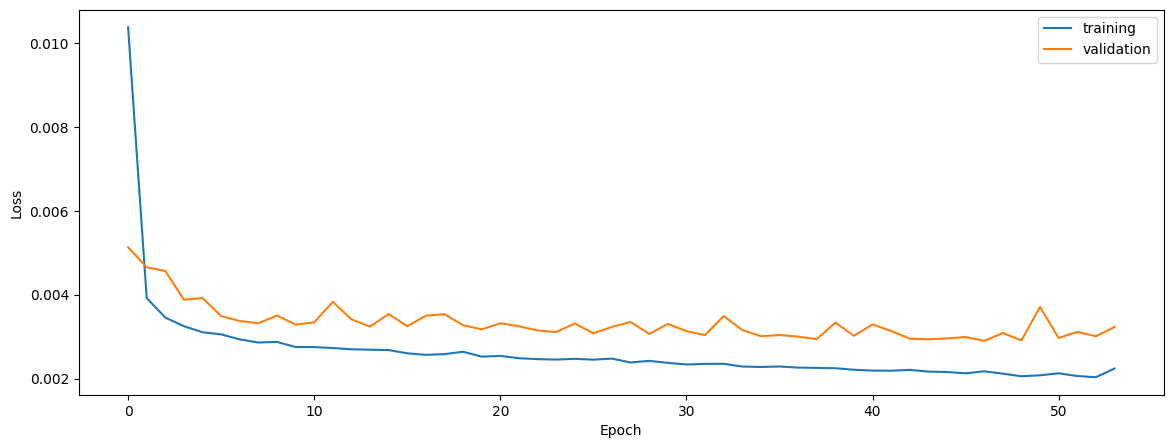

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

train
0.9060646717983962
0.8871517547284169
0.897407192777221


In [8]:
print('normalized')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

normalized
0.9060646717983962
0.8871517547284169
0.897407192777221


In [9]:
print('native')
print(getPearson(train[1][train[2]],train_pred[train[2]]))
print(getPearson(val[1][val[2]],val_pred[val[2]]))
print(getPearson(test[1][test[2]],test_pred[test[2]]))

native
0.88705963582184
0.8687755825386327
0.8822725262656894


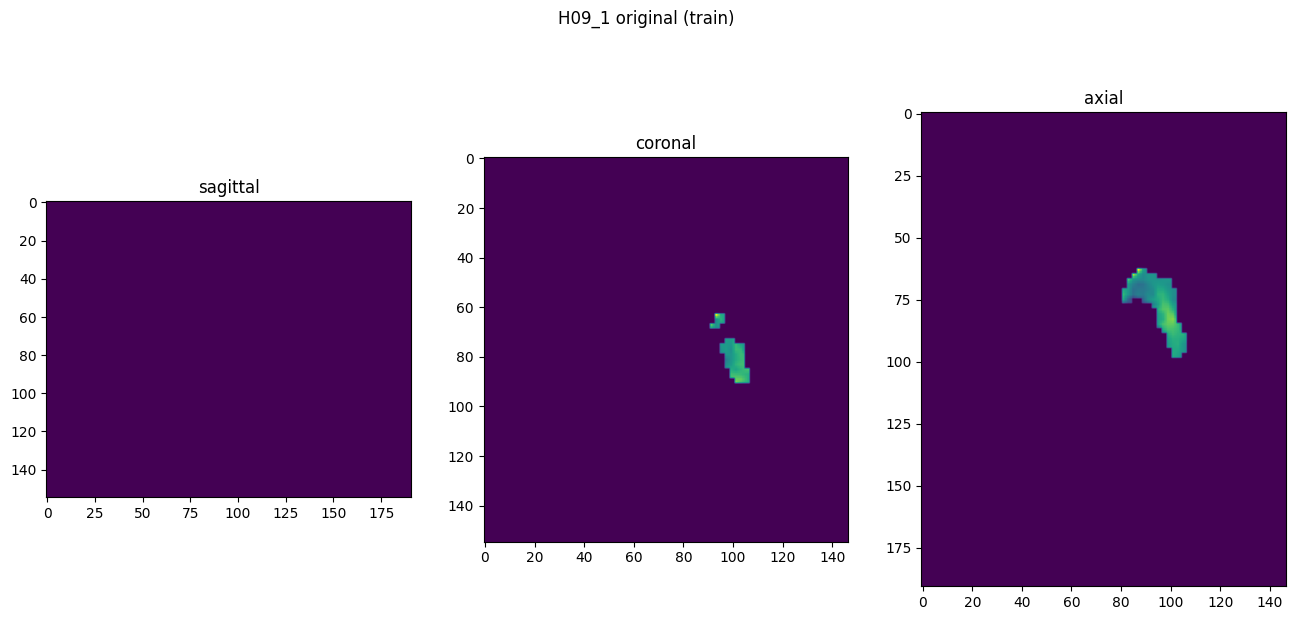

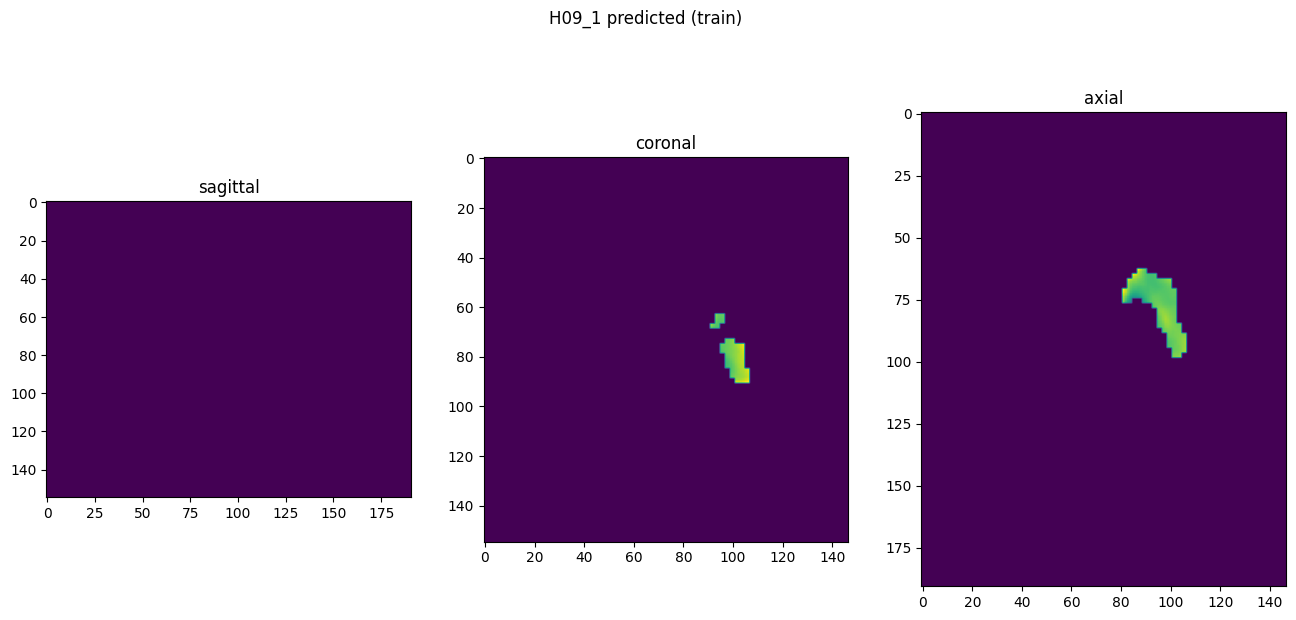

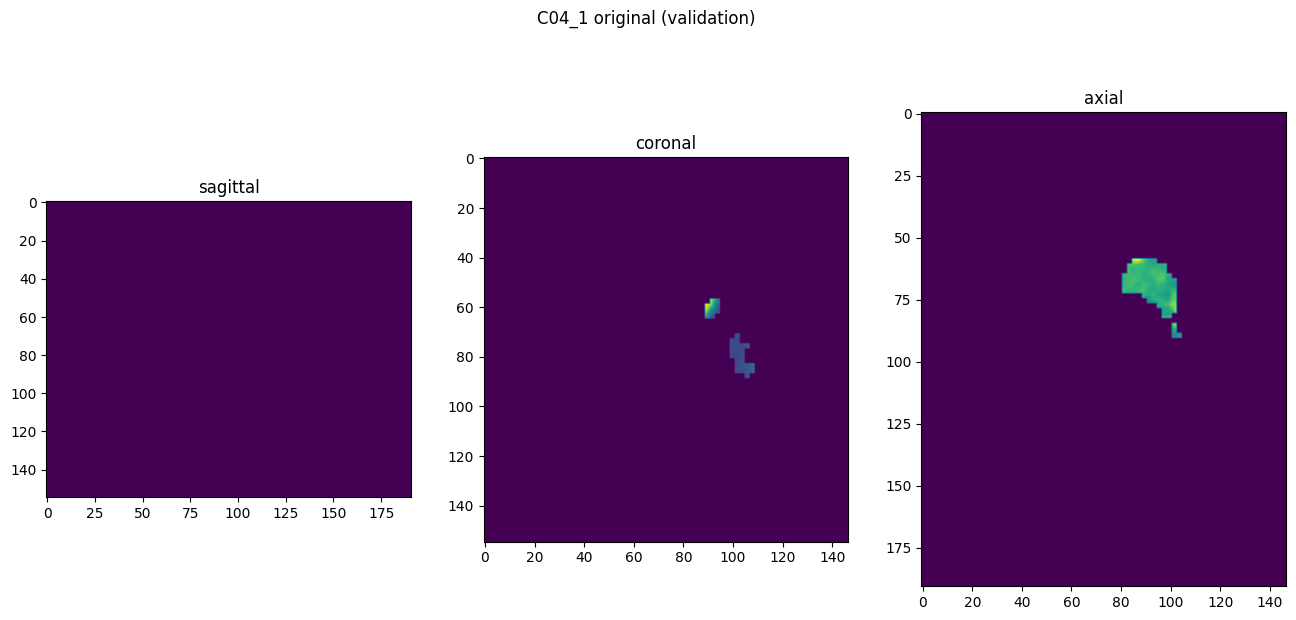

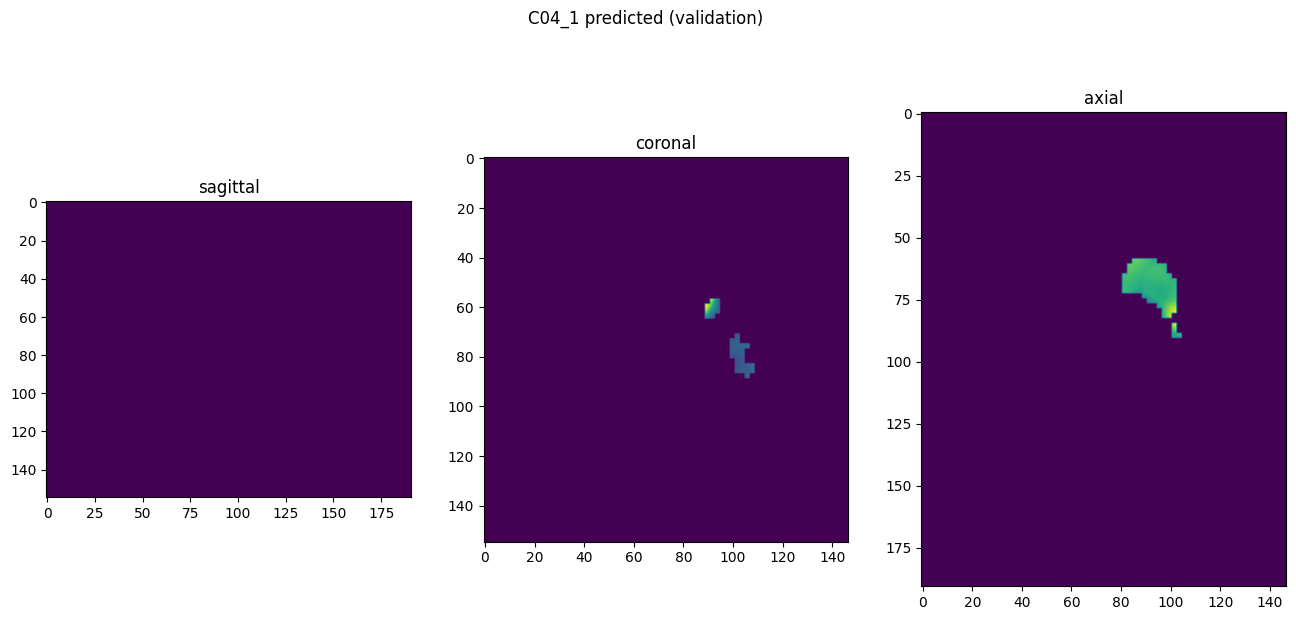

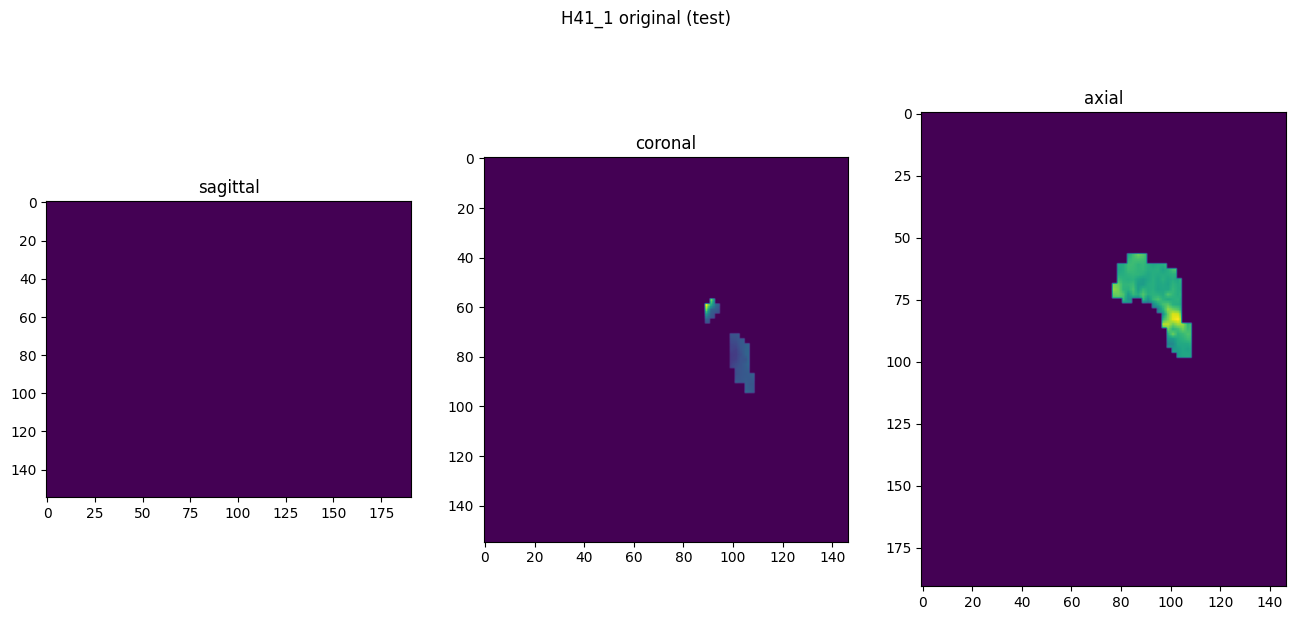

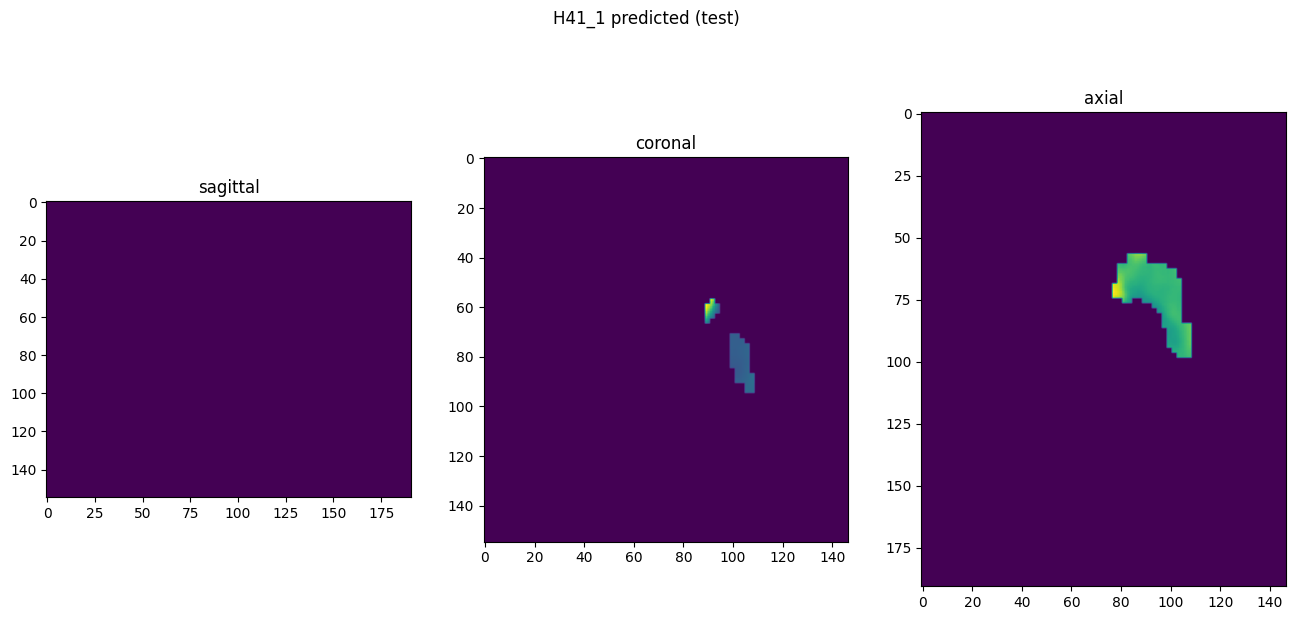

In [10]:
showResults(model, gen, threshold=None, background=False)